In [11]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [12]:
resp_track_df=pd.read_excel("C:/Users/FutureProofInsights/OneDrive - Future Proof Media/Documents/Cathay Pacific/Respondent Tracking/Respondent Tracking_AllMarkets2.xlsx",sheet_name='Full Panel Overview')
sd = pd.read_csv("C:/Users/FutureProofInsights/Downloads/raw_data/CX_SH_PRIZM_SC/survey_data/MERGED_SURVEY_RESPONSE_MATRIX.txt", delimiter="\t")

In [13]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal
from itertools import combinations

def format_results_table(results_df):
    """
    Format the results DataFrame for better display
    """
    # Style the DataFrame
    styled_df = results_df.style
    
    # Add color highlighting for significant results
    styled_df = styled_df.apply(lambda x: ['background-color: lightgreen' if x['Significant'] == 'Yes' 
                                         else 'background-color: lightcoral' for i in x], axis=1)
    
    # Format numeric columns
    styled_df = styled_df.format({
        'H-statistic': '{:.4f}',
        'p-value': '{:.4f}',
        'Effect Size (η²H)': '{:.4f}',
        'Max Group Difference': '{:.2f}'
    })
    
    return styled_df

def calculate_kruskal_effect_size(h_statistic, n):
    """
    Calculate effect size (η²H) for Kruskal-Wallis test
    """
    return (h_statistic - 2) / (n - 3)

def perform_kruskal_analysis(dataframe, categorical_vars, continuous_vars):
    """
    Perform Kruskal-Wallis H-test analysis for all combinations of categorical and continuous variables.
    
    Parameters:
    dataframe: pandas DataFrame containing the data
    categorical_vars: list of categorical variable names
    continuous_vars: list of continuous variable names
    
    Returns:
    Dictionary containing Kruskal-Wallis results
    """
    results = {}
    
    for cat_var in categorical_vars:
        for cont_var in continuous_vars:
            # Create groups based on categorical variable
            groups = [group[cont_var].values for name, group in dataframe.groupby(cat_var)]
            
            # Perform Kruskal-Wallis H-test
            h_statistic, p_value = stats.kruskal(*groups)
            
            # Calculate total sample size
            n_total = sum(len(group) for group in groups)
            
            # Calculate effect size
            effect_size = calculate_kruskal_effect_size(h_statistic, n_total)
            
            # Calculate max difference between groups
            group_medians = [np.median(group) for group in groups]
            group_counts = [len(group) for group in groups]
            print(group_counts)
            max_diff = max(group_medians) - min(group_medians)
            
            # Perform pairwise comparisons if overall test is significant
            pairwise_comparisons = None
            if p_value < 0.05:
                group_names = dataframe[cat_var].unique()
                pairwise_comparisons = {}
                for g1, g2 in combinations(range(len(groups)), 2):
                    stat, p = stats.mannwhitneyu(groups[g1], groups[g2], alternative='two-sided')
                    pairwise_comparisons[f"{group_names[g1]} vs {group_names[g2]}"] = {
                        'statistic': stat,
                        'p_value': p
                    }
            
            # Store results
            results[f"{cat_var} vs {cont_var}"] = {
                'h_statistic': h_statistic,
                'p_value': p_value,
                'effect_size': effect_size,
                'max_difference': max_diff,
                'significant': p_value < 0.05,
                'pairwise_comparisons': pairwise_comparisons
            }
            
            # Create visualization
            if results[f"{cat_var} vs {cont_var}"]['significant']:
                plt.figure(figsize=(10, 6))
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
                
                # Box plot
                sns.boxplot(x=cat_var, y=cont_var, data=dataframe, ax=ax1)
                ax1.set_title('Box Plot')
                ax1.tick_params(axis='x', rotation=45)
                
                # Violin plot
                sns.violinplot(x=cat_var, y=cont_var, data=dataframe, ax=ax2)
                ax2.set_title('Violin Plot')
                ax2.tick_params(axis='x', rotation=45)
                
                plt.suptitle(f'Distribution Analysis: {cat_var} vs {cont_var}')
                plt.tight_layout()
                plt.show()
    
    return results

def print_kruskal_results(results):
    """
    Print Kruskal-Wallis results in a formatted manner.
    """
    print("\nKruskal-Wallis Analysis Results:")
    print("-" * 100)
    for comparison, result in results.items():
        print(f"\nComparison: {comparison}")
        print(f"H-statistic: {result['h_statistic']:.4f}")
        print(f"P-value: {result['p_value']:.4f}")
        print(f"Effect Size (η²H): {result['effect_size']:.4f}")
        print(f"Max Group Difference: {result['max_difference']:.2f}")
        print(f"Statistically Significant: {'Yes' if result['significant'] else 'No'}")
        
        if result['pairwise_comparisons']:
            print("\nPairwise Comparisons (Mann-Whitney U tests):")
            for pair, stats in result['pairwise_comparisons'].items():
                print(f"{pair}:")
                print(f"  Statistic: {stats['statistic']:.4f}")
                print(f"  P-value: {stats['p_value']:.4f}")
        print("-" * 100)



In [4]:
import re
def format_purchase_intent(df,sd):#
    purch_int_dict={'SourceStimuliName':[],'Respondent':[],'Purchase_Intent':[]}
    for stim in df.SourceStimuliName.unique():
        for resp in df.Respondent.unique():
                try:
                    purch_int_dict['SourceStimuliName'].append(stim)
                    purch_int_dict['Respondent'].append(resp)
                    purch_int_dict['Purchase_Intent'].append(sd[(sd['RESPONDENT']==resp)][stim].values[0])
                except Exception as e:
                    print(e,"in format_purchase_intent")
                    purch_int_dict['Purchase_Intent'].append(0)

    pi_df=pd.DataFrame(purch_int_dict)
    return pi_df

def respondent_correction(respondent,pattern=re.Pattern):
    return [re.search(pattern, input_string).group(0) for input_string in respondent]

def get_filtered_df(sd,pattern):
# Use list comprehension to filter columns based on the pattern
    filtered_columns = [col for col in sd.columns if re.search(pattern, col)]

    # Create a new DataFrame with the filtered columns
    filtered_df = sd[filtered_columns]
    filtered_df.fillna('None',inplace=True)
    return filtered_df

def get_purchase_intent():
    pattern = re.compile(r'VALUE PURCHASE INP_\d{4}|VALUE PurINT_INP_\d{4}_PurchInt-INP_\d{4}|VALUE PURCHINT_INP_\d{4}_PURCHINT_INP_\d{4}|VALUE PurINT_INP_\d{4}_PurchInt-INP_|VALUE PURCHINT_CX_INP_\d{3}')
    filtered_df=get_filtered_df(sd.copy(),pattern)
    pattern = re.compile(r'INP_\d{4}|CX_INP_\d{3}')
    filtered_columns = [col for col in filtered_df.columns if re.search(pattern, col)]
    rename_columns= [match.group() if (match := pattern.search(string)) else string for string in filtered_columns]
    filtered_df.rename(columns=dict(zip(filtered_columns, rename_columns)), inplace=True)
    filtered_df['RESPONDENT']=sd['RESPONDENT']
    pi_df=format_purchase_intent(df.copy(),filtered_df.copy())
    pi_df = pi_df[pi_df.iloc[:, 2] != 'None']
    scaler=MinMaxScaler(feature_range=(0,100))
    pi_df_temp=scaler.fit_transform(np.array(pi_df.iloc[:,2]).reshape(-1,1))
    pi_df.iloc[:,2]=pi_df_temp
#     pi_gp_df=pi_df.groupby('SourceStimuliName')['Purchase_Intent'].agg('mean')
    return pi_df

In [5]:
def process_data(df):
    try:
        # Make a copy of the input DataFrame to avoid modifying the original
        df = df.copy()
        
        # Define columns to scale
        columns_to_scale = ['CognitiveLoad', 'Desire', 'Emotion', 'Engagement', 
                           'Ch7_Alpha_power', 'Ch1_Alpha_power', 'Memorisation']
        
        # First, handle missing values
        df.dropna(subset=columns_to_scale, inplace=True)
        
        # Initialize scaler
        scaler = MinMaxScaler(feature_range=(-1, 1))
        
        # Function to process each group
        def process_group(group_df):
            # Create a copy of the group data
            group_data = group_df[columns_to_scale].copy()
            
            # Scale the data
            scaled_data = scaler.fit_transform(group_data)
            
            # Create a new DataFrame with scaled values
            scaled_df = pd.DataFrame(scaled_data, 
                                   columns=columns_to_scale,
                                   index=group_df.index)
            
            return scaled_df

        # Group and process data
        grouped = df.groupby(['SourceStimuliName', 'Respondent'])
        
        # Create empty list to store processed groups
        processed_groups = []
        
        # Process each group
        for name, group in grouped:
            # Get scaled values for this group
            scaled_group = process_group(group)
            
            # Create new group DataFrame with all columns
            new_group = group.copy()
            new_group[columns_to_scale] = scaled_group
            
            processed_groups.append(new_group)
        
        # Combine all processed groups
        df = pd.concat(processed_groups, axis=0)
        
        # Invert CognitiveLoad
        df['CognitiveLoad'] = -1 * df['CognitiveLoad']
        
        # Calculate Impact
        df['Impact'] = (df['Emotion'] * 0.25 + 
                       df['Memorisation'] * 0.25 + 
                       df['Ch7_Alpha_power'] * 0.25 + 
                       df['Ch1_Alpha_power'] * 0.25)
        
        # Transform scaled values to 0-100 range
        columns_to_transform = ['CognitiveLoad', 'Desire', 'Emotion', 
                              'Engagement', 'Memorisation', 'Impact']
        
        for col in columns_to_transform:
            df[col] = (df[col] + 1) * 50
        
        # Calculate final aggregations
        agg_columns = ['CognitiveLoad', 'Desire', 'Emotion', 
                      'Engagement', 'Memorisation', 'Impact']
        
        agg_df = (df.groupby(['SourceStimuliName', 'Respondent'])
                 [agg_columns]
                 .mean()
                 .reset_index())
        
        return agg_df
        
    except Exception as error:
        print("Error occurred while scaling:", error)
        raise  # Re-raise the exception for proper error handling

SourceStimuliName    39650
Respondent           39650
LSL Timestamp        39650
CognitiveLoad        39650
Desire               39650
Emotion              39650
Engagement           39650
Ch7_Alpha_power      39650
Ch1_Alpha_power      39650
Memorisation         39650
dtype: int64
'Baseline30sFixCross' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_014' in format_purchase_intent


C:\Users\FutureProofInsights\AppData\Local\Temp\ipykernel_35272\1892023163.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna('None',inplace=True)


'CX_INP_015' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
SourceStimuliName    237150
Respondent           237150
LSL Timestamp        237150
CognitiveLoad        237150
Desire               237150
Emotion              237150
Engagement           237150
Ch7_Alpha_power      237150
Ch1_Alpha_power      237150
Memorisation         237150
dtype: int64


C:\Users\FutureProofInsights\AppData\Local\Temp\ipykernel_35272\1892023163.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna('None',inplace=True)


'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_014' in format_purchase_intent
'CX_INP_014' in format_purchase_intent
'CX_INP_014' in format_purchase_intent
'CX_INP_014' in format_purchase_intent
'CX_INP_014' in format_purchase_intent
'CX_INP_014' in format_purchase_intent
'CX_INP_015' in format_purchase_intent
'CX_INP_015' in format_purchase_intent
'CX_INP_015' in format_purchase_intent
'CX_INP_015' in format_purchase_intent
'CX_INP_015' in format_purchase_intent
'CX_INP_015' in format_purchase_intent
'CX_INP_01

C:\Users\FutureProofInsights\AppData\Local\Temp\ipykernel_35272\1892023163.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna('None',inplace=True)


'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_014' in format_purchase_intent
'CX_INP_014' in format_purchase_intent
'CX_INP_014' in format_purchase_intent
'CX_INP_014' in format_purchase_intent
'CX_INP_014' in format_purchase_intent
'CX_INP_014' in format_purchase_intent
'CX_INP_014' in format_purchase_intent
'CX_INP_014' in format_purchase

C:\Users\FutureProofInsights\AppData\Local\Temp\ipykernel_35272\1892023163.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna('None',inplace=True)


'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase

'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_purchase_intent
'CX_INP_016' in format_pu

C:\Users\FutureProofInsights\AppData\Local\Temp\ipykernel_35272\1892023163.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna('None',inplace=True)


'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'Baseline30sFixCross' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_purchase_intent
'CX_INP_013' in format_pu

<Figure size 1000x600 with 0 Axes>

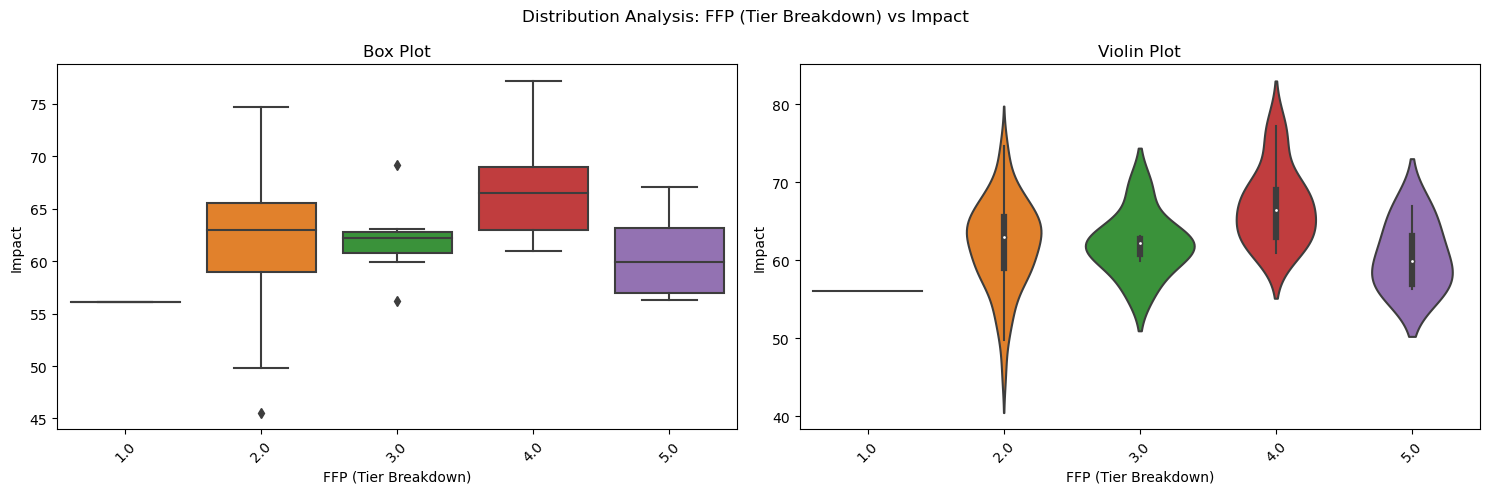

[2, 10, 16, 1, 30, 24]
[2, 10, 16, 1, 30, 24]
[2, 10, 16, 1, 30, 24]
[2, 10, 16, 1, 30, 24]
[2, 10, 16, 1, 30, 24]
[2, 10, 16, 1, 30, 24]

Kruskal-Wallis Analysis Results:
----------------------------------------------------------------------------------------------------

Comparison: FFP (Tier Breakdown) vs Desire
H-statistic: 5.0687
P-value: 0.2803
Effect Size (η²H): 0.0384
Max Group Difference: 19.04
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: FFP (Tier Breakdown) vs CognitiveLoad
H-statistic: 5.4424
P-value: 0.2448
Effect Size (η²H): 0.0430
Max Group Difference: 5.13
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: FFP (Tier Breakdown) vs Engagement
H-statistic: 3.8941
P-value: 0.4205
Effect Size (η²H): 0.0237
Max Group Difference: 9.22
Statistically Significant: No
------------------------

In [6]:
columns_to_keep = [
    'SourceStimuliName', 'Respondent','LSL Timestamp', 'CognitiveLoad',
    'Desire', 'Emotion', 'Engagement', 'Ch7_Alpha_power', 
    'Ch1_Alpha_power', 'Memorisation'
]
#agg_df = pd.read_csv("aggregated_data_CX_SH_PRIZM_SC_aggregated.csv")
for segmentation in ['FFP (Tier Breakdown)']:#['Age Bracket', 'Gender', 'Occupation Group', 'Class', 'Purpose','Salary Group', 'Travelled P12M','FFP (Tier Breakdown)','Class']:
    try:
        #segmentation='Age Bracket'#Age Bracket', 'Gender', 'Occupation Group', 'Class', 'Purpose','Salary Group', 'Travelled P12M','FFP (Tier Breakdown)','Class']
        # Define genders to process
        location='SHA'
        segments = resp_track_df[resp_track_df['CITY']==location][segmentation].unique()


        # Initialize empty list to store processed dataframes
        processed_dfs = []

        # Loop through each gender
#         if segmentation=='FFP (Tier Breakdown)':
#             valid_segments = [str(int(segment)) for segment in segments if pd.notna(segment)]
#         else:
        valid_segments = [segment for segment in segments if pd.notna(segment)]
        for segment in valid_segments:

            # Construct the file path
            file_path = f"./CX_SH_PRIZM_SC_{segmentation}_{segment}/feature_extracted_data_CX_SH_PRIZM_SC_{segmentation}_{segment}.csv"

            # Read and process the data
            df = pd.read_csv(file_path)
            df.dropna(inplace=True)
            # Select required columns
            df = df[columns_to_keep]

            # Filter for specific stimulus
            print(df[df['SourceStimuliName'] == 'CX_INP_002'].count())

            pattern = r'(?<=_)\w+'
            df.Respondent = respondent_correction(df.Respondent,pattern)
            pi_df=get_purchase_intent()



            # Process the data
            processed_df = process_data(df)
            processed_df=processed_df.merge(pi_df,on=['SourceStimuliName','Respondent'])
            updates=processed_df.groupby('SourceStimuliName')[['CognitiveLoad',
               'Desire', 'Emotion', 'Engagement','Memorisation', 'Impact','Purchase_Intent']].mean().reset_index()
        #         mask = (df['SourceStimuliName'] == updates_dict['SourceStimuliName']) & \
        #            (df['segmentation_option'] == segmentation_option)

            # Update the specific columns
            metrics = ['Engagement', 'Emotion', 'CognitiveLoad', 'Desire', 
                      'Memorisation', 'Impact']

            # Iterate through each row in the updates DataFrame
#             for _, update_row in updates.iterrows():
#                 # Create mask for matching the SourceStimuliName
#                 mask = (agg_df['SourceStimuliName'] == update_row['SourceStimuliName']) & (agg_df['segmentation_type']==segmentation) & (agg_df['segmentation_option']==segment)

#                 # Update each metric column
#                 for metric in metrics:
#                     if metric in update_row.index:
#                         agg_df.loc[mask, metric] = update_row[metric]
            # Add to list of processed dataframes
            processed_dfs.append(processed_df)

        # Combine all processed dataframes
        final_df = pd.concat(processed_dfs)
        final_df.drop_duplicates(inplace=True)
        #df=final_df
        #df['Respondent']=df['Respondent'].apply(lambda x : x[4:])
        merged_df=pd.merge(final_df,resp_track_df,left_on='Respondent',right_on='Imotions ID ',how='inner')
        grouped_df = merged_df.groupby(['SourceStimuliName', segmentation])[['CognitiveLoad',
               'Desire', 'Emotion', 'Engagement', 'Memorisation', 'Impact','Purchase_Intent']].mean()
        # Define variable lists
        categorical_variables = [segmentation,'Purchase_Intent']#['
        continuous_variables = ['Desire', 'CognitiveLoad', 'Engagement', 'Emotion', 'Memorisation','Impact']


        sample=merged_df[merged_df['SourceStimuliName']=='CX_INP_002']#CX_INP_002
        # Perform ANOVA analysis
        results = perform_kruskal_analysis(sample.copy(), categorical_variables, continuous_variables)


        # Print results
        print_kruskal_results(results)
    except:
        pass

In [7]:
merged_df[(merged_df['SourceStimuliName']=='CX_INP_002') & (merged_df['Class']=='Econ')]['Purchase_Intent']

1       83.333333
93     100.000000
119     85.714286
143    100.000000
167     85.714286
203     71.428571
239     85.714286
251    100.000000
275    100.000000
287    100.000000
311     85.714286
347    100.000000
359     71.428571
371     71.428571
407     85.714286
419     71.428571
443     85.714286
455     85.714286
467    100.000000
479    100.000000
491     71.428571
503     71.428571
551     42.857143
575     57.142857
599     71.428571
611     85.714286
623     85.714286
635     85.714286
659     57.142857
695     57.142857
719     57.142857
755     71.428571
815    100.000000
827     57.142857
906     85.714286
Name: Purchase_Intent, dtype: float64

In [8]:
agg_df[(agg_df['SourceStimuliName']=='CX_INP_002')].groupby(['SourceStimuliName'])[['CognitiveLoad',
       'Desire', 'Emotion', 'Engagement','Memorisation', 'Impact']].mean().reset_index()

NameError: name 'agg_df' is not defined

In [ ]:
df.columns

In [ ]:
# agg_df.to_csv("aggregated_data_China A_aggregated.csv",index=False)

In [ ]:
processed_df.groupby(['SourceStimuliName','Respondent'])[['Engagement']].describe().reset_index()

In [ ]:
print(pd.DataFrame(results).T)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

def plot_mi(df, continuous_col, categorical_col, n_bins=10):
    # Prepare data
    continuous_data = df[continuous_col].values.reshape(-1, 1)
    categorical_data = df[categorical_col].values
    
    # Discretize continuous variable
    kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    continuous_discrete = kbd.fit_transform(continuous_data).flatten()
    bin_edges = kbd.bin_edges_[0]
    for idx,i in enumerate(bin_edges):
        print(idx,i)
    
    # Calculate joint distribution
    joint_counts = pd.crosstab(continuous_discrete, categorical_data, normalize='all')
    
    # Calculate marginal probabilities
    p_x = joint_counts.sum(axis=1)
    p_y = joint_counts.sum(axis=0)
    
    # Calculate mutual information
    mi = 0
    for i in joint_counts.index:
        for j in joint_counts.columns:
            if joint_counts.loc[i,j] > 0:
                mi += joint_counts.loc[i,j] * np.log2(joint_counts.loc[i,j] / 
                                                     (p_x[i] * p_y[j]))
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(joint_counts, annot=True, fmt='.3f', cmap='YlOrRd')
    plt.title(f'Mutual Information between {continuous_col} and {categorical_col}: {mi:.3f} bits')
    plt.xlabel(categorical_col)
    plt.ylabel(f'{continuous_col} (Binned)')
    plt.show()
    
    return mi

#Example usage:
mi = plot_mi(sample, 'Impact', 'Purchase_Intent', n_bins=10)
# mi = plot_mi(sample, 'Engagement', 'Purchase_Intent', n_bins=10)
# mi = plot_mi(sample, 'Memorisation', 'Purchase_Intent', n_bins=10)
# mi = plot_mi(sample, 'Impact', 'Purchase_Intent', n_bins=10)

In [ ]:
pi_gp_df[pi_gp_df['SourceStimuliName']=='CX_INP_002']

### Segmentwise ANOVA Analysis

In [58]:
categorical_variables=['Gender','Age Bracket', 'Occupation Group', 'Class', 'Purpose','Salary Group', 'Travelled P12M','FFP (Tier Breakdown)','Purchase_Intent']
categorical_variables.remove(segmentation)
print(categorical_variables)
for segment in valid_segments:
        print(segment)
        sample=merged_df[(merged_df['SourceStimuliName']=='CX_INP_002') & (merged_df[segmentation]==segment)]#CX_INP_002
    # Perform ANOVA analysis
        results = perform_anova_analysis(sample.copy(), categorical_variables, continuous_variables)


        print(pd.DataFrame(results).T)
# Print results
#print_anova_results(results)

['Gender', 'Age Bracket', 'Occupation Group', 'Class', 'Purpose', 'Salary Group', 'Travelled P12M', 'Purchase_Intent']
1.0


TypeError: at least two inputs are required; got 1.

f_statistic   p_value significant
Age Bracket vs Desire                    0.579137   0.67953       False
Age Bracket vs CognitiveLoad             0.960898  0.440071       False
Age Bracket vs Engagement                0.982124  0.428834       False
Age Bracket vs Emotion                   0.404557  0.804158       False
Age Bracket vs Memorisation               0.79566  0.535456       False
Age Bracket vs Impact                    0.736949  0.572601       False
Occupation Group vs Desire               0.568288  0.639216       False
Occupation Group vs CognitiveLoad        0.247628   0.86252       False
Occupation Group vs Engagement           1.500459  0.229536       False
Occupation Group vs Emotion              0.856677  0.471634       False
Occupation Group vs Memorisation         0.415001  0.743177       False
Occupation Group vs Impact               0.588388  0.626271       False
Class vs Desire                          3.484011  0.024695        True
Class vs CognitiveLoad                   2.325733  0.089699       False
Class vs Engagement                      0.563957  0.642029       False
Class vs Emotion                         1.333197  0.277504       False
Class vs Memorisation                    2.084222  0.118009       False
Class vs Impact                          0.784681  0.509733       False
Purpose vs Desire                        0.488216  0.488669       False
Purpose vs CognitiveLoad                 1.774705  0.190159       False
Purpose vs Engagement                    0.411558   0.52475       False
Purpose vs Emotion                       0.596783  0.444239       False
Purpose vs Memorisation                  0.145828  0.704527       False
Purpose vs Impact                        0.104276  0.748399       False
Salary Group vs Desire                   0.028034  0.972374       False
Salary Group vs CognitiveLoad            0.159505  0.853105       False
Salary Group vs Engagement               1.068629  0.353081       False
Salary Group vs Emotion                  1.868272  0.167614       False
Salary Group vs Memorisation             0.445581  0.643593       False
Salary Group vs Impact                   1.383116  0.262531       False
Travelled P12M vs Desire                 0.260995  0.612177       False
Travelled P12M vs CognitiveLoad          2.124293  0.152597       False
Travelled P12M vs Engagement             0.350594  0.557028       False
Travelled P12M vs Emotion                0.142912  0.707354       False
Travelled P12M vs Memorisation           0.002625  0.959385       False
Travelled P12M vs Impact                 0.170189  0.682093       False
FFP (Tier Breakdown) vs Desire           1.972479  0.134026       False
FFP (Tier Breakdown) vs CognitiveLoad    0.330708   0.80316       False
FFP (Tier Breakdown) vs Engagement       0.042153  0.988297       False
FFP (Tier Breakdown) vs Emotion          0.215499  0.885055       False
FFP (Tier Breakdown) vs Memorisation     0.847178  0.476518       False
FFP (Tier Breakdown) vs Impact           0.567548  0.639697       False

25-34
[18, 10]
[18, 10]
[18, 10]
[18, 10]
[18, 10]
[18, 10]
[18, 6, 2, 1, 1]
[18, 6, 2, 1, 1]
[18, 6, 2, 1, 1]
[18, 6, 2, 1, 1]
[18, 6, 2, 1, 1]
[18, 6, 2, 1, 1]
[4, 12, 7, 5]
[4, 12, 7, 5]
[4, 12, 7, 5]
[4, 12, 7, 5]
[4, 12, 7, 5]
[4, 12, 7, 5]
[9, 19]
[9, 19]
[9, 19]


<Figure size 1000x600 with 0 Axes>

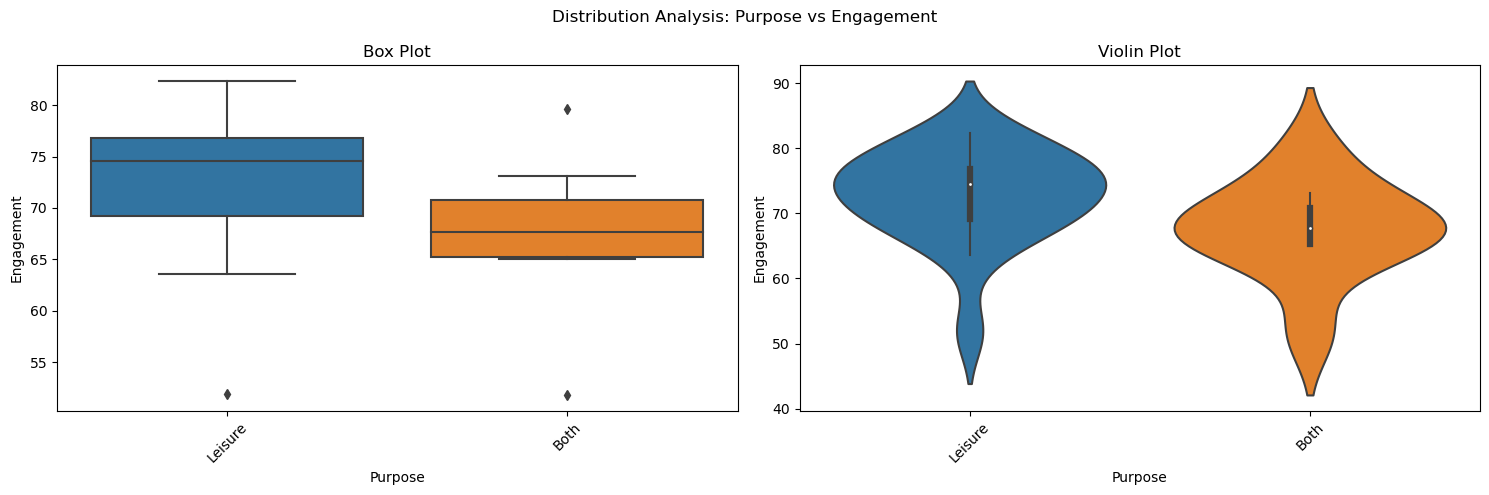

[9, 19]
[9, 19]
[9, 19]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]

Kruskal-Wallis Analysis Results:
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Desire
H-statistic: 0.8299
P-value: 0.3623
Effect Size (η²H): -0.0468
Max Group Difference: 1.11
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs CognitiveLoad
H-statistic: 1.3241
P-value: 0.2499
Effect Size (η²H): -0.0270
Max Group Difference: 1.85
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Engagement
H-statistic: 0.6644
P-value: 0.4150
Effect Size (η²H): -0.0534
Max Group Dif

[11, 16, 5, 4]


<Figure size 1000x600 with 0 Axes>

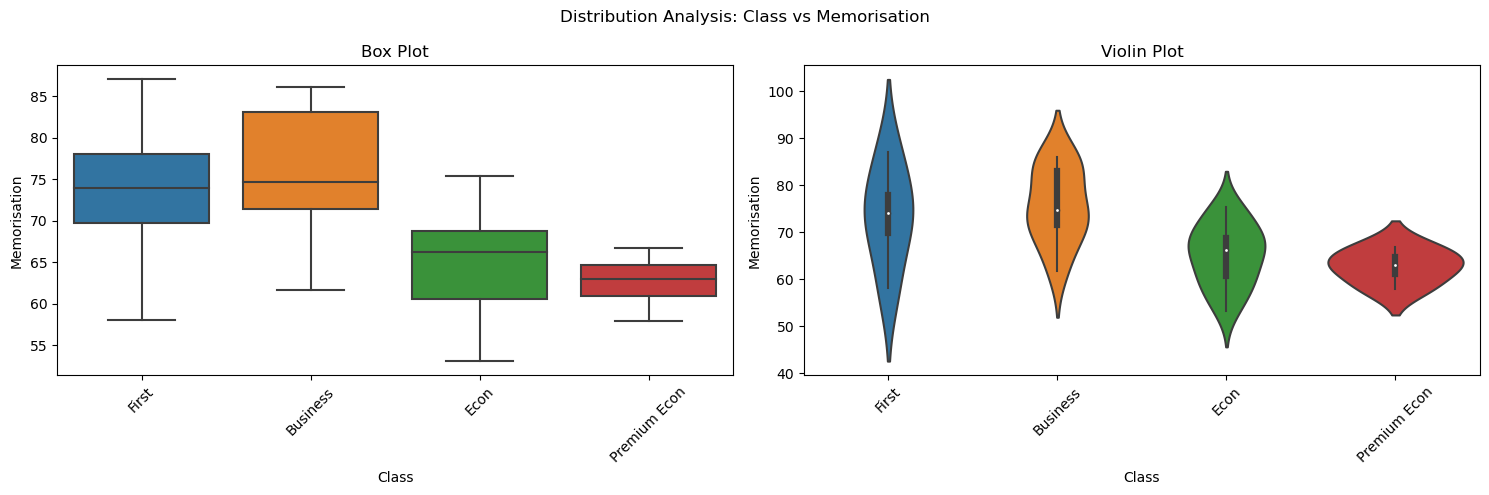

[11, 16, 5, 4]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[26, 2, 6, 2]
[26, 2, 6, 2]
[26, 2, 6, 2]


<Figure size 1000x600 with 0 Axes>

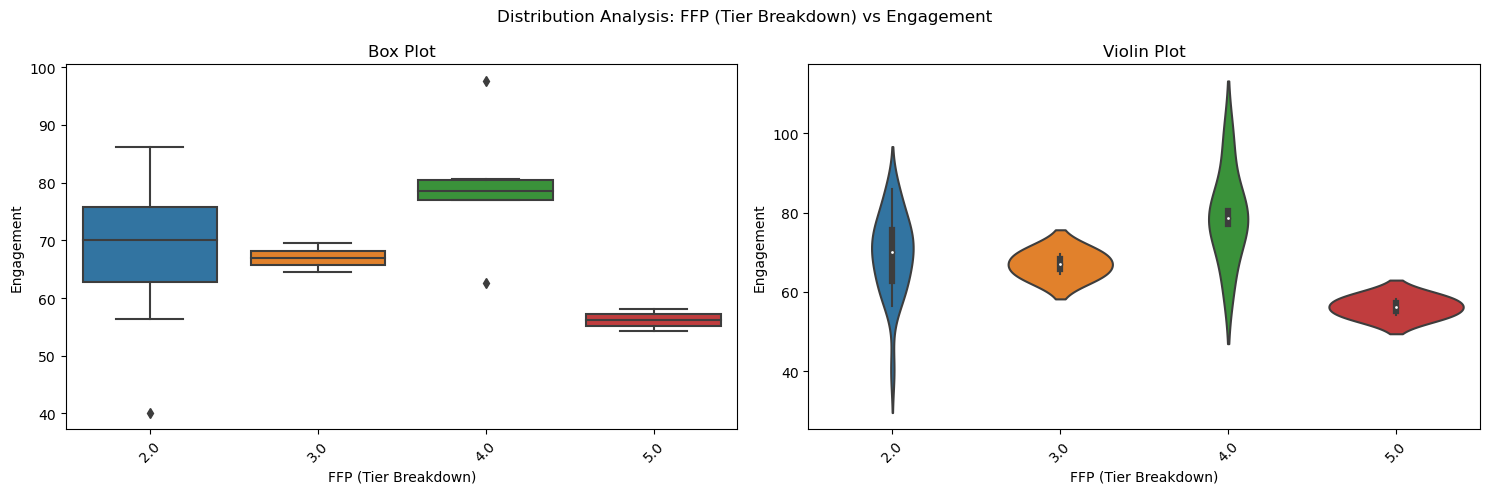

[26, 2, 6, 2]
[26, 2, 6, 2]
[26, 2, 6, 2]

Kruskal-Wallis Analysis Results:
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Desire
H-statistic: 1.4883
P-value: 0.2225
Effect Size (η²H): -0.0155
Max Group Difference: 1.04
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs CognitiveLoad
H-statistic: 0.0906
P-value: 0.7634
Effect Size (η²H): -0.0579
Max Group Difference: 2.90
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Engagement
H-statistic: 0.5545
P-value: 0.4565
Effect Size (η²H): -0.0438
Max Group Difference: 1.22
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Emotion
H-statistic: 0.7594
P-value:

<Figure size 1000x600 with 0 Axes>

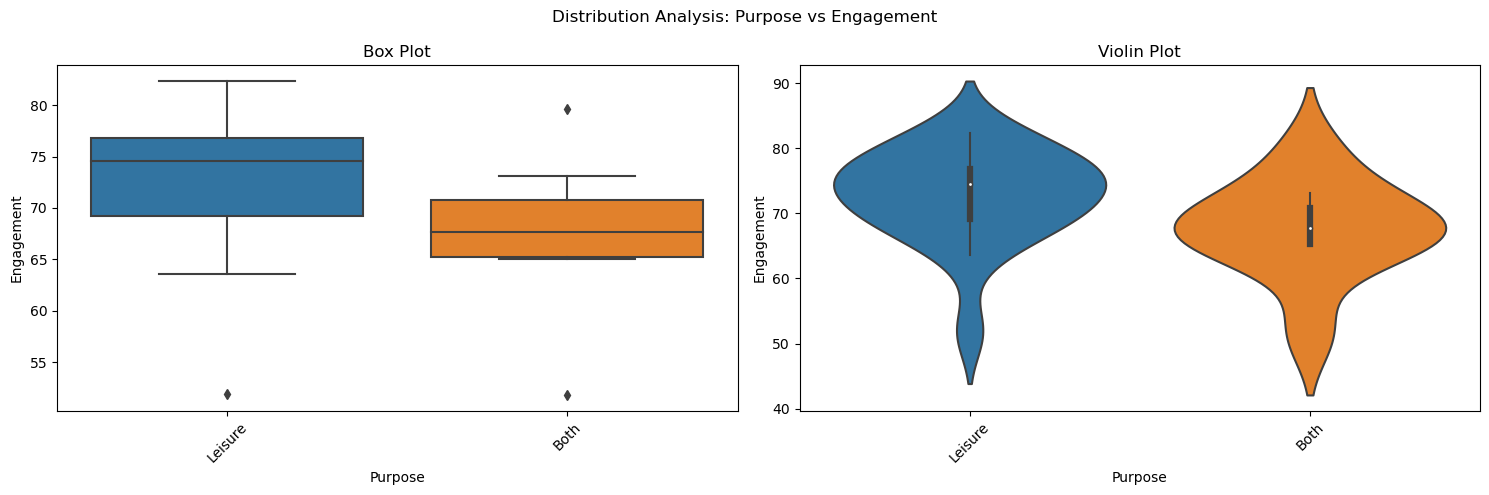

[9, 19]
[9, 19]
[9, 19]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]

Kruskal-Wallis Analysis Results:
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Desire
H-statistic: 0.8299
P-value: 0.3623
Effect Size (η²H): -0.0468
Max Group Difference: 1.11
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs CognitiveLoad
H-statistic: 1.3241
P-value: 0.2499
Effect Size (η²H): -0.0270
Max Group Difference: 1.85
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Engagement
H-statistic: 0.6644
P-value: 0.4150
Effect Size (η²H): -0.0534
Max Group Dif

<Figure size 1000x600 with 0 Axes>

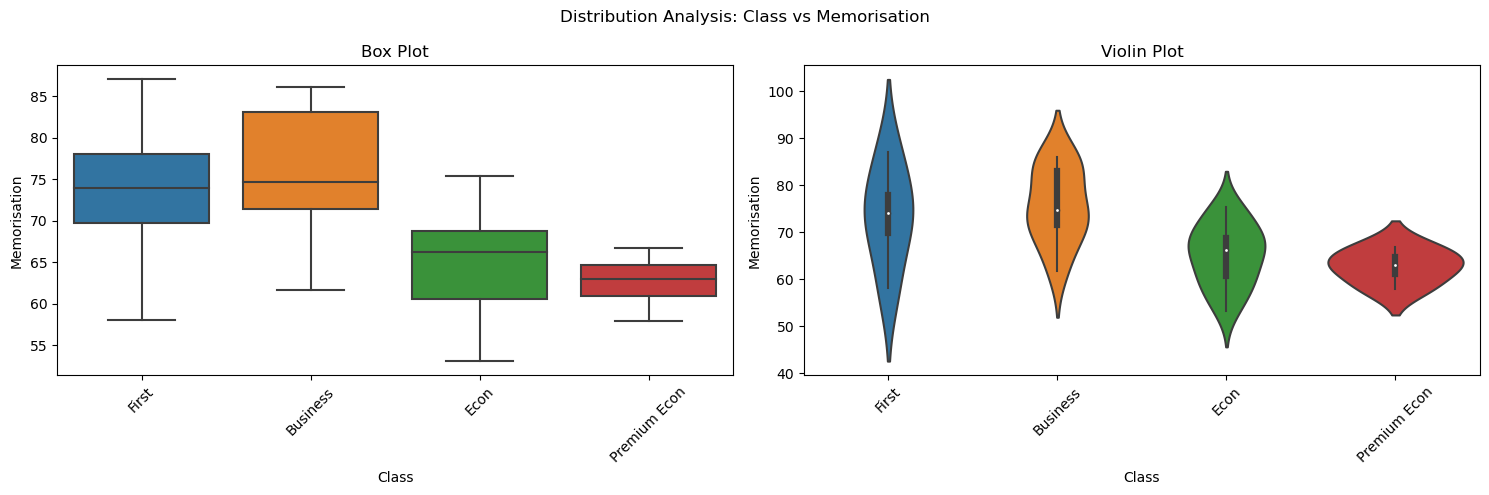

[11, 16, 5, 4]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[26, 2, 6, 2]
[26, 2, 6, 2]
[26, 2, 6, 2]


<Figure size 1000x600 with 0 Axes>

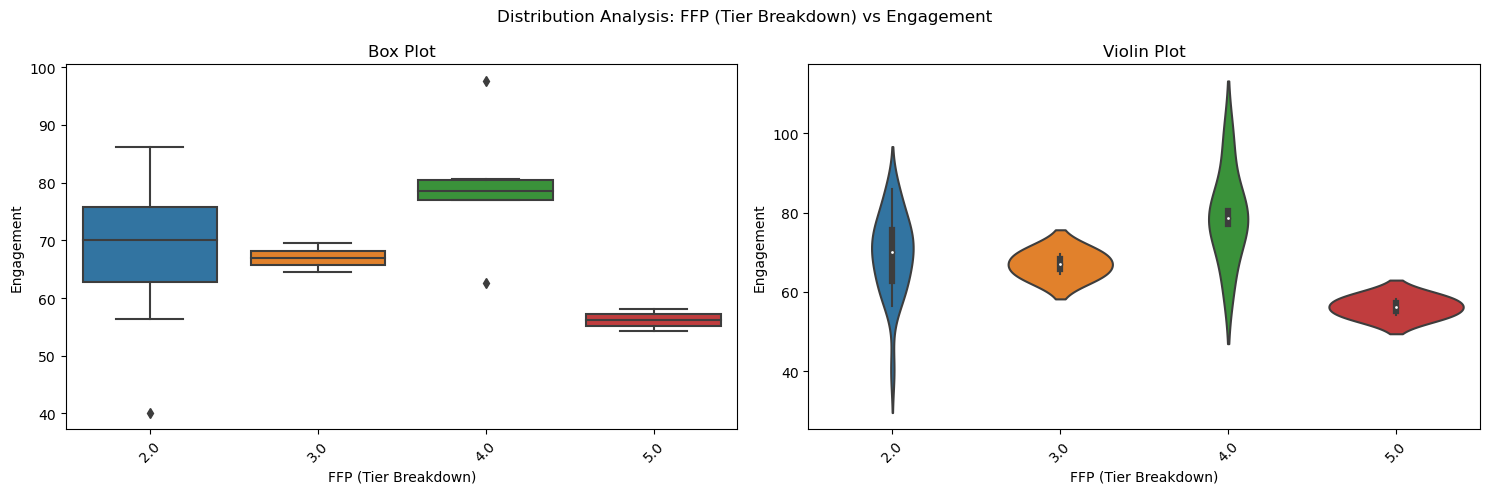

[26, 2, 6, 2]
[26, 2, 6, 2]
[26, 2, 6, 2]

Kruskal-Wallis Analysis Results:
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Desire
H-statistic: 1.4883
P-value: 0.2225
Effect Size (η²H): -0.0155
Max Group Difference: 1.04
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs CognitiveLoad
H-statistic: 0.0906
P-value: 0.7634
Effect Size (η²H): -0.0579
Max Group Difference: 2.90
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Engagement
H-statistic: 0.5545
P-value: 0.4565
Effect Size (η²H): -0.0438
Max Group Difference: 1.22
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Emotion
H-statistic: 0.7594
P-value:

<Figure size 1000x600 with 0 Axes>

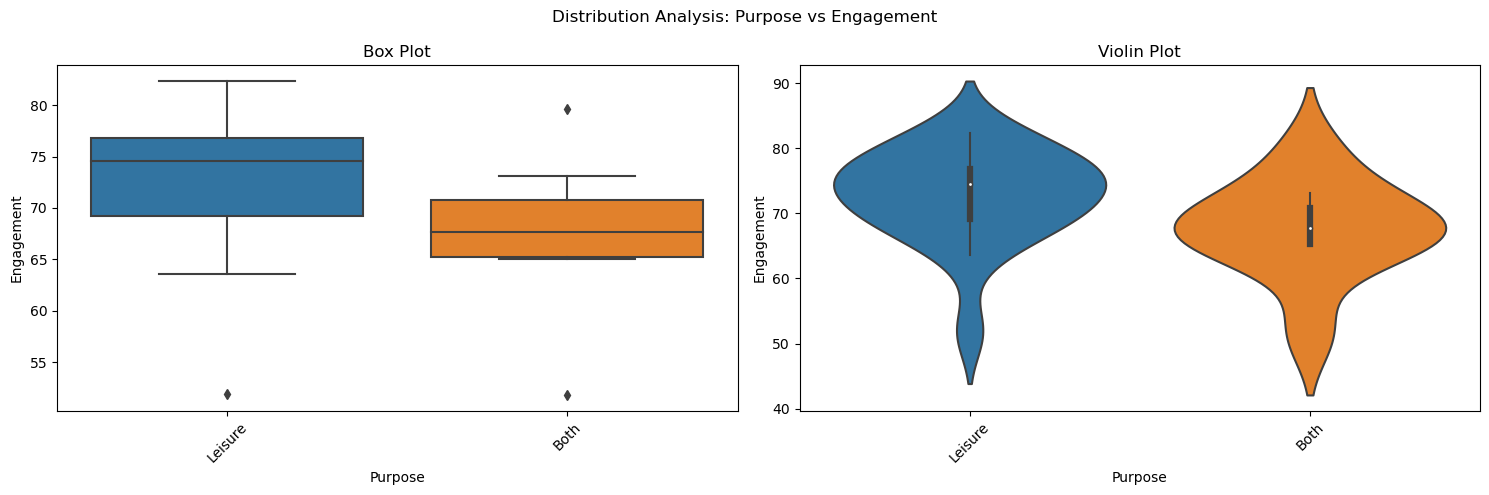

[9, 19]
[9, 19]
[9, 19]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]

Kruskal-Wallis Analysis Results:
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Desire
H-statistic: 0.8299
P-value: 0.3623
Effect Size (η²H): -0.0468
Max Group Difference: 1.11
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs CognitiveLoad
H-statistic: 1.3241
P-value: 0.2499
Effect Size (η²H): -0.0270
Max Group Difference: 1.85
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Engagement
H-statistic: 0.6644
P-value: 0.4150
Effect Size (η²H): -0.0534
Max Group Dif

<Figure size 1000x600 with 0 Axes>

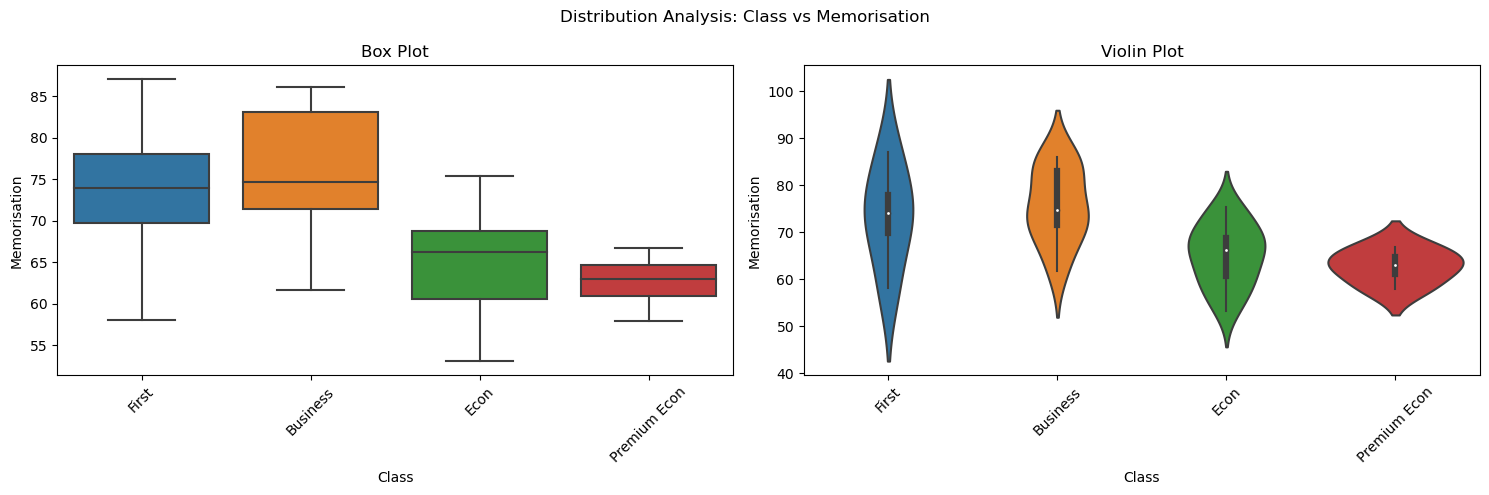

[11, 16, 5, 4]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[26, 2, 6, 2]
[26, 2, 6, 2]
[26, 2, 6, 2]


<Figure size 1000x600 with 0 Axes>

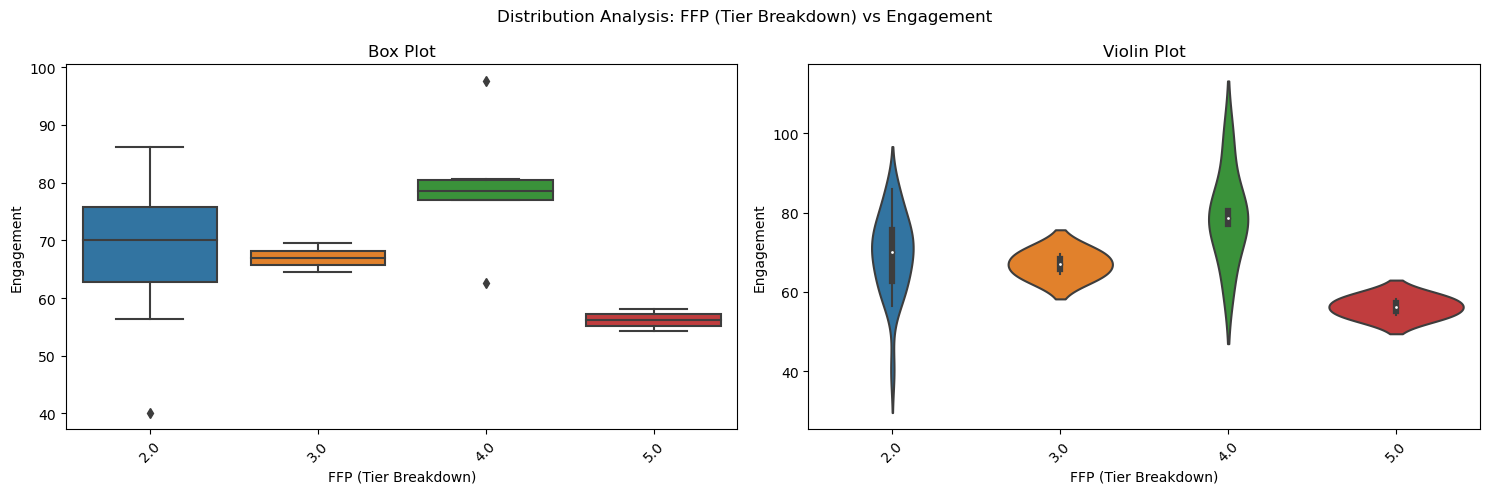

[26, 2, 6, 2]
[26, 2, 6, 2]
[26, 2, 6, 2]

Kruskal-Wallis Analysis Results:
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Desire
H-statistic: 1.4883
P-value: 0.2225
Effect Size (η²H): -0.0155
Max Group Difference: 1.04
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs CognitiveLoad
H-statistic: 0.0906
P-value: 0.7634
Effect Size (η²H): -0.0579
Max Group Difference: 2.90
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Engagement
H-statistic: 0.5545
P-value: 0.4565
Effect Size (η²H): -0.0438
Max Group Difference: 1.22
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Emotion
H-statistic: 0.7594
P-value:

<Figure size 1000x600 with 0 Axes>

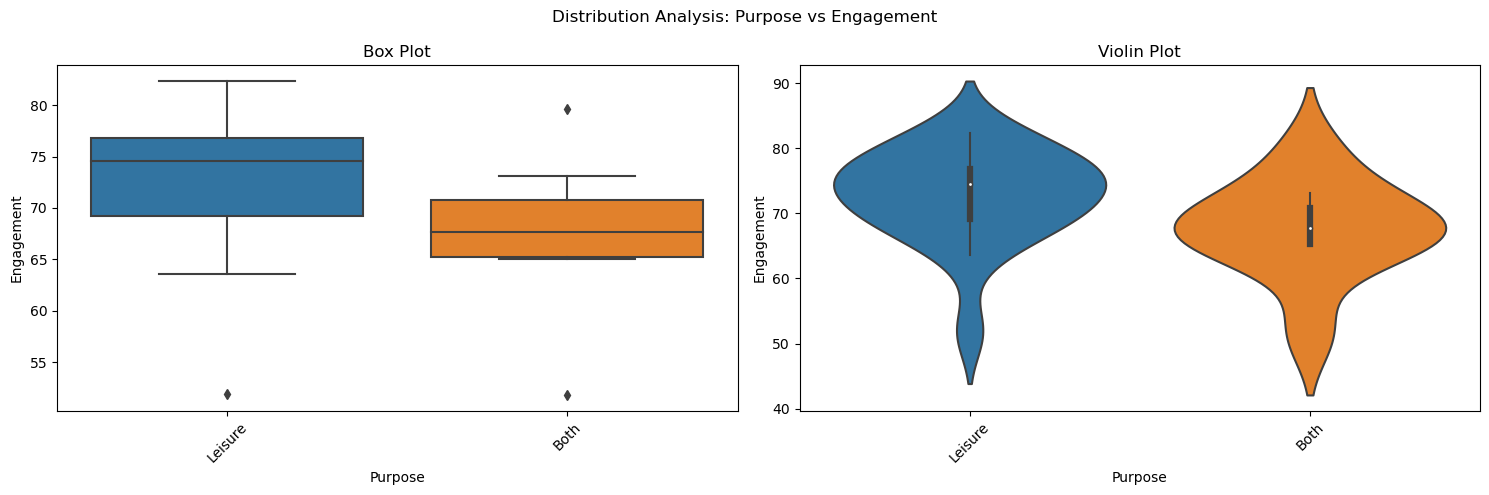

[9, 19]
[9, 19]
[9, 19]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]

Kruskal-Wallis Analysis Results:
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Desire
H-statistic: 0.8299
P-value: 0.3623
Effect Size (η²H): -0.0468
Max Group Difference: 1.11
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs CognitiveLoad
H-statistic: 1.3241
P-value: 0.2499
Effect Size (η²H): -0.0270
Max Group Difference: 1.85
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Engagement
H-statistic: 0.6644
P-value: 0.4150
Effect Size (η²H): -0.0534
Max Group Dif

<Figure size 1000x600 with 0 Axes>

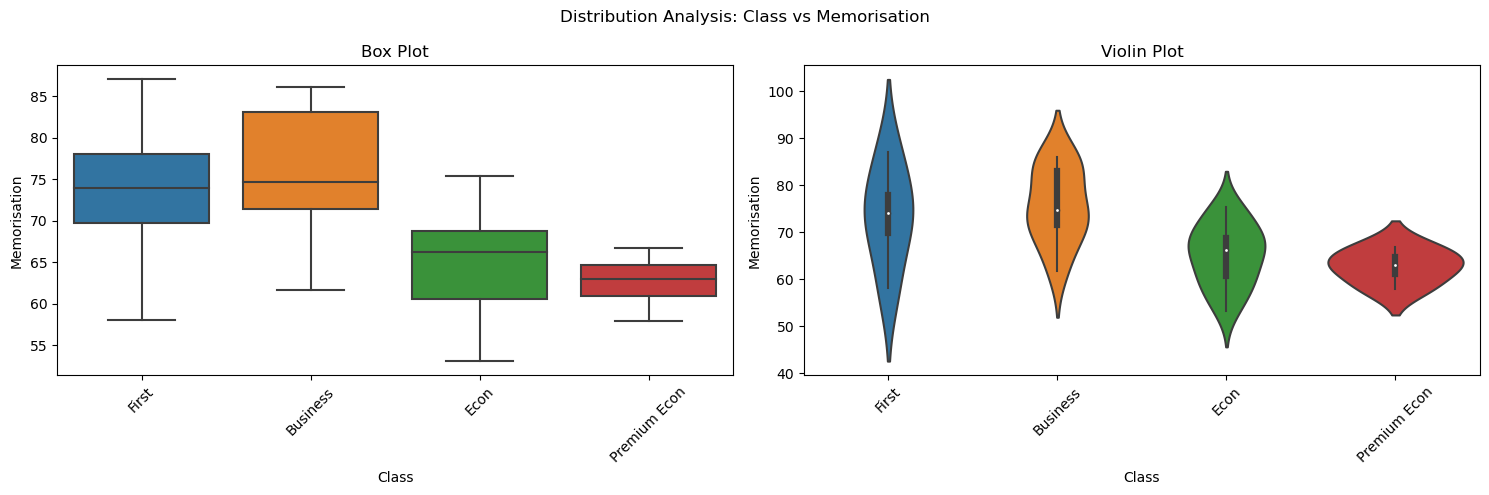

[11, 16, 5, 4]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[26, 2, 6, 2]
[26, 2, 6, 2]
[26, 2, 6, 2]


<Figure size 1000x600 with 0 Axes>

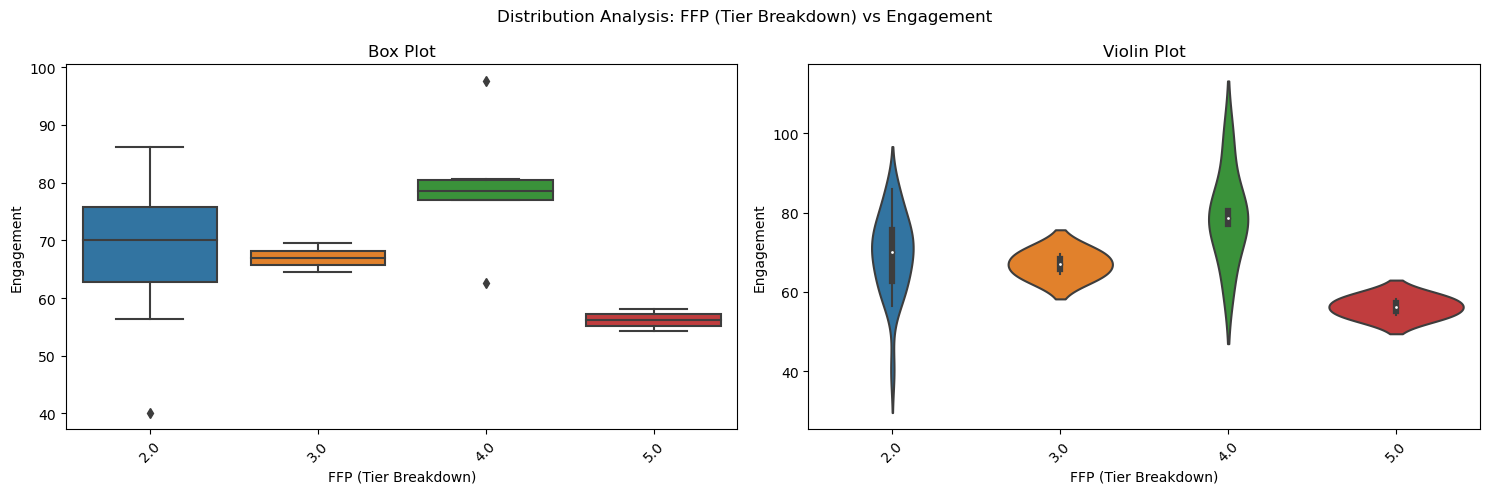

[26, 2, 6, 2]
[26, 2, 6, 2]
[26, 2, 6, 2]

Kruskal-Wallis Analysis Results:
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Desire
H-statistic: 1.4883
P-value: 0.2225
Effect Size (η²H): -0.0155
Max Group Difference: 1.04
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs CognitiveLoad
H-statistic: 0.0906
P-value: 0.7634
Effect Size (η²H): -0.0579
Max Group Difference: 2.90
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Engagement
H-statistic: 0.5545
P-value: 0.4565
Effect Size (η²H): -0.0438
Max Group Difference: 1.22
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Emotion
H-statistic: 0.7594
P-value:

<Figure size 1000x600 with 0 Axes>

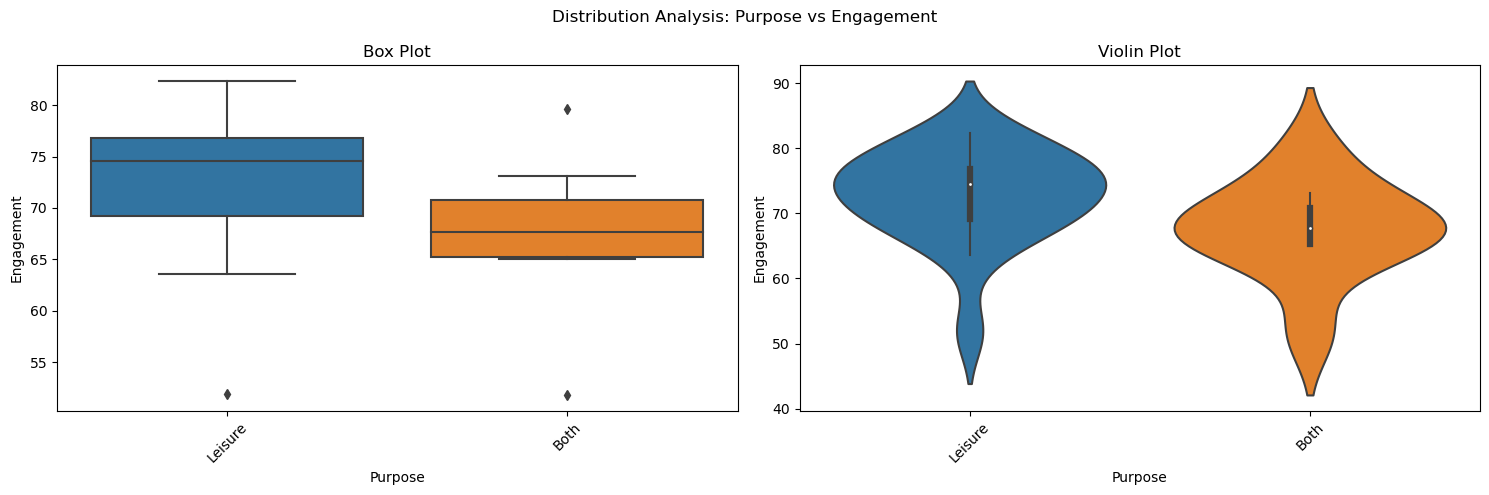

[9, 19]
[9, 19]
[9, 19]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]

Kruskal-Wallis Analysis Results:
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Desire
H-statistic: 0.8299
P-value: 0.3623
Effect Size (η²H): -0.0468
Max Group Difference: 1.11
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs CognitiveLoad
H-statistic: 1.3241
P-value: 0.2499
Effect Size (η²H): -0.0270
Max Group Difference: 1.85
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Engagement
H-statistic: 0.6644
P-value: 0.4150
Effect Size (η²H): -0.0534
Max Group Dif

<Figure size 1000x600 with 0 Axes>

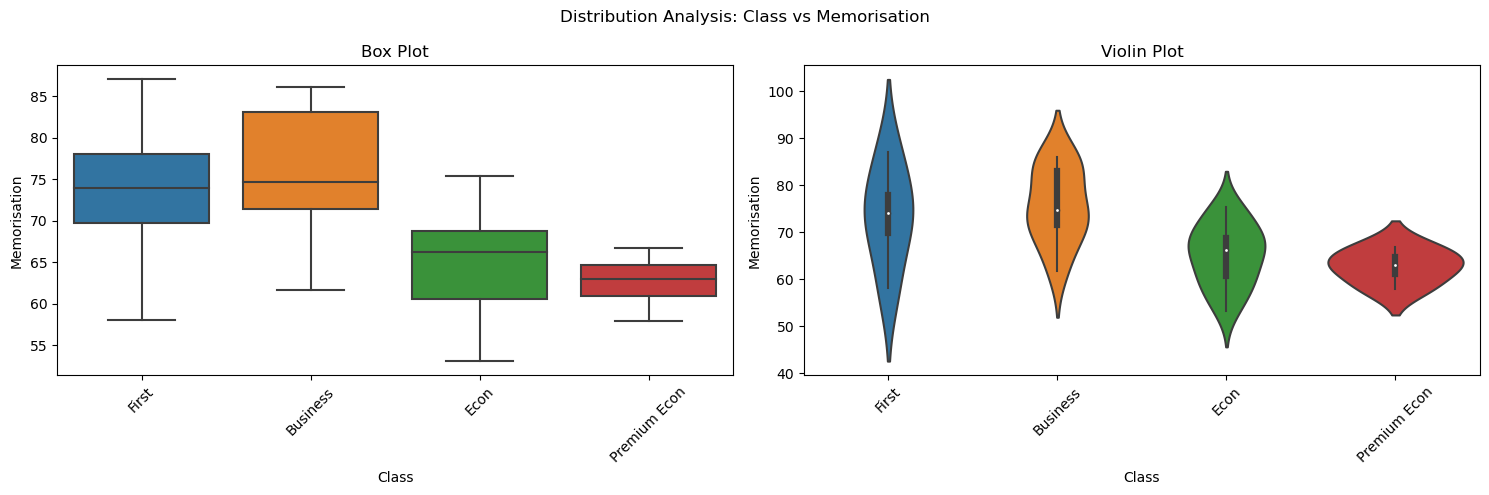

[11, 16, 5, 4]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[26, 2, 6, 2]
[26, 2, 6, 2]
[26, 2, 6, 2]


<Figure size 1000x600 with 0 Axes>

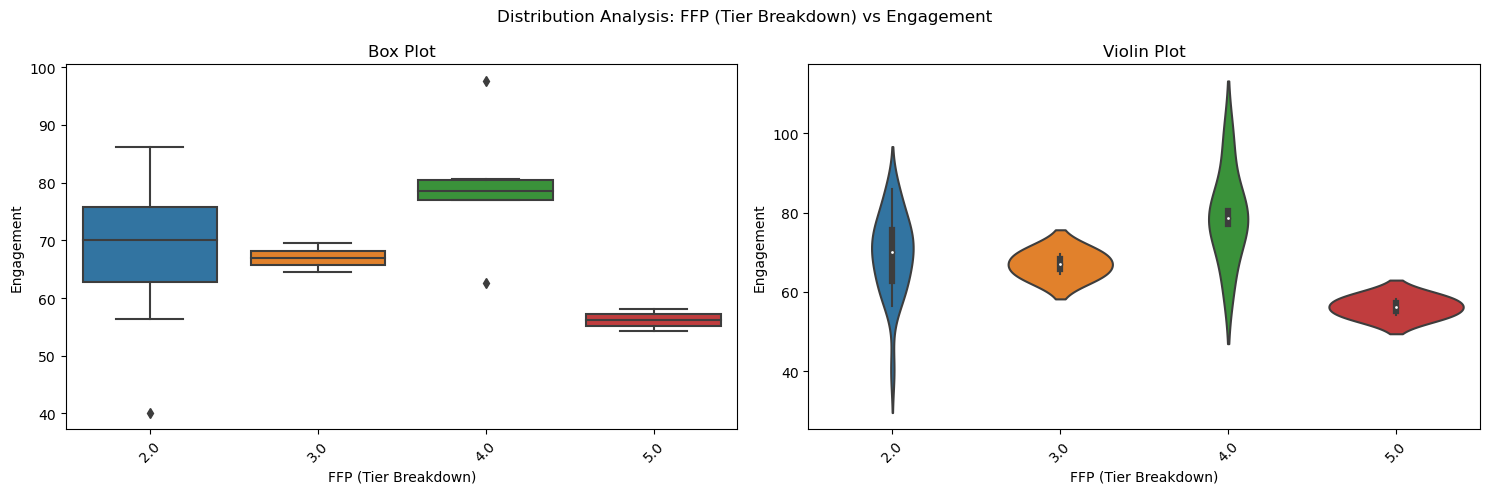

[26, 2, 6, 2]
[26, 2, 6, 2]
[26, 2, 6, 2]

Kruskal-Wallis Analysis Results:
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Desire
H-statistic: 1.4883
P-value: 0.2225
Effect Size (η²H): -0.0155
Max Group Difference: 1.04
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs CognitiveLoad
H-statistic: 0.0906
P-value: 0.7634
Effect Size (η²H): -0.0579
Max Group Difference: 2.90
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Engagement
H-statistic: 0.5545
P-value: 0.4565
Effect Size (η²H): -0.0438
Max Group Difference: 1.22
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Emotion
H-statistic: 0.7594
P-value:

<Figure size 1000x600 with 0 Axes>

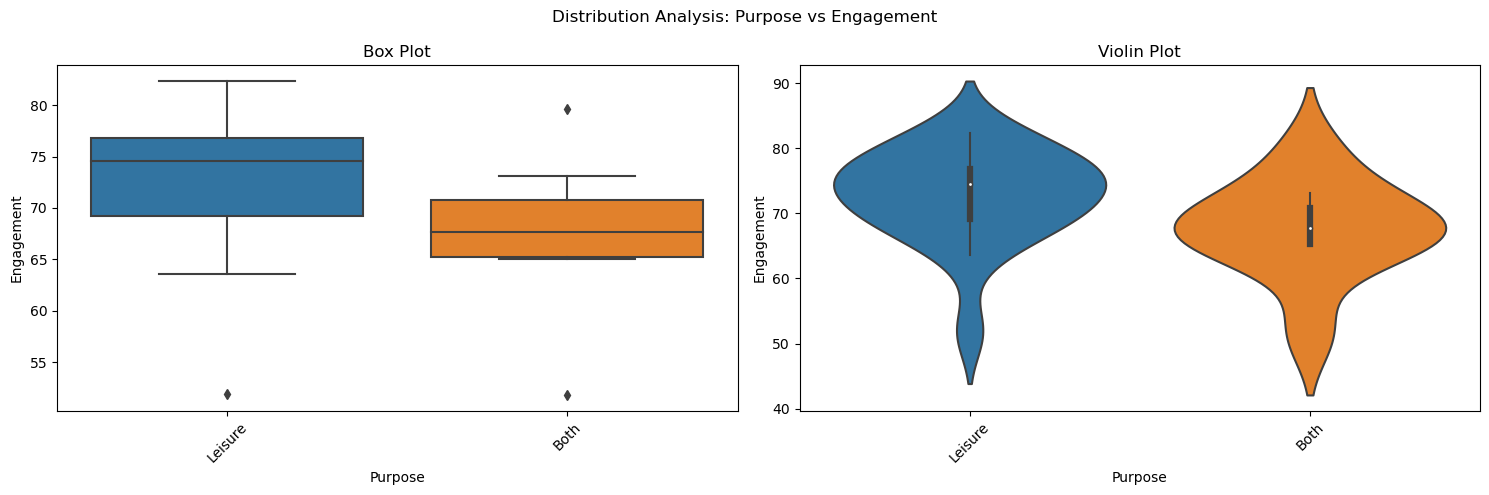

[9, 19]
[9, 19]
[9, 19]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]

Kruskal-Wallis Analysis Results:
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Desire
H-statistic: 0.8299
P-value: 0.3623
Effect Size (η²H): -0.0468
Max Group Difference: 1.11
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs CognitiveLoad
H-statistic: 1.3241
P-value: 0.2499
Effect Size (η²H): -0.0270
Max Group Difference: 1.85
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Engagement
H-statistic: 0.6644
P-value: 0.4150
Effect Size (η²H): -0.0534
Max Group Dif

<Figure size 1000x600 with 0 Axes>

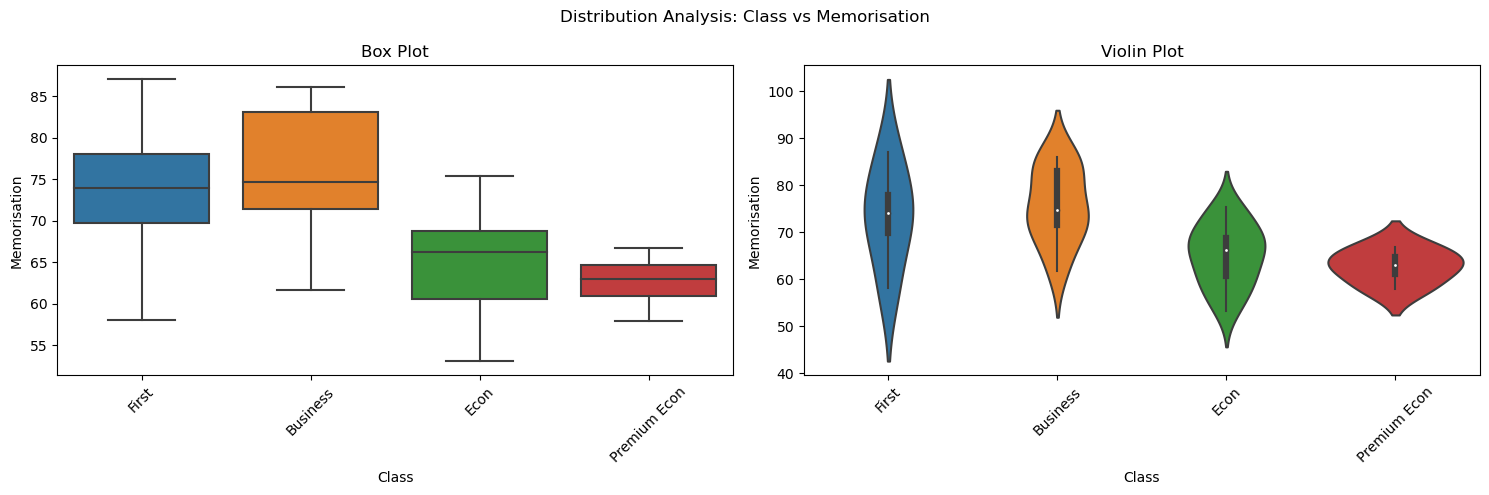

[11, 16, 5, 4]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[26, 2, 6, 2]
[26, 2, 6, 2]
[26, 2, 6, 2]


<Figure size 1000x600 with 0 Axes>

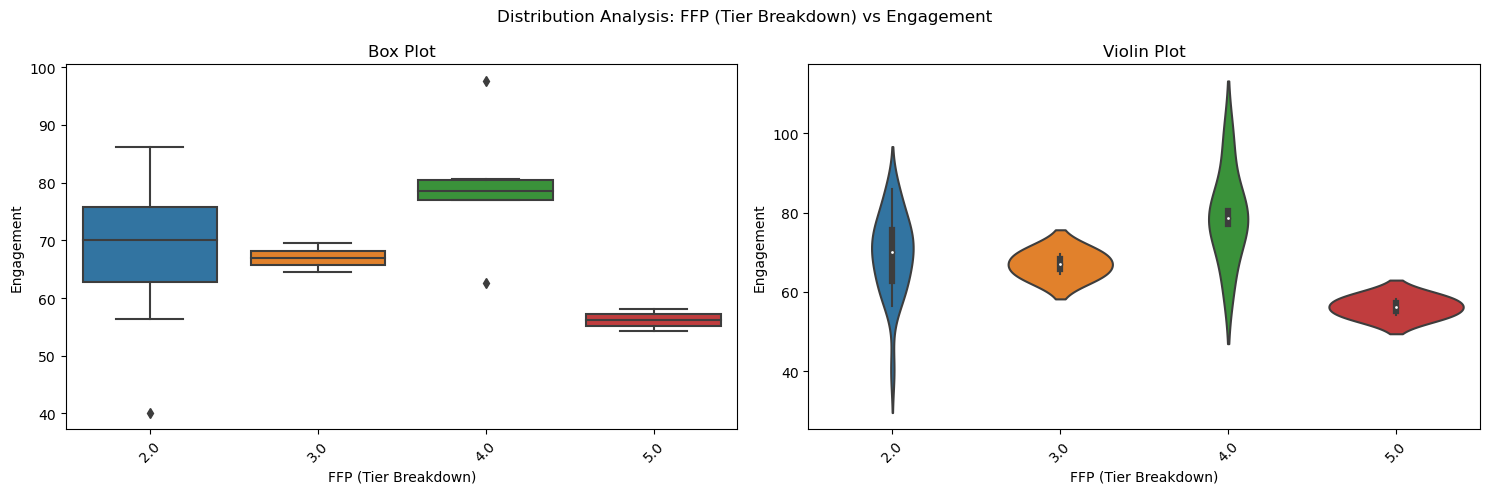

[26, 2, 6, 2]
[26, 2, 6, 2]
[26, 2, 6, 2]

Kruskal-Wallis Analysis Results:
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Desire
H-statistic: 1.4883
P-value: 0.2225
Effect Size (η²H): -0.0155
Max Group Difference: 1.04
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs CognitiveLoad
H-statistic: 0.0906
P-value: 0.7634
Effect Size (η²H): -0.0579
Max Group Difference: 2.90
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Engagement
H-statistic: 0.5545
P-value: 0.4565
Effect Size (η²H): -0.0438
Max Group Difference: 1.22
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Emotion
H-statistic: 0.7594
P-value:

<Figure size 1000x600 with 0 Axes>

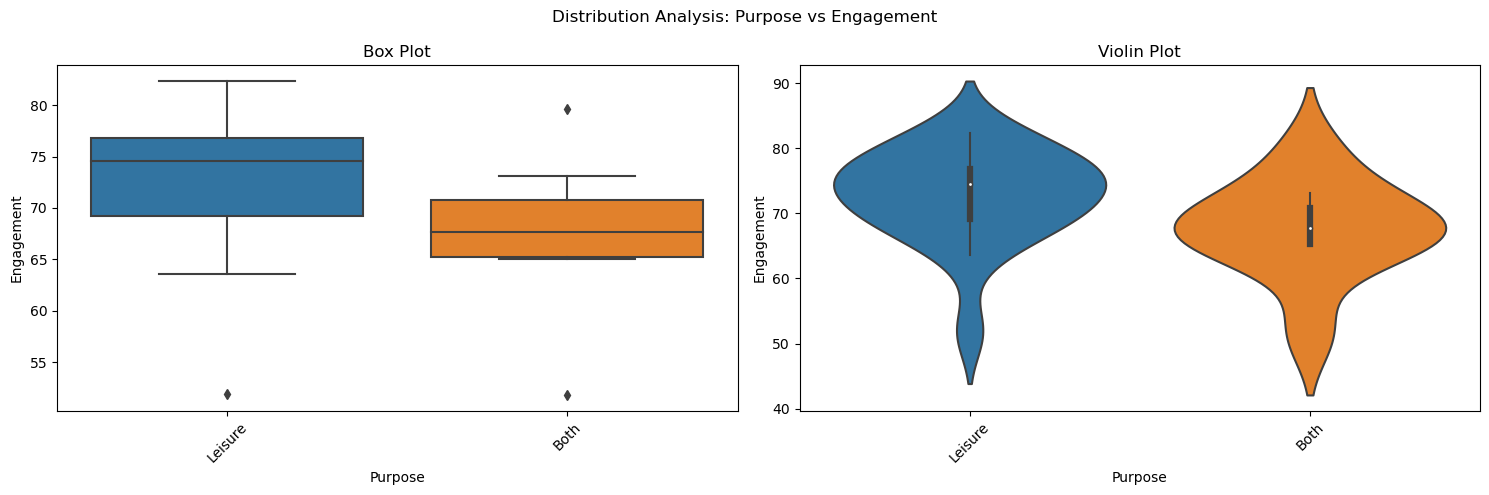

[9, 19]
[9, 19]
[9, 19]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[11, 5, 12]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 27]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]
[1, 17, 2, 5, 3]

Kruskal-Wallis Analysis Results:
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Desire
H-statistic: 0.8299
P-value: 0.3623
Effect Size (η²H): -0.0468
Max Group Difference: 1.11
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs CognitiveLoad
H-statistic: 1.3241
P-value: 0.2499
Effect Size (η²H): -0.0270
Max Group Difference: 1.85
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Engagement
H-statistic: 0.6644
P-value: 0.4150
Effect Size (η²H): -0.0534
Max Group Dif

<Figure size 1000x600 with 0 Axes>

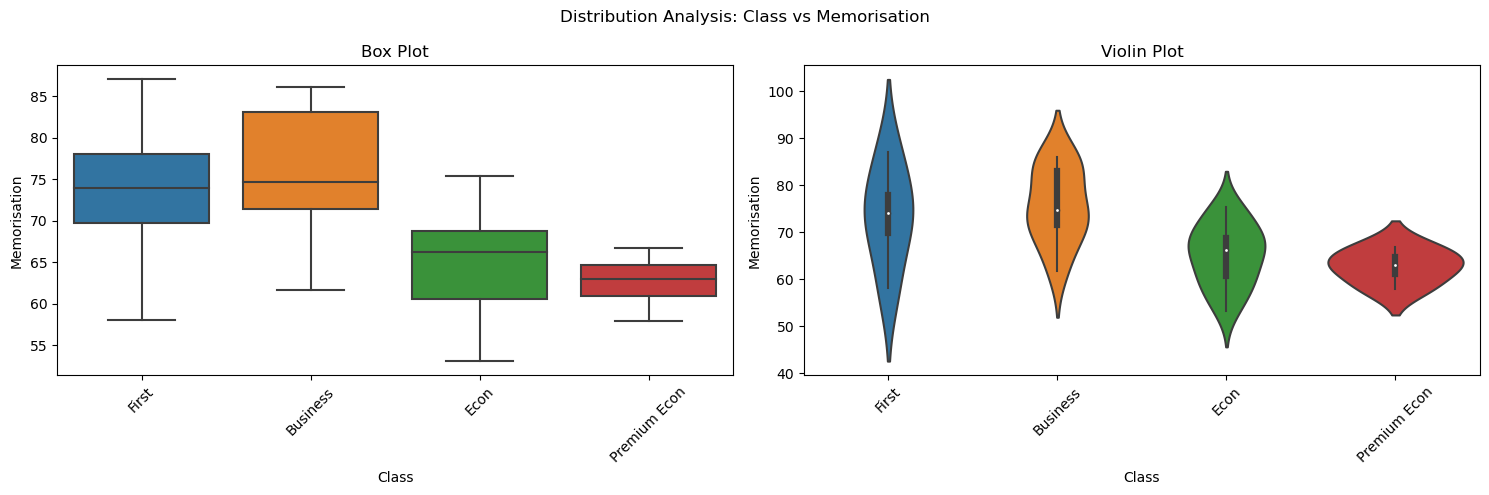

[11, 16, 5, 4]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[17, 1, 18]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[18, 1, 15, 1, 1]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[2, 34]
[26, 2, 6, 2]
[26, 2, 6, 2]
[26, 2, 6, 2]


<Figure size 1000x600 with 0 Axes>

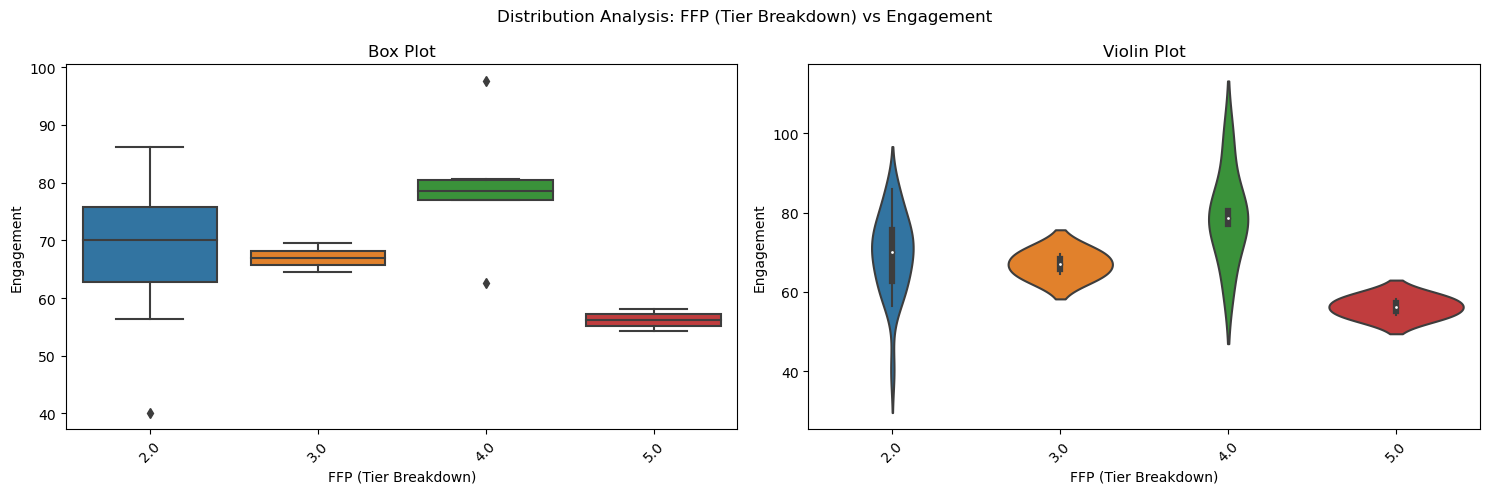

[26, 2, 6, 2]
[26, 2, 6, 2]
[26, 2, 6, 2]

Kruskal-Wallis Analysis Results:
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Desire
H-statistic: 1.4883
P-value: 0.2225
Effect Size (η²H): -0.0155
Max Group Difference: 1.04
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs CognitiveLoad
H-statistic: 0.0906
P-value: 0.7634
Effect Size (η²H): -0.0579
Max Group Difference: 2.90
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Engagement
H-statistic: 0.5545
P-value: 0.4565
Effect Size (η²H): -0.0438
Max Group Difference: 1.22
Statistically Significant: No
----------------------------------------------------------------------------------------------------

Comparison: Gender vs Emotion
H-statistic: 0.7594
P-value:

In [78]:
segments = resp_track_df[resp_track_df['CITY']==location]['Age Bracket'].unique()


        # Initialize empty list to store processed dataframes

        # Loop through each gender
#         if segmentation=='FFP (Tier Breakdown)':
#             valid_segments = [str(int(segment)) for segment in segments if pd.notna(segment)]
#         else:
valid_segments = [segment for segment in segments if pd.notna(segment)]

categorical_variables=['Gender', 'Occupation Group', 'Class', 'Purpose','Salary Group', 'Travelled P12M','FFP (Tier Breakdown)']
for cat in categorical_variables:
    for seg in valid_segments:
        try:
            print(seg)
            sample=merged_df[(merged_df['SourceStimuliName']=='CX_INP_002') & (merged_df['Age Bracket']==seg)]#CX_INP_002
            # Perform ANOVA analysis
            results = perform_kruskal_analysis(sample.copy(), categorical_variables, continuous_variables)


        # Print results
            print_kruskal_results(results)
        except:
            pass

In [63]:
pd.DataFrame(results).T

h_statistic   p_value effect_size  \
Age Bracket vs Desire                    8.544246  0.073557    0.155815   
Age Bracket vs CognitiveLoad              0.80862  0.937289   -0.028366   
Age Bracket vs Engagement                1.547807  0.818141   -0.010766   
Age Bracket vs Emotion                   2.476082  0.648924    0.011335   
Age Bracket vs Memorisation              6.298077  0.177966    0.102335   
Age Bracket vs Impact                     1.75798   0.78016   -0.005762   
Occupation Group vs Desire               4.559903  0.335503     0.06095   
Occupation Group vs CognitiveLoad        1.153301  0.885726   -0.020159   
Occupation Group vs Engagement           4.274289  0.370156     0.05415   
Occupation Group vs Emotion              6.839291  0.144629    0.115221   
Occupation Group vs Memorisation        12.086044  0.016723    0.240144   
Occupation Group vs Impact               4.728717  0.316282    0.064969   
Class vs Desire                          1.612411  0.656579   -0.009228   
Class vs CognitiveLoad                   3.883092  0.274368    0.044836   
Class vs Engagement                      2.396135  0.494354    0.009432   
Class vs Emotion                         1.663205  0.645145   -0.008019   
Class vs Memorisation                    2.682114  0.443275    0.016241   
Class vs Impact                          5.101438  0.164518    0.073844   
Purpose vs Desire                         1.70163  0.427067   -0.007104   
Purpose vs CognitiveLoad                  1.02965  0.597605   -0.023104   
Purpose vs Engagement                    5.630193  0.059899    0.086433   
Purpose vs Emotion                        0.16087  0.922715   -0.043789   
Purpose vs Memorisation                  0.025121  0.987518   -0.047021   
Purpose vs Impact                        1.784722  0.409687   -0.005126   
Salary Group vs Desire                   3.324997  0.344179    0.031548   
Salary Group vs CognitiveLoad            0.460676  0.927442   -0.036651   
Salary Group vs Engagement               6.230283  0.100928    0.100721   
Salary Group vs Emotion                  1.147219  0.765689   -0.020304   
Salary Group vs Memorisation             8.075431  0.044478    0.144653   
Salary Group vs Impact                   4.307315  0.230135    0.054936   
Travelled P12M vs Desire                 1.333992  0.248096   -0.015857   
Travelled P12M vs CognitiveLoad          1.920949  0.165752   -0.001882   
Travelled P12M vs Engagement             1.920949  0.165752   -0.001882   
Travelled P12M vs Emotion                0.480237  0.488315   -0.036185   
Travelled P12M vs Memorisation           0.379447    0.5379   -0.038585   
Travelled P12M vs Impact                 0.480237  0.488315   -0.036185   
FFP (Tier Breakdown) vs Desire           4.310809  0.365574    0.055019   
FFP (Tier Breakdown) vs CognitiveLoad    4.513672  0.340929    0.059849   
FFP (Tier Breakdown) vs Engagement       4.338045  0.362185    0.055668   
FFP (Tier Breakdown) vs Emotion          9.889619  0.042329    0.187848   
FFP (Tier Breakdown) vs Memorisation     9.389812  0.052061    0.175948   
FFP (Tier Breakdown) vs Impact          12.821953  0.012179    0.257666   

                                      max_difference significant  \
Age Bracket vs Desire                      21.679385       False   
Age Bracket vs CognitiveLoad                4.423266       False   
Age Bracket vs Engagement                    9.51411       False   
Age Bracket vs Emotion                     10.135756       False   
Age Bracket vs Memorisation                15.393102       False   
Age Bracket vs Impact                       5.753725       False   
Occupation Group vs Desire                 19.201639       False   
Occupation Group vs CognitiveLoad            4.91733       False   
Occupation Group vs Engagement              5.861648       False   
Occupation Group vs Emotion                11.061746       False   
Occupation Group vs Memorisation           11.979418        True

In [7]:
def format_results_table(results_df):
    """
    Format the results DataFrame for better display
    """
    # Style the DataFrame
    styled_df = results_df.style

    # Add color highlighting for significant results
    styled_df = styled_df.apply(lambda x: ['background-color: lightgreen' if x['Significant'] == 'Yes' 
                                         else 'background-color: lightcoral' for i in x], axis=1)

    # Format numeric columns
    styled_df = styled_df.format({
        'F-statistic': '{:.4f}',
        'p-value': '{:.4f}',
        'Effect Size (η²)': '{:.4f}',
        'Max Group Difference': '{:.2f}'
    })

    return styled_df
def perform_anova_analysis(dataframe, categorical_vars, continuous_vars):
    """
    Perform one-way ANOVA analysis for all combinations of categorical and continuous variables.

    Parameters:
    dataframe: pandas DataFrame containing the data
    categorical_vars: list of categorical variable names
    continuous_vars: list of continuous variable names

    Returns:
    Dictionary containing ANOVA results
    """
    results = {}

    for cat_var in categorical_vars:
        for cont_var in continuous_vars:
            # Create groups based on categorical variable
            groups = [group[cont_var].values for name, group in dataframe.groupby(cat_var)]

            # Perform one-way ANOVA
            f_statistic, p_value = stats.f_oneway(*groups)

            # Store results
            results[f"{cat_var} vs {cont_var}"] = {
                'f_statistic': f_statistic,
                'p_value': p_value,
                'significant': p_value < 0.05
            }

            # Create box plot
            if results[f"{cat_var} vs {cont_var}"]['significant']==True:
                plt.figure(figsize=(8, 4))
                sns.boxplot(x=cat_var, y=cont_var, data=dataframe)
                plt.xticks(rotation=45)
                plt.title(f'Box Plot: {cat_var} vs {cont_var}')
                plt.tight_layout()
                plt.show()

    return results
def print_anova_results(results):
    """
    Print ANOVA results in a formatted manner.
    """
    print("\nANOVA Analysis Results:")
    print("-" * 80)
    for comparison, result in results.items():
        print(f"\nComparison: {comparison}")
        print(f"F-statistic: {result['f_statistic']:.4f}")
        print(f"P-value: {result['p_value']:.4f}")
        print(f"Statistically Significant: {'Yes' if result['significant'] else 'No'}")
        print("-" * 80)

In [6]:
columns_to_keep = [
    'SourceStimuliName', 'Respondent', 'CognitiveLoad',
    'Desire', 'Emotion', 'Engagement', 'Ch7_Alpha_power', 
    'Ch1_Alpha_power', 'Memorisation'
]
agg_df_A = pd.read_csv("./CX_SH_PRIZM_SC/aggregated_data_CX_SH_PRIZM_SC.csv")
#for segmentation in ['Age Bracket', 'Gender', 'Occupation Group', 'Class', 'Purpose','Salary Group', 'Travelled P12M','FFP (Tier Breakdown)','Class']:
    #segmentation='Age Bracket'#Age Bracket', 'Gender', 'Occupation Group', 'Class', 'Purpose','Salary Group', 'Travelled P12M','FFP (Tier Breakdown)','Class']
    # Define genders to process
location='SHA'
#segments = resp_track_df[resp_track_df['CITY']==location][segmentation].unique()


# Initialize empty list to store processed dataframes
processed_dfs = []

# Loop through each gender
# if segmentation=='FFP (Tier Breakdown)':
#     valid_segments = [str(int(segment)) for segment in segments if pd.notna(segment)]
# else:
#     valid_segments = [segment for segment in segments if pd.notna(segment)]
#for segment in valid_segments:


# Construct the file path
file_path = f"./CX_SH_PRIZM_SC/feature_extracted_data_CX_SH_PRIZM_SC.csv"

# Read and process the data
df = pd.read_csv(file_path)
df.dropna(inplace=True)
    # Select required columns
df = df[columns_to_keep]

    # Filter for specific stimulus
    #df = df[df['SourceStimuliName'] == 'CX_INP_002']

pattern = r'(?<=_)\w+'
df.Respondent = respondent_correction(df.Respondent,pattern)
pi_df=get_purchase_intent()



# Process the data
processed_df = process_data(df)
processed_df=processed_df.merge(pi_df,on=['SourceStimuliName','Respondent'])
updates=processed_df.groupby('SourceStimuliName')[['CognitiveLoad',
   'Desire', 'Emotion', 'Engagement','Memorisation', 'Impact','Purchase_Intent']].mean().reset_index()
#         mask = (df['SourceStimuliName'] == updates_dict['SourceStimuliName']) & \
#            (df['segmentation_option'] == segmentation_option)

# Update the specific columns
metrics = ['Engagement', 'Emotion', 'CognitiveLoad', 'Desire', 
          'Memorisation', 'Impact']

# Iterate through each row in the updates DataFrame
for _, update_row in updates.iterrows():
    # Create mask for matching the SourceStimuliName
    mask = (agg_df_A['SourceStimuliName'] == update_row['SourceStimuliName'])# & (agg_df['segmentation_type']==segmentation) & (agg_df['segmentation_option']==segment)

    # Update each metric column
    for metric in metrics:
        if metric in update_row.index:
            agg_df_A.loc[mask, metric] = update_row[metric]
# Add to list of processed dataframes
#processed_dfs.append(processed_df)

# Combine all processed dataframes
final_df = processed_df#pd.concat(processed_dfs)
final_df.drop_duplicates(inplace=True)
#df=final_df
#df['Respondent']=df['Respondent'].apply(lambda x : x[4:])
merged_df=pd.merge(final_df,resp_track_df,left_on='Respondent',right_on='Imotions ID ',how='inner')
# grouped_df = merged_df.groupby(['SourceStimuliName', segmentation])[['CognitiveLoad',
#    'Desire', 'Emotion', 'Engagement', 'Memorisation', 'Impact','Purchase_Intent']].mean()
# Define variable lists
categorical_variables = ['Age Bracket', 'Gender', 'Occupation Group', 'Class', 'Purpose','Salary Group', 'Travelled P12M','FFP (Tier Breakdown)','Class']#[segmentation,'Purchase_Intent']#['
continuous_variables = ['Desire', 'CognitiveLoad', 'Engagement', 'Emotion', 'Memorisation','Impact']


# sample=merged_df[merged_df['SourceStimuliName']=='CX_INP_002']#CX_INP_002
# # Perform ANOVA analysis
# results = perform_anova_analysis(sample.copy(), categorical_variables, continuous_variables)


# # Print results
# print_anova_results(results)

C:\Users\FutureProofInsights\AppData\Local\Temp\ipykernel_31828\1892023163.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna('None',inplace=True)


In [74]:
from scipy.stats import chi2_contingency
import numpy as np

In [7]:
columns_to_keep = [
    'SourceStimuliName', 'Respondent', 'CognitiveLoad',
    'Desire', 'Emotion', 'Engagement', 'Ch7_Alpha_power', 
    'Ch1_Alpha_power', 'Memorisation'
]
agg_df_A = pd.read_csv("./CX_SH_PRIZM_SC/aggregated_data_CX_SH_PRIZM_SC.csv")
#for segmentation in ['Age Bracket', 'Gender', 'Occupation Group', 'Class', 'Purpose','Salary Group', 'Travelled P12M','FFP (Tier Breakdown)','Class']:
    #segmentation='Age Bracket'#Age Bracket', 'Gender', 'Occupation Group', 'Class', 'Purpose','Salary Group', 'Travelled P12M','FFP (Tier Breakdown)','Class']
    # Define genders to process
location='SHA'
#segments = resp_track_df[resp_track_df['CITY']==location][segmentation].unique()


# Initialize empty list to store processed dataframes
processed_dfs = []

# Loop through each gender
# if segmentation=='FFP (Tier Breakdown)':
#     valid_segments = [str(int(segment)) for segment in segments if pd.notna(segment)]
# else:
#     valid_segments = [segment for segment in segments if pd.notna(segment)]
#for segment in valid_segments:


# Construct the file path
file_path = f"./CX_SH_PRIZM_SC/feature_extracted_data_CX_SH_PRIZM_SC.csv"

# Read and process the data
df = pd.read_csv(file_path)
df.dropna(inplace=True)
    # Select required columns
df = df[columns_to_keep]

    # Filter for specific stimulus
    #df = df[df['SourceStimuliName'] == 'CX_INP_002']

pattern = r'(?<=_)\w+'
df.Respondent = respondent_correction(df.Respondent,pattern)
pi_df=get_purchase_intent()



# Process the data
processed_df = process_data(df)
processed_df=processed_df.merge(pi_df,on=['SourceStimuliName','Respondent'])
updates=processed_df.groupby('SourceStimuliName')[['CognitiveLoad',
   'Desire', 'Emotion', 'Engagement','Memorisation', 'Impact','Purchase_Intent']].mean().reset_index()
#         mask = (df['SourceStimuliName'] == updates_dict['SourceStimuliName']) & \
#            (df['segmentation_option'] == segmentation_option)

# Update the specific columns
metrics = ['Engagement', 'Emotion', 'CognitiveLoad', 'Desire', 
          'Memorisation', 'Impact']

# Iterate through each row in the updates DataFrame
for _, update_row in updates.iterrows():
    # Create mask for matching the SourceStimuliName
    mask = (agg_df_A['SourceStimuliName'] == update_row['SourceStimuliName'])# & (agg_df['segmentation_type']==segmentation) & (agg_df['segmentation_option']==segment)

    # Update each metric column
    for metric in metrics:
        if metric in update_row.index:
            agg_df_A.loc[mask, metric] = update_row[metric]
# Add to list of processed dataframes
#processed_dfs.append(processed_df)

# Combine all processed dataframes
final_df = processed_df#pd.concat(processed_dfs)
final_df.drop_duplicates(inplace=True)
#df=final_df
#df['Respondent']=df['Respondent'].apply(lambda x : x[4:])
merged_df=pd.merge(final_df,resp_track_df,left_on='Respondent',right_on='Imotions ID ',how='inner')
# grouped_df = merged_df.groupby(['SourceStimuliName', segmentation])[['CognitiveLoad',
#    'Desire', 'Emotion', 'Engagement', 'Memorisation', 'Impact','Purchase_Intent']].mean()
# Define variable lists
categorical_variables = ['Age Bracket', 'Gender', 'Occupation Group', 'Class', 'Purpose','Salary Group', 'Travelled P12M','FFP (Tier Breakdown)','Class']#[segmentation,'Purchase_Intent']#['
continuous_variables = ['Desire', 'CognitiveLoad', 'Engagement', 'Emotion', 'Memorisation','Impact']


sample=merged_df[merged_df['SourceStimuliName']=='CX_INP_002']#CX_INP_002
# Perform ANOVA analysis
results = perform_kruskal_analysis(sample.copy(), categorical_variables, continuous_variables)


# Print results
print_kruskal_results(results)

C:\Users\FutureProofInsights\AppData\Local\Temp\ipykernel_31828\1892023163.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna('None',inplace=True)


[10, 28, 36, 5, 4]
[10, 28, 36, 5, 4]
[10, 28, 36, 5, 4]
[10, 28, 36, 5, 4]
[10, 28, 36, 5, 4]
[10, 28, 36, 5, 4]
[45, 38]
[45, 38]
[45, 38]
[45, 38]
[45, 38]
[45, 38]
[55, 17, 5, 1, 5]
[55, 17, 5, 1, 5]
[55, 17, 5, 1, 5]
[55, 17, 5, 1, 5]
[55, 17, 5, 1, 5]
[55, 17, 5, 1, 5]
[17, 35, 16, 15]
[17, 35, 16, 15]
[17, 35, 16, 15]
[17, 35, 16, 15]
[17, 35, 16, 15]
[17, 35, 16, 15]
[35, 1, 47]
[35, 1, 47]
[35, 1, 47]
[35, 1, 47]
[35, 1, 47]
[35, 1, 47]
[39, 7, 35, 1, 1]
[39, 7, 35, 1, 1]
[39, 7, 35, 1, 1]
[39, 7, 35, 1, 1]
[39, 7, 35, 1, 1]
[39, 7, 35, 1, 1]
[5, 78]
[5, 78]
[5, 78]
[5, 78]
[5, 78]
[5, 78]
[1, 56, 7, 13, 6]
[1, 56, 7, 13, 6]
[1, 56, 7, 13, 6]
[1, 56, 7, 13, 6]
[1, 56, 7, 13, 6]
[1, 56, 7, 13, 6]
[17, 35, 16, 15]
[17, 35, 16, 15]
[17, 35, 16, 15]
[17, 35, 16, 15]
[17, 35, 16, 15]
[17, 35, 16, 15]

Kruskal-Wallis Analysis Results:
----------------------------------------------------------------------------------------------------

Comparison: Age Bracket vs Desire
H-statistic: 3

0 55.727048351922406
1 62.267277064892866
2 63.36768663108741
3 66.71553550162949
4 67.54430205899864
5 68.56228016656634
6 70.64907862259788
7 73.7625608585883
8 74.86164619282411
9 82.77771613632292
10 87.01212280357898


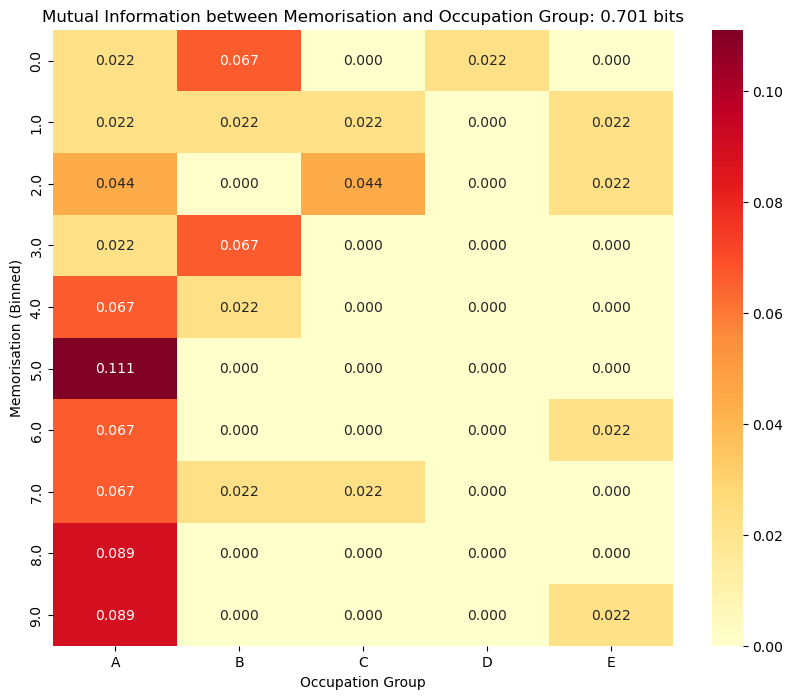

In [73]:
mi = plot_mi(sample, 'Memorisation', 'Occupation Group', n_bins=10)

In [8]:
#del agg_df_A['Unnamed: 0']

agg_df_A.to_csv("./CX_SH_PRIZM_SC/aggregated_data_CX_SH_PRIZM_SC.csv",index=False)
agg_df_A

Unnamed: 0 SourceStimuliName     Desire    Emotion  Memorisation  \
0           0        CX_INP_002  51.596666  49.108534     68.746639   
1           1        CX_INP_003  49.953459  46.328108     66.124149   
2           2        CX_INP_004  51.766837  49.004053     67.385934   

   CognitiveLoad  Engagement     Impact     synchrony  Purchase_Intent  \
0      39.934435   70.530368  62.690300  12031.783584        75.421687   
1      40.915261   68.072449  59.813397  12601.822664        72.289157   
2      40.414676   68.491602  61.287227  12677.997493        83.132530   

   Brand Stickiness  Unaided Recall  Preference  
0              4.97        6.976744    4.057471  
1               NaN        2.325581    3.872093  
2              9.13        2.325581    4.423529

In [30]:
merged_df.describe()

CognitiveLoad      Desire     Emotion  Engagement  Memorisation  \
count     185.000000  185.000000  185.000000  185.000000    185.000000   
mean       42.116293   51.507425   49.951651   69.786200     70.183853   
std        15.256717   10.148939   11.527401   10.826094      9.725244   
min         7.733076   26.393401   10.995536   43.663228     37.804378   
25%        32.502727   46.227266   42.426873   61.949956     64.026902   
50%        40.394658   51.033874   49.652833   69.861408     69.431735   
75%        50.031450   57.369300   56.123953   78.308587     77.170908   
max        91.494178   94.078097   76.852873   97.601603     90.183015   

           Impact  Purchase_Intent           #  FFP (Tier Breakdown)  
count  185.000000       185.000000  185.000000            185.000000  
mean    62.577540        62.934363   60.562162              2.621622  
std      6.164909        34.587739   20.134269              1.056845  
min     42.806803         0.000000    1.000000              1.000000  
25%     58.806746        42.857143   49.000000              2.000000  
50%     63.133061        71.428571   64.000000              2.000000  
75%     66.674528        85.714286   76.000000              3.000000  
max     77.166711       100.000000   86.000000              5.000000

In [31]:
for col in ['Age Bracket', 'Gender', 'Occupation Group','Salary Group','Purpose', 'Travelled P12M', 'Travel N12M','FFP (Tier Breakdown)','Class']:
    grouped_df = merged_df.groupby(['SourceStimuliName', f'{col}'])[['CognitiveLoad',
           'Desire', 'Emotion', 'Engagement', 'Memorisation', 'Impact'
]].mean()
    grouped_df.to_csv(f"agg_df_{col}.csv")

In [32]:
df = pd.read_csv(file_path)
df.dropna(inplace=True)



In [33]:
df[::100]

Unnamed: 0  LSL Timestamp    SourceStimuliName   Respondent  \
0                 0            0.0  Baseline30sFixCross  001_SHA_001   
100             100            0.2  Baseline30sFixCross  001_SHA_001   
200             200            0.4  Baseline30sFixCross  001_SHA_001   
300             300            0.6  Baseline30sFixCross  001_SHA_001   
400             400            0.8  Baseline30sFixCross  001_SHA_001   
...             ...            ...                  ...          ...   
4511709     4511709           39.2           CX_INP_008  065_SHB_022   
4511809     4511809           39.4           CX_INP_008  065_SHB_022   
4511909     4511909           39.6           CX_INP_008  065_SHB_022   
4512009     4512009           39.8           CX_INP_008  065_SHB_022   
4512109     4512109           40.0           CX_INP_008  065_SHB_022   

              Ch1       Ch2       Ch3       Ch4       Ch5       Ch6       Ch7  \
0         6854.08   5004.15 -46762.68 -25805.95 -45013.31 -68236.51  17561.13   
100       6682.76   4867.25 -47173.16 -25950.11 -45162.14 -68412.85  17414.25   
200       6532.58   4746.99 -47564.95 -26077.96 -45279.14 -68568.40  17283.48   
300       6384.70   4616.63 -47962.87 -26214.49 -45373.08 -68732.01  17138.60   
400       6260.22   4510.38 -48328.49 -26318.94 -45410.34 -68866.70  16997.72   
...           ...       ...       ...       ...       ...       ...       ...   
4511709 -23670.95 -23682.17 -23709.16 -23721.55 -23715.52 -23540.99   6185.39   
4511809 -23195.43 -23205.94 -23233.37 -23245.04 -23239.45 -23010.46   7404.16   
4511909 -22803.07 -22814.39 -22841.53 -22853.30 -22847.85 -22534.82   7752.72   
4512009 -22291.15 -22302.00 -22329.37 -22340.62 -22335.49 -21937.71   8378.44   
4512109 -21590.60 -21600.60 -21627.94 -21638.36 -21633.67 -21100.74  10672.97   

              Ch8  CognitiveLoad    Desire   Emotion  Engagement  \
0        12734.52       0.903671 -0.320758 -0.000024    0.949391   
100      12575.02       0.903671 -0.320758 -0.000024    0.949391   
200      12430.12       0.903972 -0.183171 -0.000021    0.949844   
300      12271.71       0.903328 -0.201056 -0.000018    0.950239   
400      12134.47       0.903328 -0.201056 -0.000018    0.950239   
...           ...            ...       ...       ...         ...   
4511709 -23671.18       0.913839 -9.226980  0.000033    0.953692   
4511809 -23195.35       0.919024 -8.984271  0.000019    0.956005   
4511909 -22804.12       0.919024 -8.984271  0.000019    0.956005   
4512009 -22291.85       0.917257 -9.611933  0.000040    0.960351   
4512109 -21590.59       0.917257 -9.611933  0.000040    0.960351   

         Ch7_Alpha_power  Ch1_Alpha_power  Memorisation  
0              70.897448        70.532931     -0.047123  
100            70.897448        70.532931     -0.047123  
200            70.740239        70.515947     -0.046214  
300            70.606620        70.355196     -0.045750  
400            70.606620        70.355196     -0.045750  
...                  ...              ...           ...  
4511709        88.202734        78.454974     -0.047741  
4511809        88.619000        79.259621     -0.045116  
4511909        88.619000        79.259621     -0.045116  
4512009        89.052225        79.490090     -0.038716  
4512109        89.052225        79.490090     -0.038716  

[44983 rows x 19 columns]

In [1]:
def process_data_ts(df):
    try:
        # Make a copy of the input DataFrame to avoid modifying the original
        df = df.copy()
        
        # Define columns to scale
        columns_to_scale = ['CognitiveLoad', 'Desire', 'Emotion', 'Engagement', 
                           'Ch7_Alpha_power', 'Ch1_Alpha_power', 'Memorisation']
        
        # First, handle missing values
        df.dropna(subset=columns_to_scale, inplace=True)
        
        # Initialize scaler
        scaler = MinMaxScaler(feature_range=(-1, 1))
        
        # Function to process each group
        def process_group(group_df,columns_to_scale):
            # Create a copy of the group data
            group_data = group_df[columns_to_scale].copy()
            
            # Scale the data
            scaled_data = scaler.fit_transform(group_data)
            
            # Create a new DataFrame with scaled values
            scaled_df = pd.DataFrame(scaled_data, 
                                   columns=columns_to_scale,
                                   index=group_df.index)
            
            return scaled_df
        
        # Group and process data
        grouped = df.groupby(['SourceStimuliName','Respondent'])#'Respondent'
        df['LSL Timestamp']=df['LSL Timestamp'].round(3)
        #try:
        df[columns_to_scale] = grouped[columns_to_scale].transform(lambda x: 2 * (x - x.min()) / (x.max() - x.min()) - 1)
        #except:
            
        # Combine all processed groups
        #df = pd.concat(processed_groups, axis=0)
        
        # Invert CognitiveLoad
        df['CognitiveLoad'] = -1 * df['CognitiveLoad']
        
        # Calculate Impact
        df['Impact'] = (df['Emotion'] * 0.25 + 
                       df['Memorisation'] * 0.25 + 
                       df['Ch7_Alpha_power'] * 0.25 + 
                       df['Ch1_Alpha_power'] * 0.25)
        # Group and process data
        #grouped = df.groupby(['SourceStimuliName','Respondent'])#
        
        # Create empty list to store processed groups
        df['Impact'] = grouped['Impact'].transform(lambda x: 2 * (x - x.min()) / (x.max() - x.min()) - 1)
            
        #df =  pd.concat(processed_groups, axis=0)
        
        # Transform scaled values to 0-100 range
        columns_to_transform = ['CognitiveLoad', 'Desire', 'Emotion', 
                              'Engagement', 'Memorisation', 'Impact']
        
#         for col in columns_to_transform:
#             df[col] = (df[col] + 1) * 50
        
        #Calculate final aggregations
        agg_columns = ['CognitiveLoad', 'Desire', 'Emotion', 
                      'Engagement', 'Memorisation', 'Impact']

        agg_df = (df.groupby(['SourceStimuliName', 'LSL Timestamp'])
                 [agg_columns]
                 .mean()
                 .reset_index())
        
        return agg_df#df[['SourceStimuliName', 'LSL Timestamp','Engagement', 'Emotion', 'CognitiveLoad', 'Desire', 
                  #'Memorisation', 'Impact']]
        
    except Exception as error:
        print("Error occurred while scaling:", error)
        raise  # Re-raise the exception for proper error handling

In [5]:

for segmentation in ['FFP (Tier Breakdown)']:#['Age Bracket', 'Gender', 'Occupation Group', 'Class', 'Purpose','Salary Group', 'Travelled P12M','FFP (Tier Breakdown)']:
    #segmentation='Age Bracket'#Age Bracket', 'Gender', 'Occupation Group', 'Class', 'Purpose','Salary Group', 'Travelled P12M','FFP (Tier Breakdown)','Class']
    # Define genders to process
    try:
        location='SHA'
        segments = resp_track_df[resp_track_df['CITY']==location][segmentation].unique()

        #    # Initialize empty list to store processed dataframes
        processed_dfs = []

        # Loop through each gender
        if segmentation=='FFP (Tier Breakdown)':
            valid_segments = [segment for segment in segments if pd.notna(segment)]
        else:
            valid_segments = [segment for segment in segments if pd.notna(segment)]
        for segment in valid_segments:
            print(segmentation,segment)
            #agg_df=pd.read_csv(f"./CX_SH_PRIZM_SC_{segmentation}_{segment}/time_series_data_CX_SH_PRIZM_SC_{segmentation}_{segment}.csv")
            # Construct the file path
            file_path = f"./CX_SH_PRIZM_SC_{segmentation}_{segment}_CX_INP_002/feature_extracted_data_CX_SH_PRIZM_SC_{segmentation}_{segment}.csv"

            # Read and process the data
            df = pd.read_csv(file_path)
            df.dropna(inplace=True)
            pattern = r'(?<=_)\w+'
            #df.Respondent = respondent_correction(df.Respondent,pattern)
            df_ts = process_data_ts(df)
            try :
                df_ts[['CognitiveLoad', 'Desire', 'Emotion', 'Engagement', 'Memorisation', 'Impact']] = df_ts.groupby('SourceStimuliName')[['CognitiveLoad', 'Desire', 'Emotion', 'Engagement', 'Memorisation', 'Impact']].transform(lambda x: 2 * (x - x.min()) / (x.max() - x.min()) - 1)
            except:
                pass
            # Update the specific columns
            metrics = ['Engagement', 'Emotion', 'CognitiveLoad', 'Desire', 
                      'Memorisation', 'Impact']
            df_ts[::100].to_csv(f"./CX_SH_PRIZM_SC_{segmentation}_{segment}_CX_INP_002/time_series_data_CX_SH_PRIZM_SC_{segmentation}_{segment}_2.0.csv",index=False)
    except Exception as E:
        print(E)
        pass
    

FFP (Tier Breakdown) 1.0
FFP (Tier Breakdown) 5.0
FFP (Tier Breakdown) 3.0
FFP (Tier Breakdown) 2.0
FFP (Tier Breakdown) 4.0


In [6]:
df_ts#groupby(['SourceStimuliName','LSL Timestamp'])['CognitiveLoad'].mean()

SourceStimuliName  LSL Timestamp  CognitiveLoad    Desire   Emotion  \
0            CX_INP_002          0.000      -0.041172  0.497170  0.248089   
1            CX_INP_002          0.002      -0.041172  0.497170  0.248089   
2            CX_INP_002          0.004      -0.041172  0.497170  0.248089   
3            CX_INP_002          0.006      -0.041172  0.497170  0.248089   
4            CX_INP_002          0.008      -0.041172  0.497170  0.248089   
...                 ...            ...            ...       ...       ...   
39647        CX_INP_002         79.294       0.020042  0.027485 -0.155998   
39648        CX_INP_002         79.296       0.020042  0.027485 -0.155998   
39649        CX_INP_002         79.298       0.020042  0.027485 -0.155998   
39650        CX_INP_002         79.300      -0.293296 -0.030551 -0.441901   
39651        CX_INP_002         79.302      -0.652137 -1.000000 -0.619691   

       Engagement  Memorisation    Impact  
0        0.522688      0.728067  0.632387  
1        0.522688      0.728067  0.632387  
2        0.522688      0.728067  0.632387  
3        0.522688      0.728067  0.632387  
4        0.522688      0.728067  0.632387  
...           ...           ...       ...  
39647    0.248507      0.137132  0.171265  
39648    0.248507      0.137132  0.171265  
39649    0.248507      0.137132  0.171265  
39650   -0.220348      0.039144 -0.033939  
39651    0.542529      0.839220  0.727417  

[39652 rows x 8 columns]

In [7]:
df_ts[df_ts['SourceStimuliName']=='CX_INP_002'].describe()

LSL Timestamp  CognitiveLoad        Desire       Emotion    Engagement  \
count   39652.000000   39652.000000  39652.000000  39652.000000  39652.000000   
mean       39.651000      -0.153463      0.306571      0.075319      0.286914   
std        22.893382       0.294925      0.296463      0.306436      0.324945   
min         0.000000      -1.000000     -1.000000     -1.000000     -1.000000   
25%        19.825500      -0.346512      0.129053     -0.091352      0.065799   
50%        39.651000      -0.169604      0.327296      0.099428      0.318041   
75%        59.476500       0.028489      0.513750      0.261941      0.545089   
max        79.302000       1.000000      1.000000      1.000000      1.000000   

       Memorisation        Impact  
count  39652.000000  39652.000000  
mean       0.034216      0.282489  
std        0.383149      0.336307  
min       -1.000000     -1.000000  
25%       -0.225003      0.095569  
50%        0.048466      0.307834  
75%        0.329031      0.535572  
max        1.000000      1.000000

In [8]:
sample=df_ts[df_ts['SourceStimuliName']=='CX_INP_002']

In [9]:
sample

SourceStimuliName  LSL Timestamp  CognitiveLoad    Desire   Emotion  \
0            CX_INP_002          0.000      -0.041172  0.497170  0.248089   
1            CX_INP_002          0.002      -0.041172  0.497170  0.248089   
2            CX_INP_002          0.004      -0.041172  0.497170  0.248089   
3            CX_INP_002          0.006      -0.041172  0.497170  0.248089   
4            CX_INP_002          0.008      -0.041172  0.497170  0.248089   
...                 ...            ...            ...       ...       ...   
39647        CX_INP_002         79.294       0.020042  0.027485 -0.155998   
39648        CX_INP_002         79.296       0.020042  0.027485 -0.155998   
39649        CX_INP_002         79.298       0.020042  0.027485 -0.155998   
39650        CX_INP_002         79.300      -0.293296 -0.030551 -0.441901   
39651        CX_INP_002         79.302      -0.652137 -1.000000 -0.619691   

       Engagement  Memorisation    Impact  
0        0.522688      0.728067  0.632387  
1        0.522688      0.728067  0.632387  
2        0.522688      0.728067  0.632387  
3        0.522688      0.728067  0.632387  
4        0.522688      0.728067  0.632387  
...           ...           ...       ...  
39647    0.248507      0.137132  0.171265  
39648    0.248507      0.137132  0.171265  
39649    0.248507      0.137132  0.171265  
39650   -0.220348      0.039144 -0.033939  
39651    0.542529      0.839220  0.727417  

[39652 rows x 8 columns]

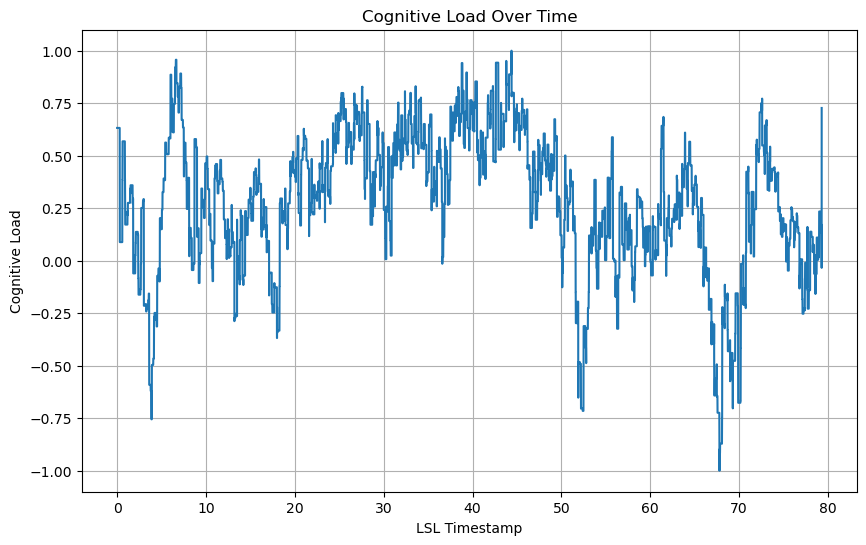

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(sample['LSL Timestamp'], sample['Impact'])
plt.xlabel('LSL Timestamp')
plt.ylabel('Cognitive Load')
plt.title('Cognitive Load Over Time')
plt.grid(True)
plt.show()

In [43]:
def process_data_ts(df):
    try:
        # Make a copy of the input DataFrame to avoid modifying the original
        df = df.copy()
        
        # Define columns to scale
        columns_to_scale = ['CognitiveLoad', 'Desire', 'Emotion', 'Engagement', 
                           'Ch7_Alpha_power', 'Ch1_Alpha_power', 'Memorisation']
        
        # First, handle missing values
        df.dropna(subset=columns_to_scale, inplace=True)
    
        # Group and process data
        grouped = df.groupby(['SourceStimuliName','Respondent'])#'Respondent'
        df['LSL Timestamp']=df['LSL Timestamp'].round(3)
        df[columns_to_scale] = grouped[columns_to_scale].transform(lambda x: 2 * (x - x.min()) / (x.max() - x.min()) - 1)
        # Combine all processed groups
        #df = pd.concat(processed_groups, axis=0)
        
        # Invert CognitiveLoad
        df['CognitiveLoad'] = -1 * df['CognitiveLoad']
        
        # Calculate Impact
        df['Impact'] = (df['Emotion'] * 0.25 + 
                       df['Memorisation'] * 0.25 + 
                       df['Ch7_Alpha_power'] * 0.25 + 
                       df['Ch1_Alpha_power'] * 0.25)
        # Group and process data
        grouped = df.groupby(['SourceStimuliName','Respondent'])#
        
        # Create empty list to store processed groups
        df['Impact'] = grouped['Impact'].transform(lambda x: 2 * (x - x.min()) / (x.max() - x.min()) - 1)
            
        
        #Calculate final aggregations
        agg_columns = ['CognitiveLoad', 'Desire', 'Emotion', 
                      'Engagement', 'Memorisation', 'Impact']

        agg_df = (df.groupby(['SourceStimuliName', 'LSL Timestamp'])
                 [agg_columns]
                 .median()
                 .reset_index())
        
        return agg_df#df[['SourceStimuliName', 'LSL Timestamp','Engagement', 'Emotion', 'CognitiveLoad', 'Desire', 
                  #'Memorisation', 'Impact']]
        
    except Exception as error:
        print("Error occurred while scaling:", error)
        raise  # Re-raise the exception for proper error handling

In [44]:
agg_df=pd.read_csv(f"./CX_SH_PRIZM_SC/time_series_data_CX_SH_PRIZM_SC.csv")
# Construct the file path
file_path = f"./CX_SH_PRIZM_SC/feature_extracted_data_CX_SH_PRIZM_SC.csv"

# Read and process the data
df = pd.read_csv(file_path)
df.dropna(inplace=True)
pattern = r'(?<=_)\w+'
#df.Respondent = respondent_correction(df.Respondent,pattern)
df_ts = process_data_ts(df)
df_ts[['CognitiveLoad', 'Desire', 'Emotion', 'Engagement', 'Memorisation', 'Impact']] = df_ts.groupby('SourceStimuliName')[['CognitiveLoad', 'Desire', 'Emotion', 'Engagement', 'Memorisation', 'Impact']].transform(lambda x: 2 * (x - x.min()) / (x.max() - x.min()) - 1)

# Update the specific columns
metrics = ['Engagement', 'Emotion', 'CognitiveLoad', 'Desire', 'Memorisation', 'Impact']
df_ts[::100].to_csv(f"./CX_SH_PRIZM_SC/time_series_data_CX_SH_PRIZM_SC_2.0.csv",index=False)

In [45]:
sample=df_ts[df_ts['SourceStimuliName']=='CX_INP_002']

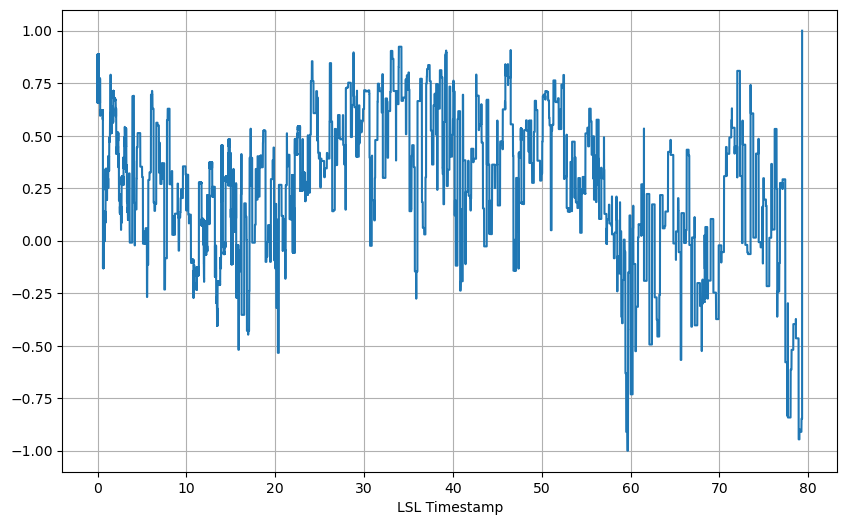

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(sample['LSL Timestamp'], sample['Memorisation'])
plt.xlabel('LSL Timestamp')

plt.grid(True)
plt.show()

In [47]:
df_ts[df_ts['SourceStimuliName']=='CX_INP_002'].describe()

LSL Timestamp  CognitiveLoad        Desire       Emotion    Engagement  \
count   39651.000000   39651.000000  39651.000000  39651.000000  39651.000000   
mean       39.650000       0.165594      0.029846     -0.283203      0.041510   
std        22.892804       0.260692      0.343342      0.212702      0.254973   
min         0.000000      -1.000000     -1.000000     -1.000000     -1.000000   
25%        19.825000       0.001435     -0.202527     -0.425472     -0.107277   
50%        39.650000       0.176990      0.025129     -0.296420      0.068498   
75%        59.475000       0.331816      0.265210     -0.163137      0.230716   
max        79.300000       1.000000      1.000000      1.000000      1.000000   

       Memorisation        Impact  
count  39651.000000  39651.000000  
mean       0.250777      0.226542  
std        0.350343      0.379901  
min       -1.000000     -1.000000  
25%        0.030090     -0.014039  
50%        0.289442      0.269934  
75%        0.512634      0.510884  
max        1.000000      1.000000

In [62]:
file_path = f"./agg_df_{segmentation}.csv"

# Read and process the data
df = pd.read_csv(file_path)
df.dropna(inplace=True)
# Select required columns
df = df[columns_to_keep]

In [66]:
processed_df[processed_df['SourceStimuliName']=='CX_INP_002'].groupby(['SourceStimuliName'])[['CognitiveLoad',
       'Desire', 'Emotion', 'Engagement','Memorisation', 'Impact']].mean().reset_index()

SourceStimuliName  CognitiveLoad     Desire   Emotion  Engagement  \
0        CX_INP_002      72.702945  48.804912  46.17429   25.587874   

   Memorisation     Impact  
0     70.458429  40.440922

In [270]:
updates=processed_df.groupby('SourceStimuliName')[['CognitiveLoad',
   'Desire', 'Emotion', 'Engagement','Memorisation', 'Impact','Purchase_Intent']].mean().reset_index()
updates

SourceStimuliName  CognitiveLoad     Desire    Emotion  \
0                Baseline30sFixCross      39.839567  49.719993  48.071284   
1   CAT_Product_Lighting_06s_16x9_SC      44.150507  49.747938  50.613504   
2                         CX_INP_002      40.821891  50.672970  49.172732   
3                         CX_INP_003      41.768047  50.408275  49.330389   
4                         CX_INP_004      40.381401  49.704589  49.487982   
5                         CX_INP_005      39.418856  48.772138  49.954579   
6                         CX_INP_006      43.841454  50.278253  49.966550   
7                         CX_INP_007      42.253748  49.650231  49.806986   
8                         CX_INP_008      41.386286  50.578045  49.540898   
9                         CX_INP_013      45.749933  47.872109  48.206030   
10                        CX_INP_014      43.669549  49.503874  49.882775   
11                        CX_INP_015      48.944348  49.422306  50.155938   
12                        CX_INP_016      41.765925  49.951019  47.901901   

    Engagement  Memorisation     Impact  Purchase_Intent  
0    68.190303     64.522506  61.684449         0.000000  
1    62.082185     59.152690  58.201192         0.000000  
2    69.524232     66.224204  63.622356        81.802721  
3    67.051404     63.882152  62.087100        75.087108  
4    69.267580     66.791750  63.586010        85.204082  
5    69.663973     66.187412  63.730259        70.408163  
6    69.180243     65.731051  62.998683        67.687075  
7    67.758811     65.467590  63.528060        68.537415  
8    67.115482     66.441124  63.137130        79.591837  
9    60.240674     57.860284  56.605859         0.000000  
10   58.894359     58.503012  58.073750         0.000000  
11   59.331194     61.035300  58.021665         0.000000  
12   60.842948     62.102776  58.586982         0.000000

In [266]:
agg_df.to_csv("./China A/aggregated_data_China A_1.0.csv",index=False)

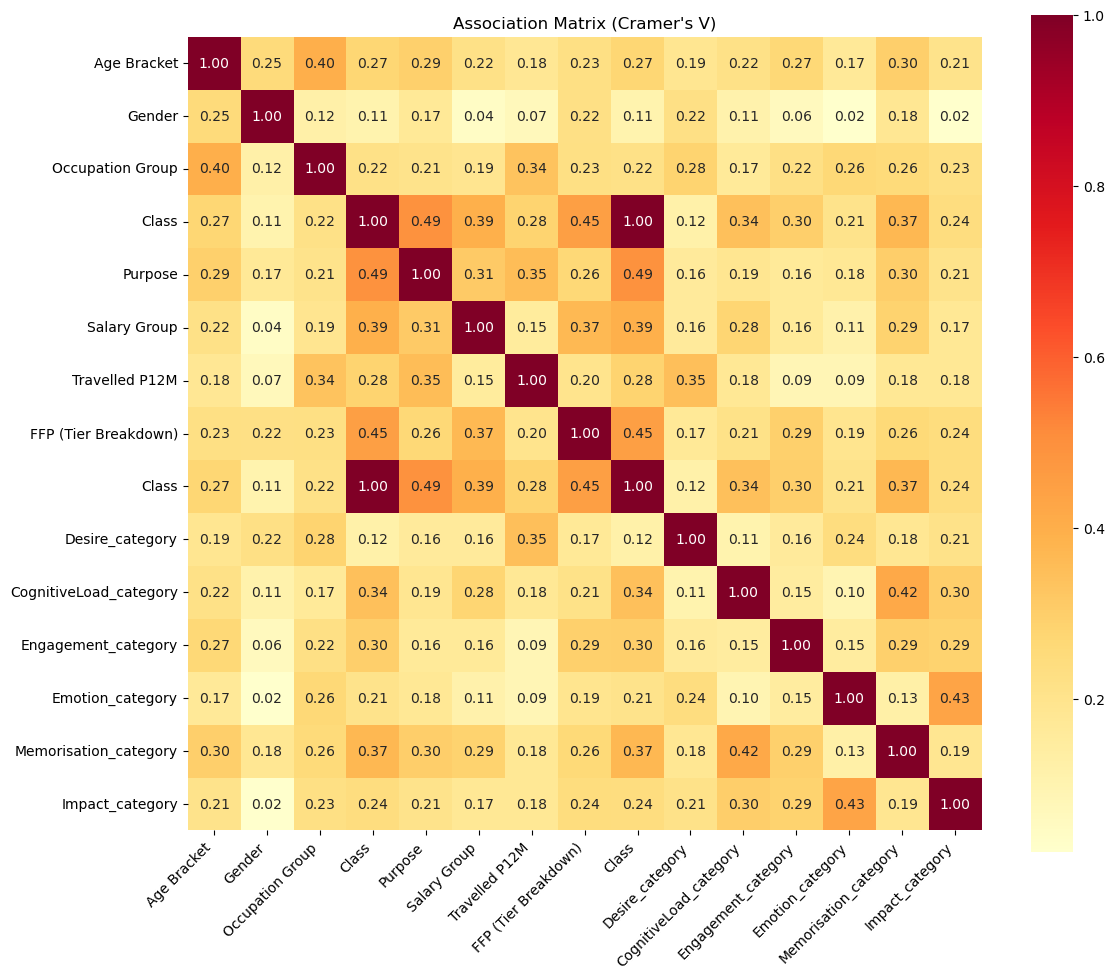

In [82]:
correlation_df = pd.DataFrame(correlation_matrix)
for column in correlation_df.columns:
        try:
            correlation_df[column] = correlation_df[column].astype(float)
        except:
            print(f"Could not convert column {column} to float")    
    # Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df, 
            annot=True, 
            cmap='YlOrRd', 
            fmt='.2f',
            square=True)
plt.title("Association Matrix (Cramer's V)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
correlation_df.info()

In [ ]:

# Create profile for each original category
print("\nCategory Profiles:")
for cat_var in categorical_variables:
    print(f"\n{cat_var} Profile:")
    print("-" * 50)
    
    profile_data = {}
    for cont_var in categorized_vars:
        cross_tab = pd.crosstab(sample[cat_var], sample[cont_var], normalize='index') * 100
        dominant_categories = cross_tab.idxmax(axis=1)
        profile_data[cont_var] = dominant_categories
    
    profile_df = pd.DataFrame(profile_data)
    print(profile_df)
    
    # Save profile to CSV
    profile_df.to_csv(f'Cathay_002_{cat_var}_profile.csv')


In [ ]:
###CX_INP_003

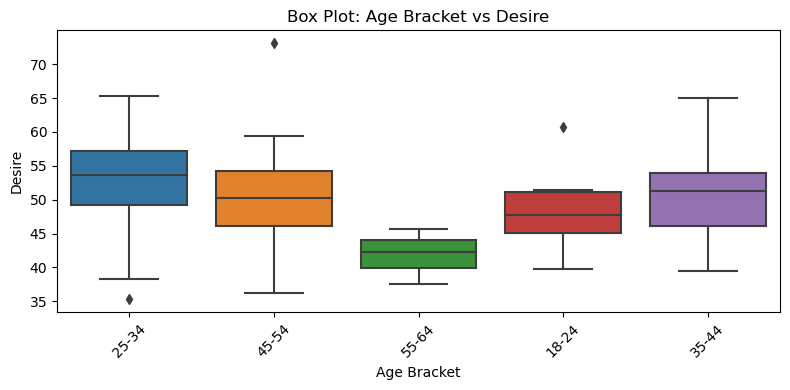

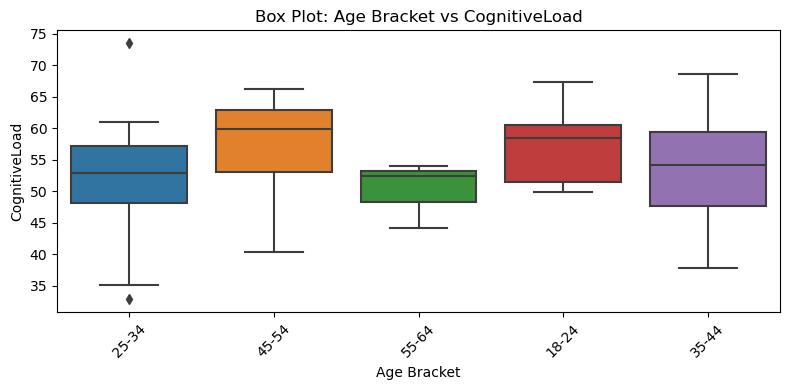

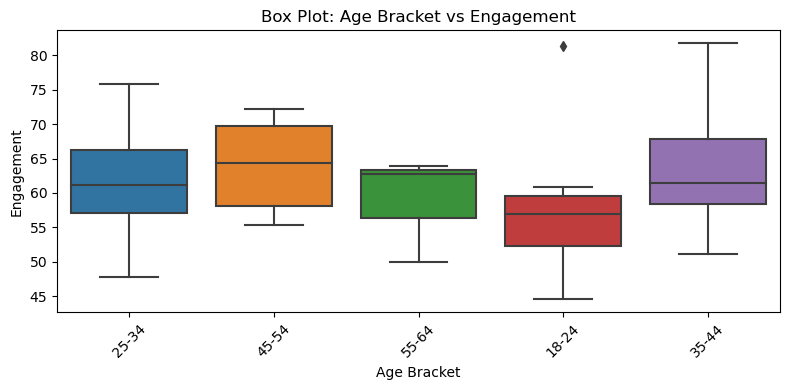

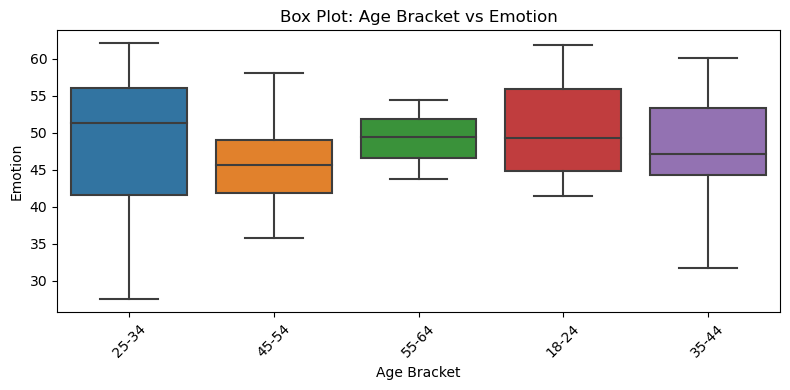

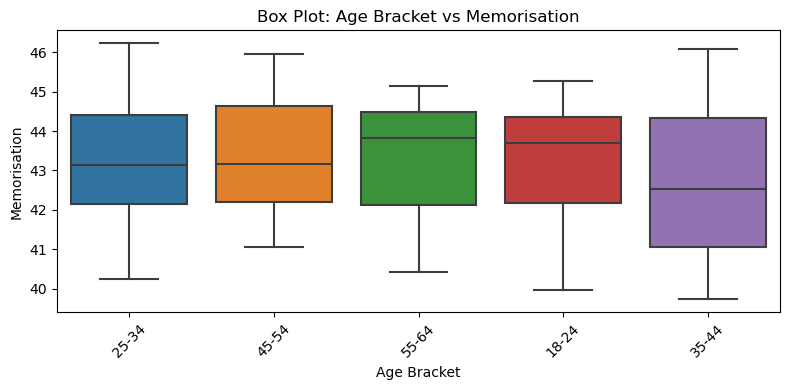

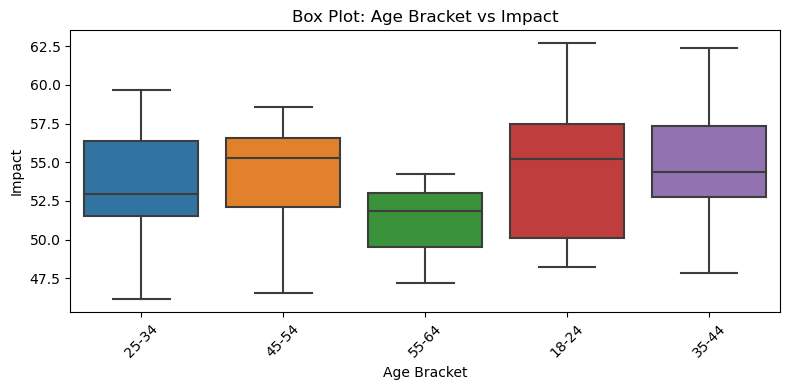

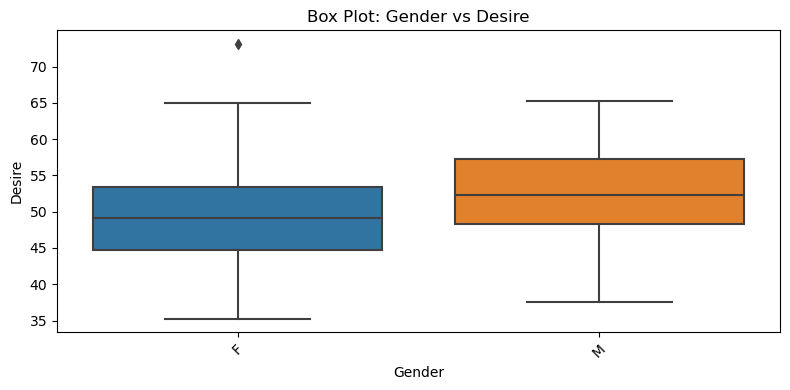

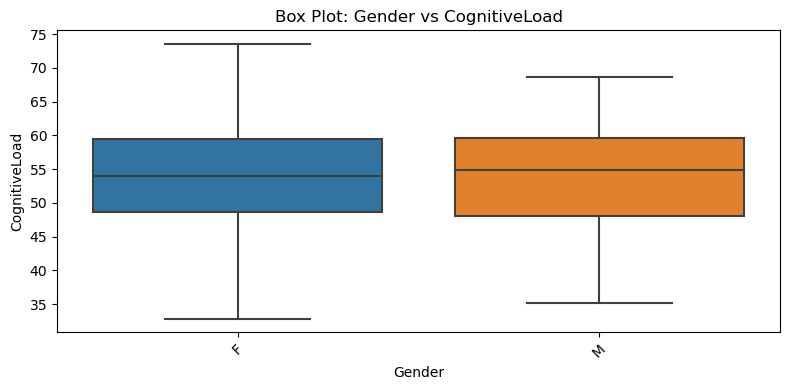

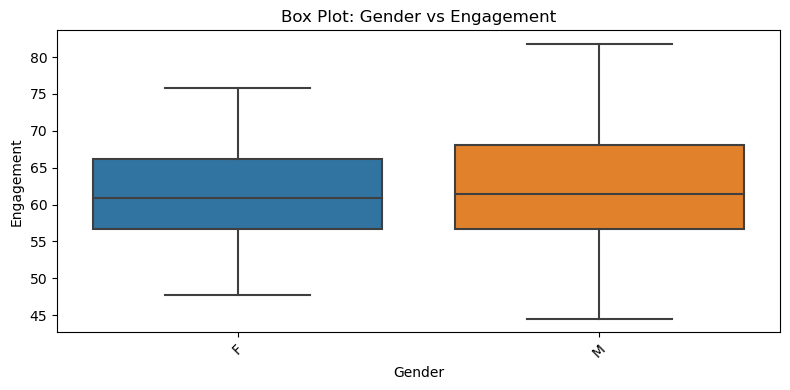

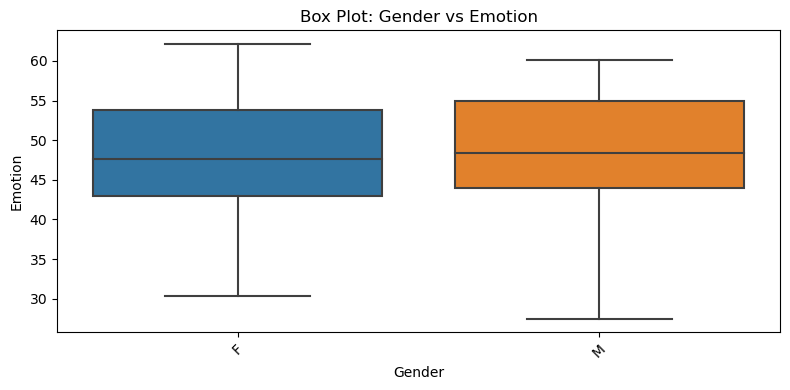

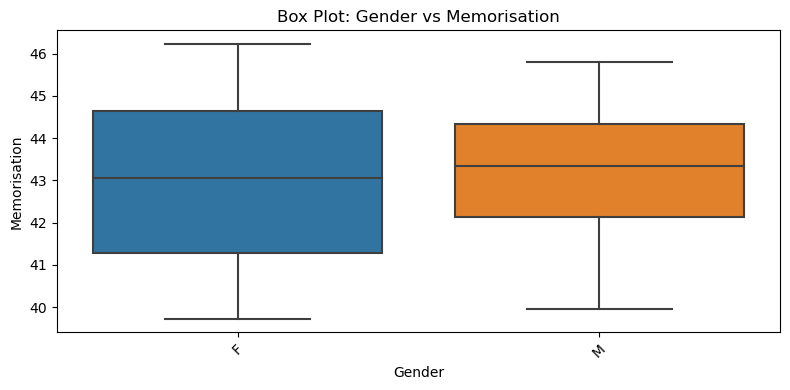

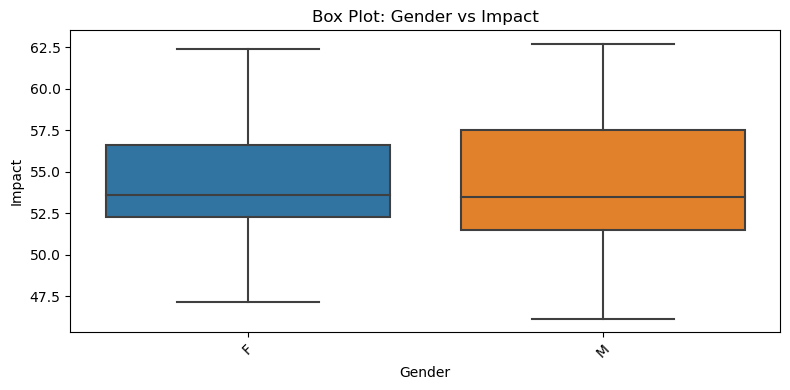

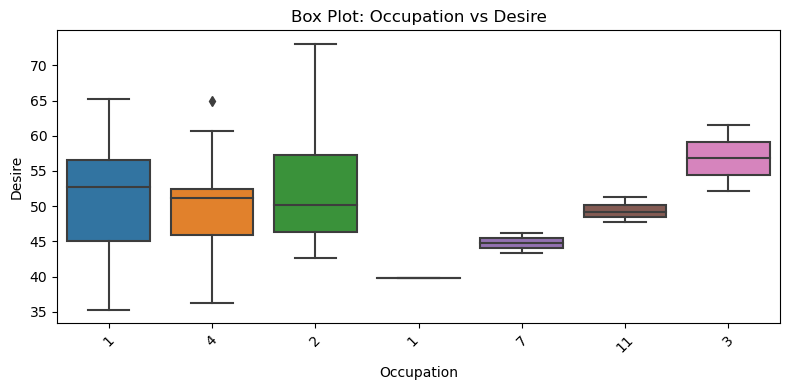

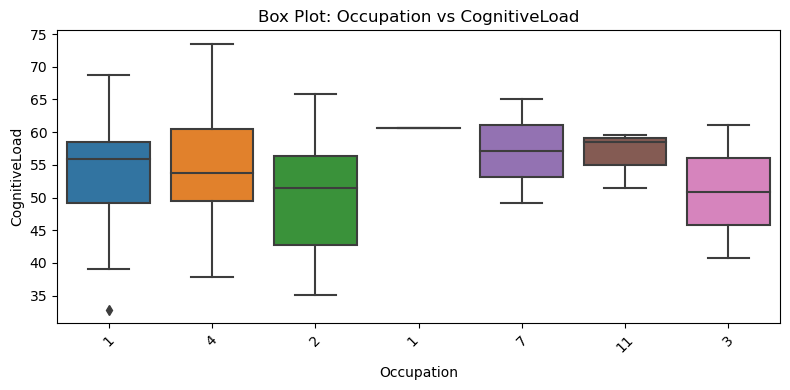

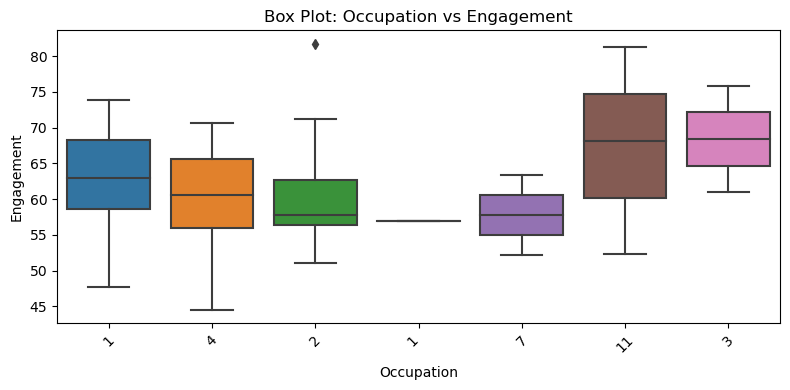

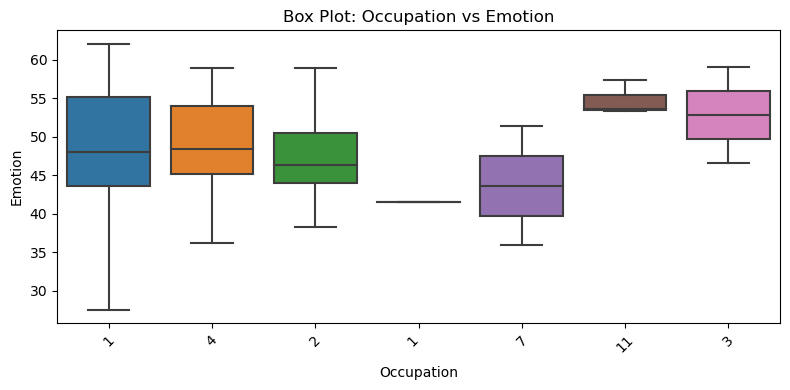

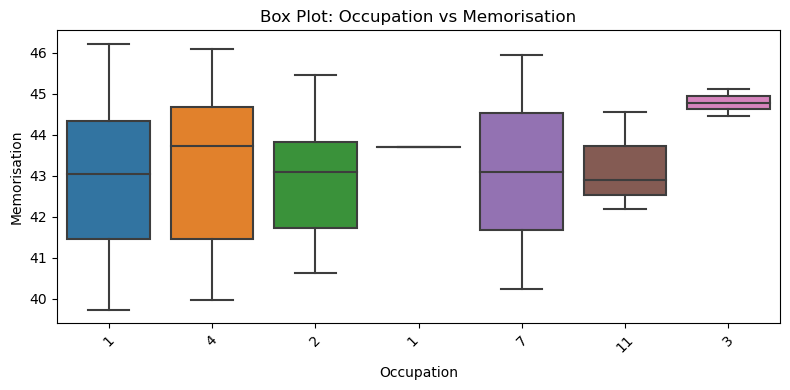

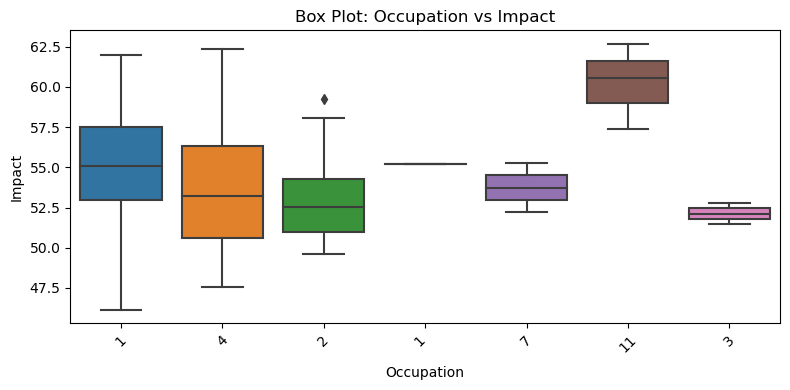

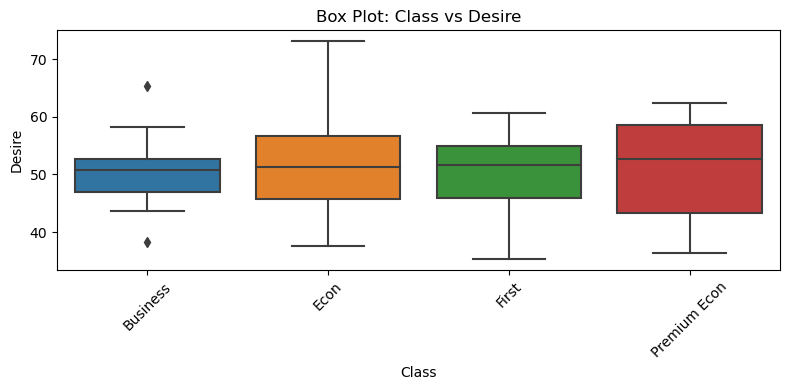

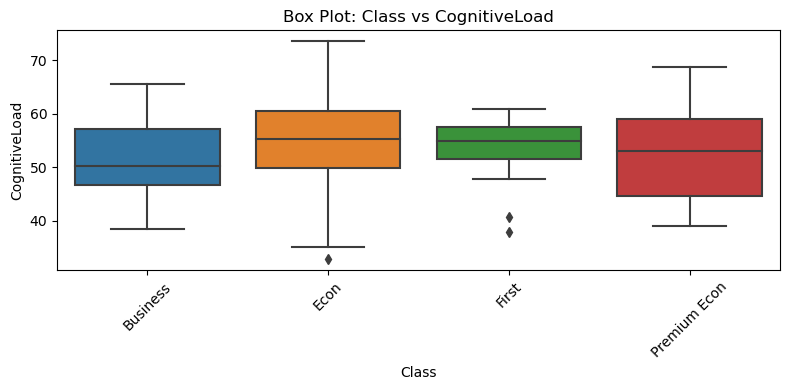

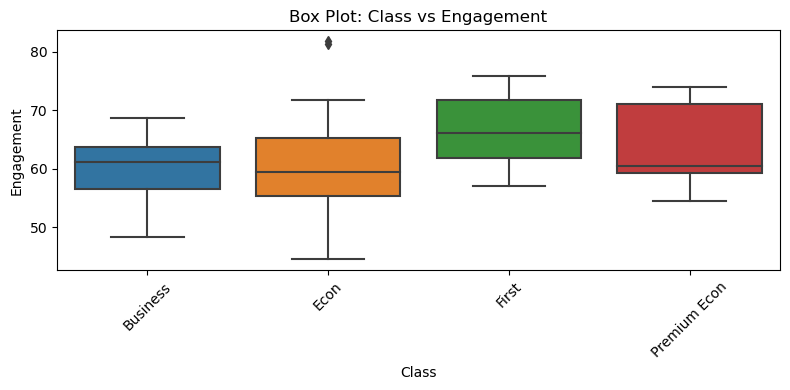

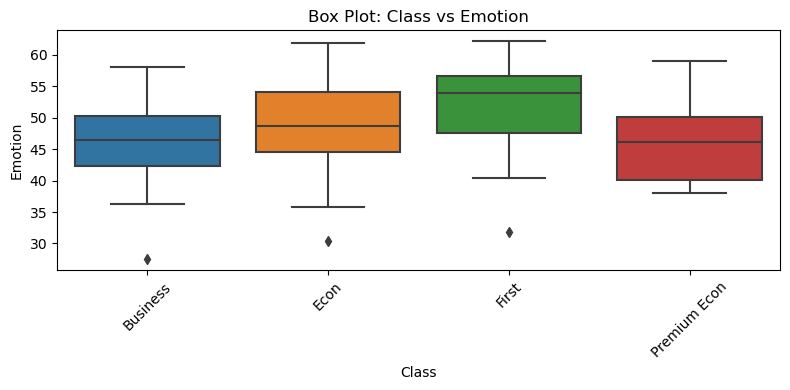

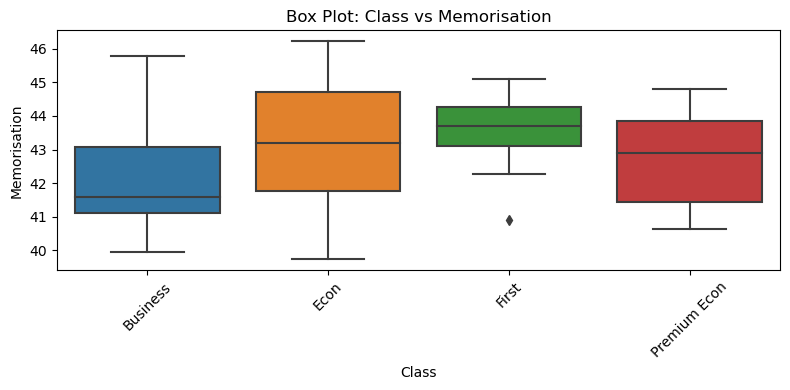

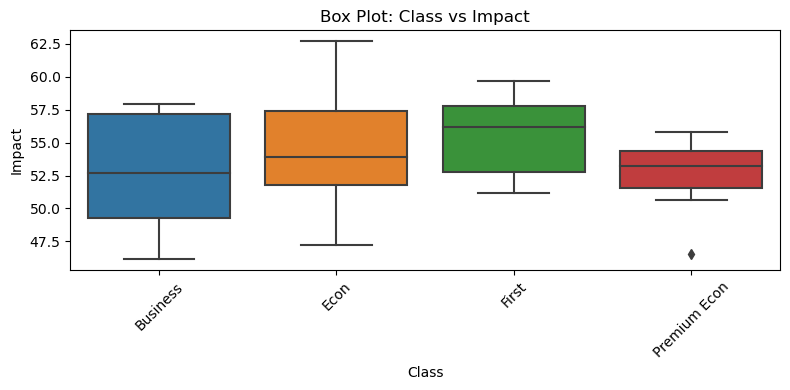

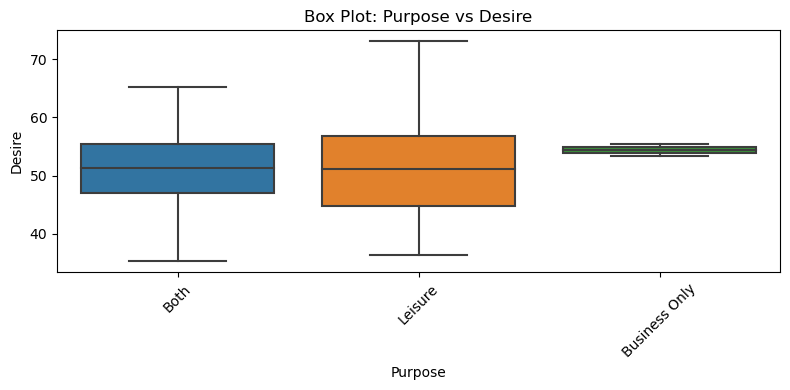

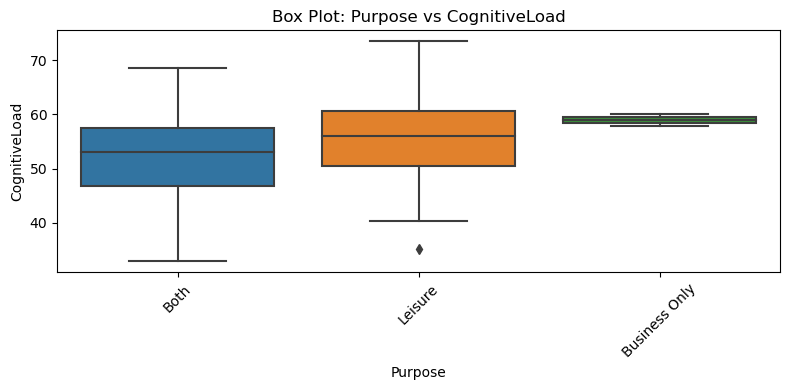

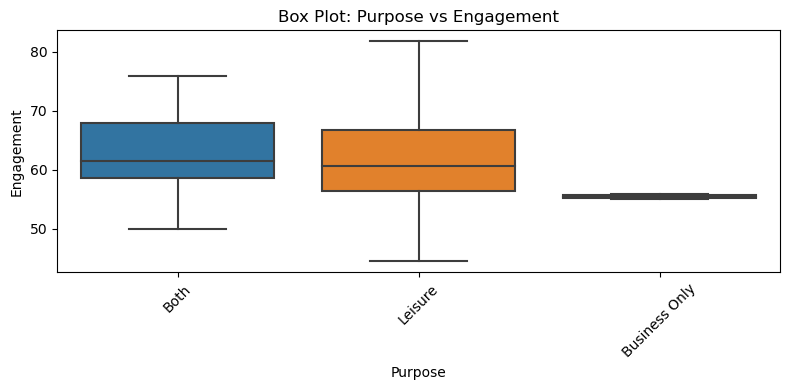

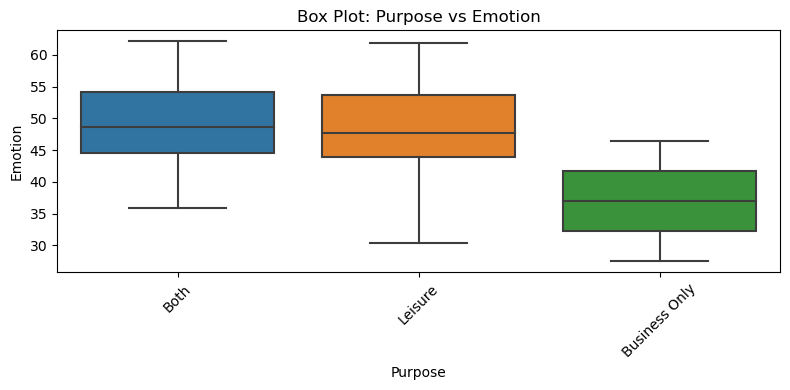

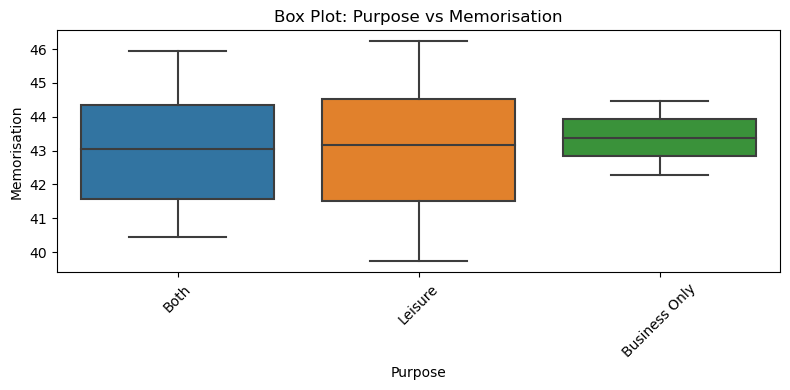

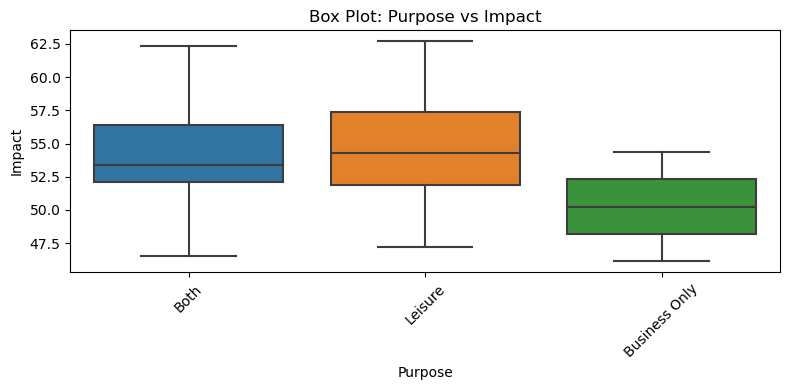

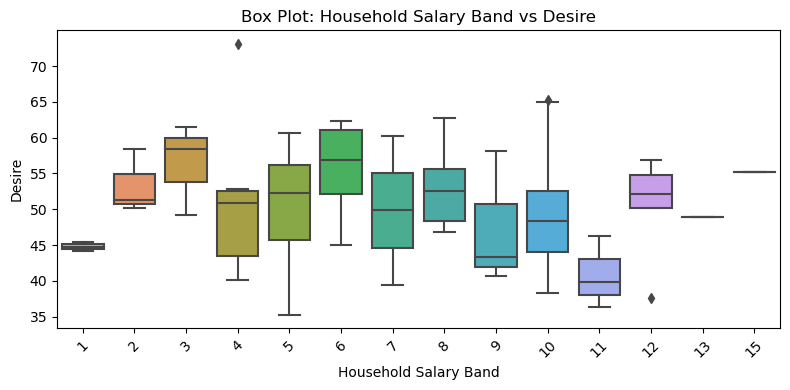

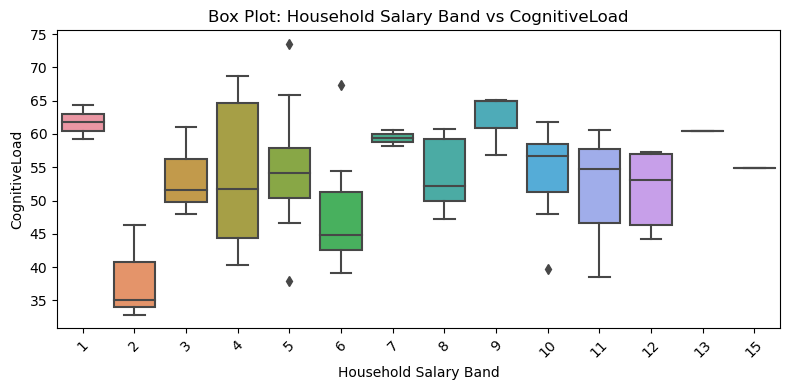

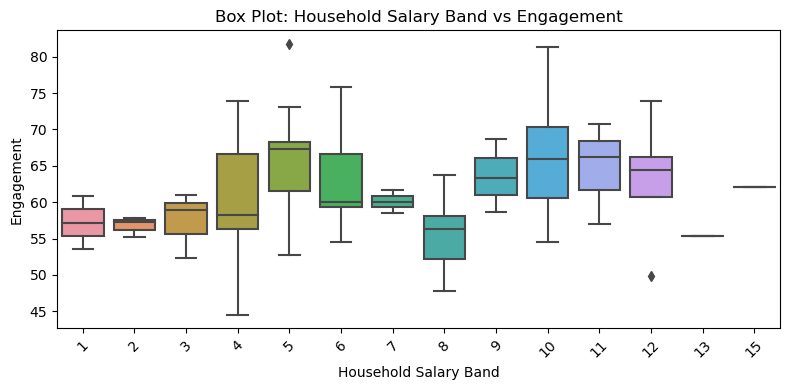

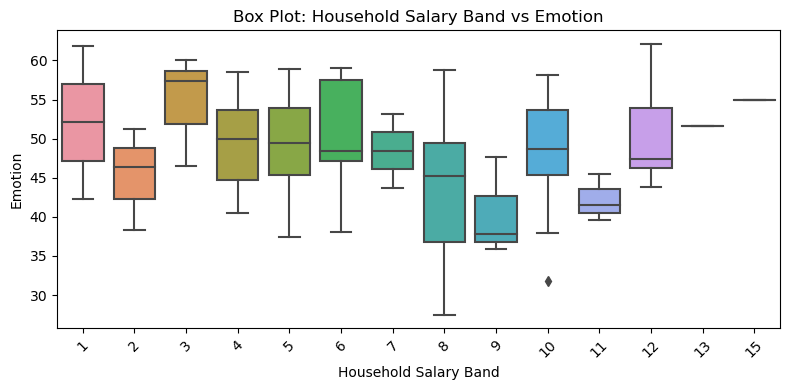

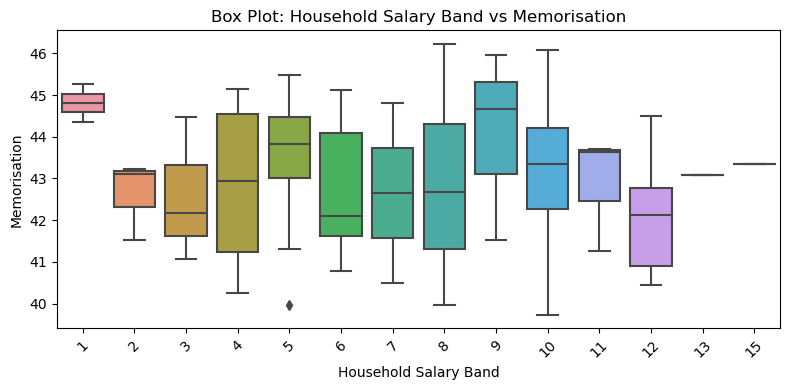

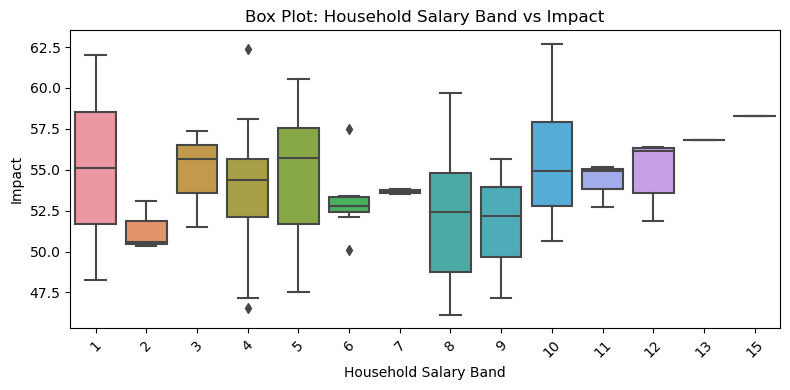


ANOVA Analysis Results:
--------------------------------------------------------------------------------

Comparison: Age Bracket vs Desire
F-statistic: 2.0703
P-value: 0.0931
Statistically Significant: No
--------------------------------------------------------------------------------

Comparison: Age Bracket vs CognitiveLoad
F-statistic: 1.3846
P-value: 0.2474
Statistically Significant: No
--------------------------------------------------------------------------------

Comparison: Age Bracket vs Engagement
F-statistic: 1.3327
P-value: 0.2657
Statistically Significant: No
--------------------------------------------------------------------------------

Comparison: Age Bracket vs Emotion
F-statistic: 0.5200
P-value: 0.7213
Statistically Significant: No
--------------------------------------------------------------------------------

Comparison: Age Bracket vs Memorisation
F-statistic: 0.6671
P-value: 0.6168
Statistically Significant: No
-----------------------------------------------

In [48]:
categorical_variables = ['Age Bracket', 'Gender', 'Occupation', 'Class', 'Purpose','Household Salary Band']
continuous_variables = ['Desire', 'CognitiveLoad', 'Engagement', 'Emotion', 'Memorisation','Impact']


sample=merged_df[merged_df['SourceStimuliName']=='CX_INP_003']#CX_INP_002
# Perform ANOVA analysis
results = perform_anova_analysis(sample.copy(), categorical_variables, continuous_variables)


# Print results
print_anova_results(results)

In [49]:
print(pd.DataFrame(results).T)

                                       f_statistic   p_value significant
Age Bracket vs Desire                     2.070321  0.093117       False
Age Bracket vs CognitiveLoad              1.384566  0.247422       False
Age Bracket vs Engagement                 1.332739  0.265667       False
Age Bracket vs Emotion                    0.520023  0.721252       False
Age Bracket vs Memorisation               0.667128  0.616801       False
Age Bracket vs Impact                     1.134826  0.346679       False
Gender vs Desire                          2.165726  0.145141       False
Gender vs CognitiveLoad                   0.082008  0.775354       False
Gender vs Engagement                      0.276362  0.600587       False
Gender vs Emotion                         0.021613  0.883499       False
Gender vs Memorisation                     0.14015  0.709148       False
Gender vs Impact                          0.044308  0.833831       False
Occupation vs Desire                      0.962645 

C:\Users\FutureProofInsights\AppData\Local\Temp\ipykernel_27920\716272621.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[var] = pd.to_numeric(sample[var], errors='coerce')
C:\Users\FutureProofInsights\AppData\Local\Temp\ipykernel_27920\716272621.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[f'{var}_category'] = categorize_continuous_variable(sample[var])
C:\Users\FutureProofInsights\AppData\Local\Temp\ipykernel_27920\716272621.py:57: SettingWithCopyWarning: 
A value is trying to b

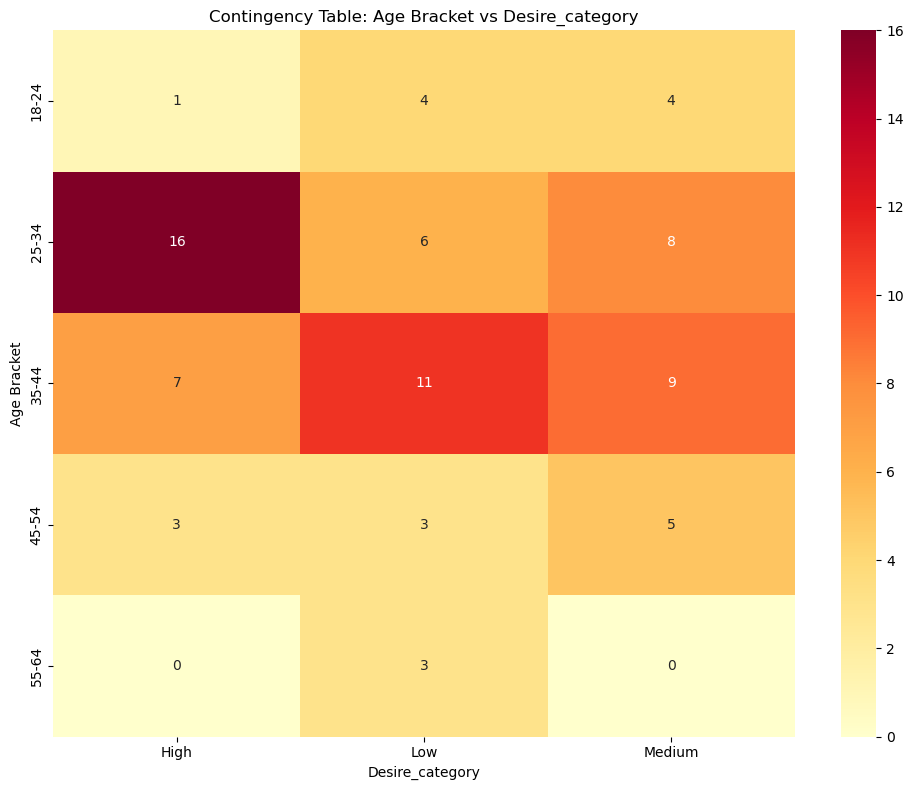

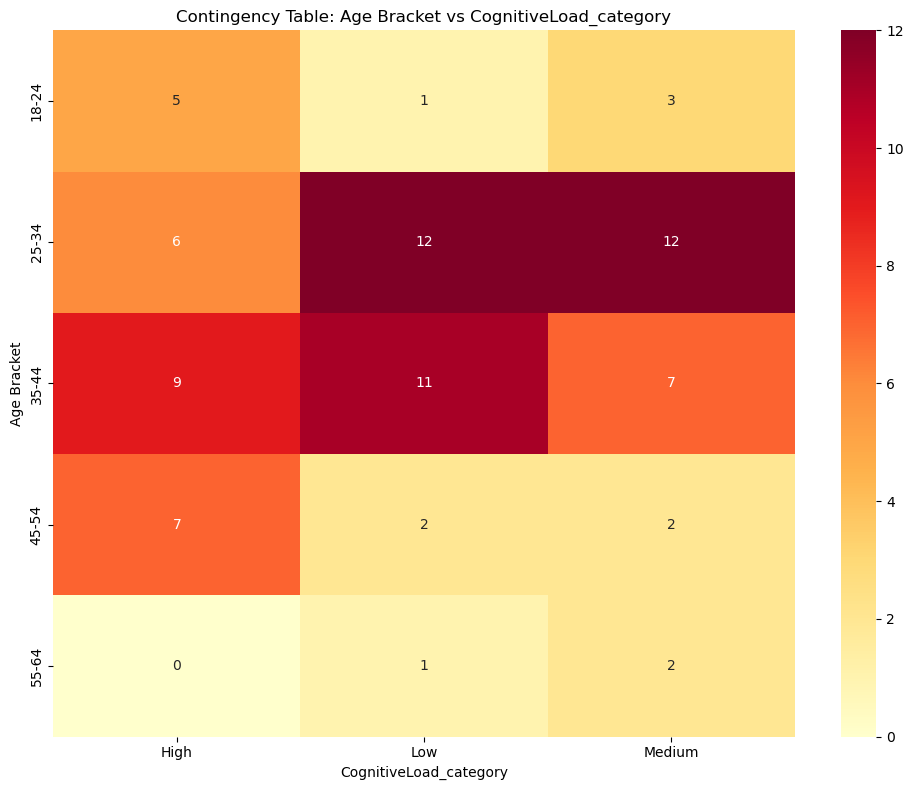

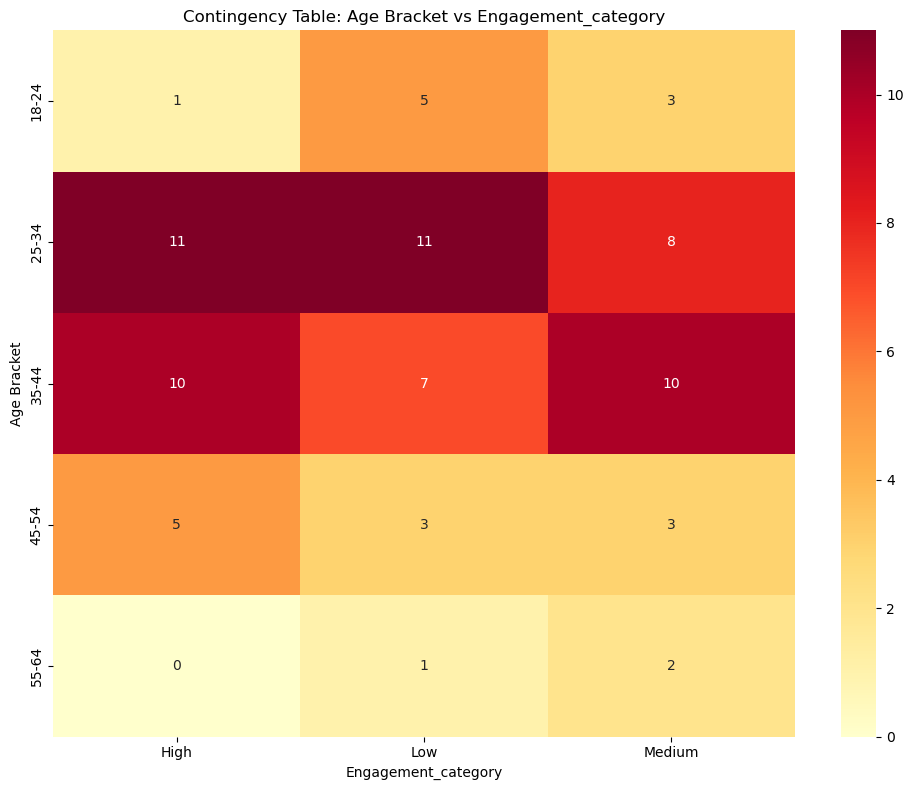

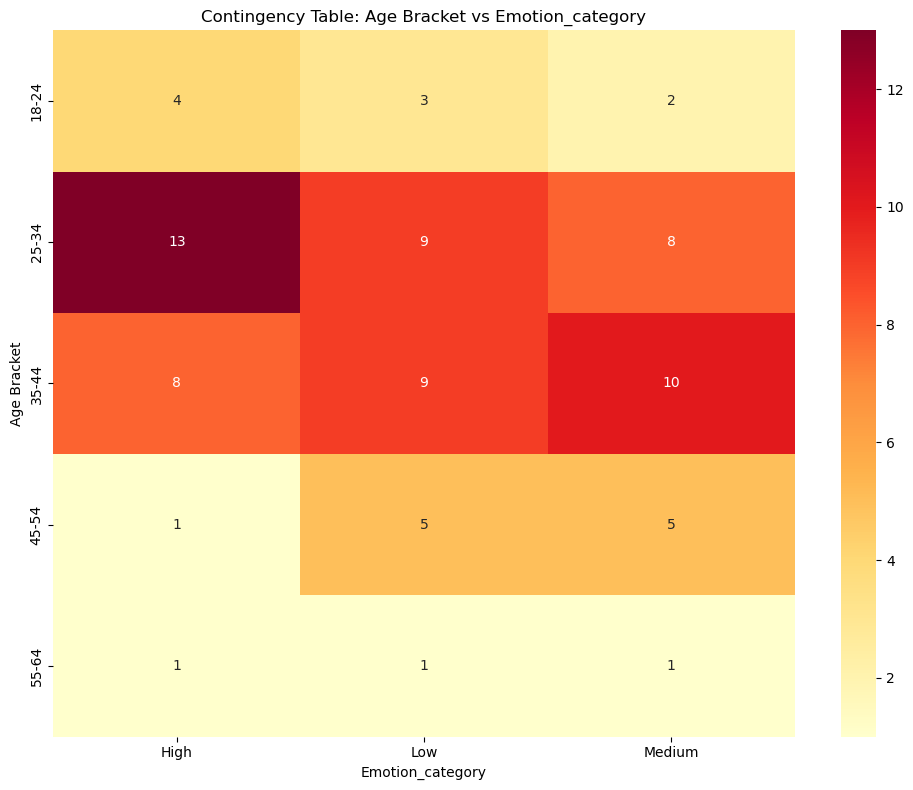

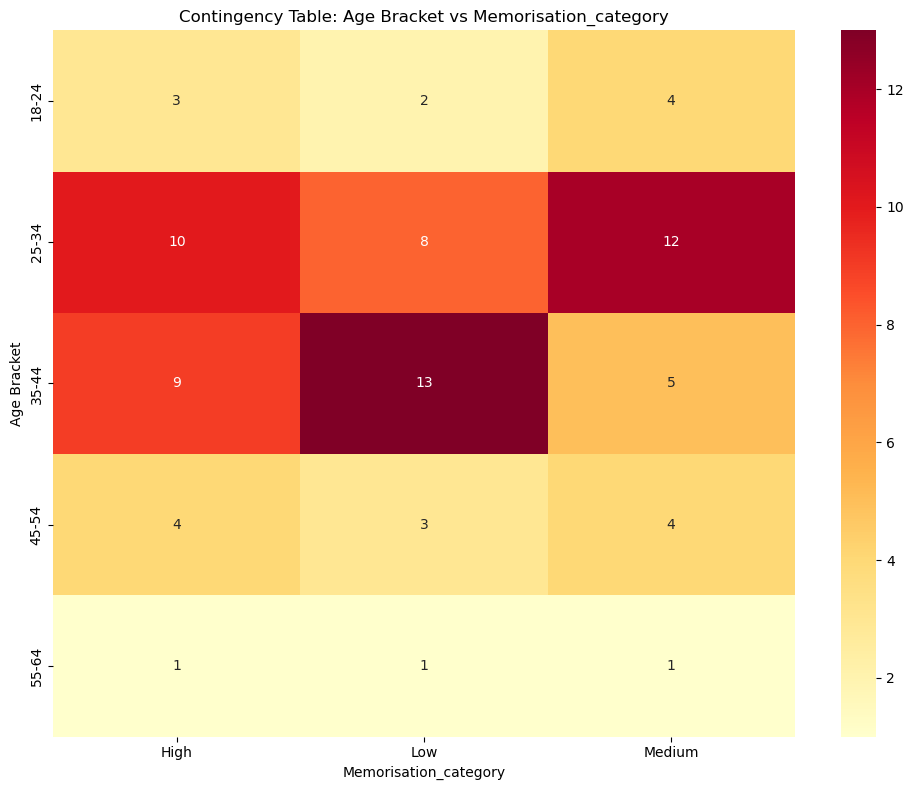

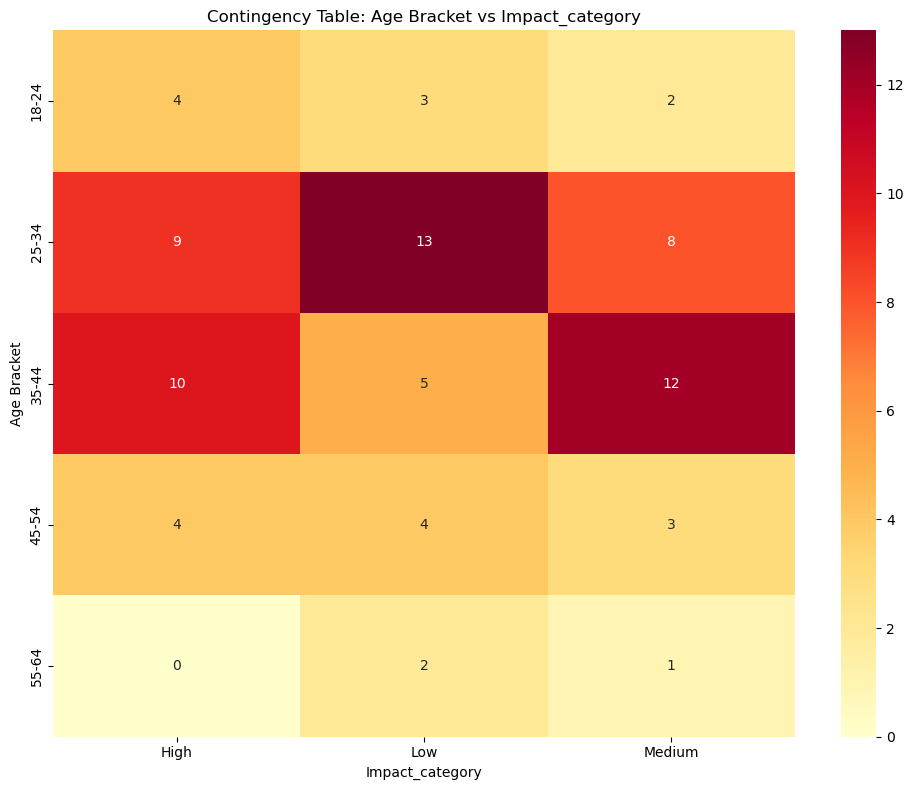

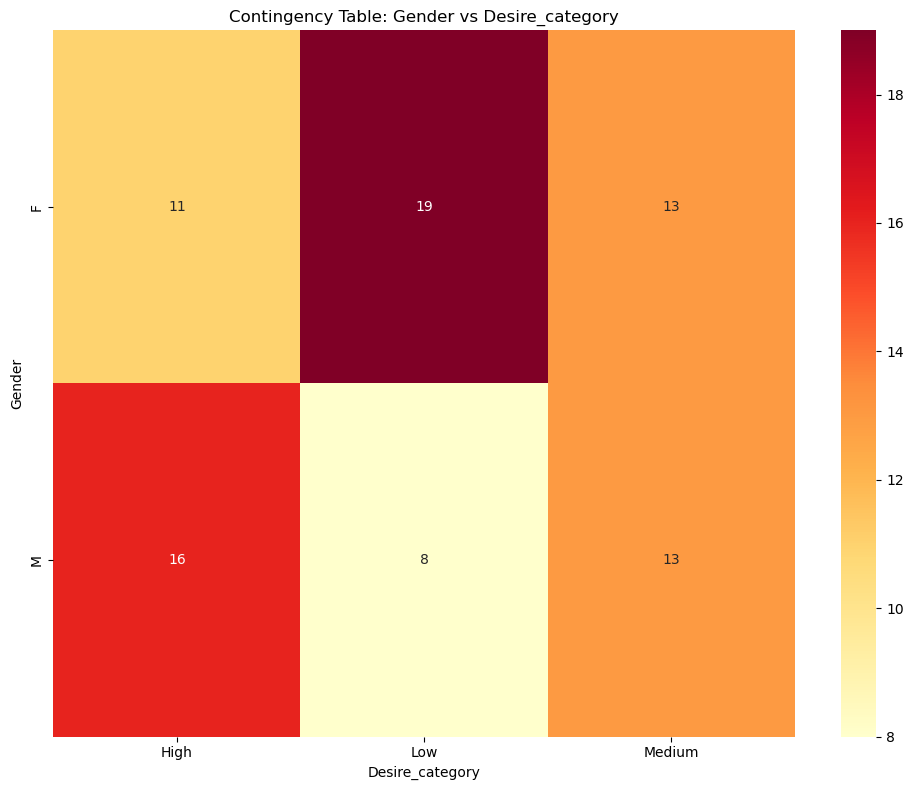

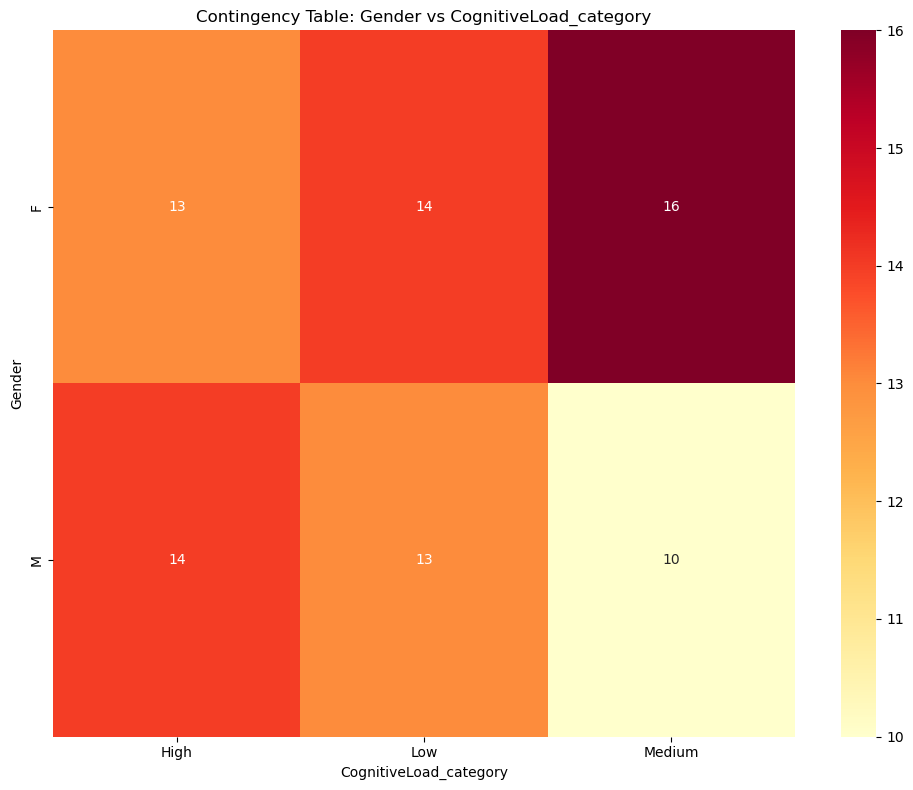

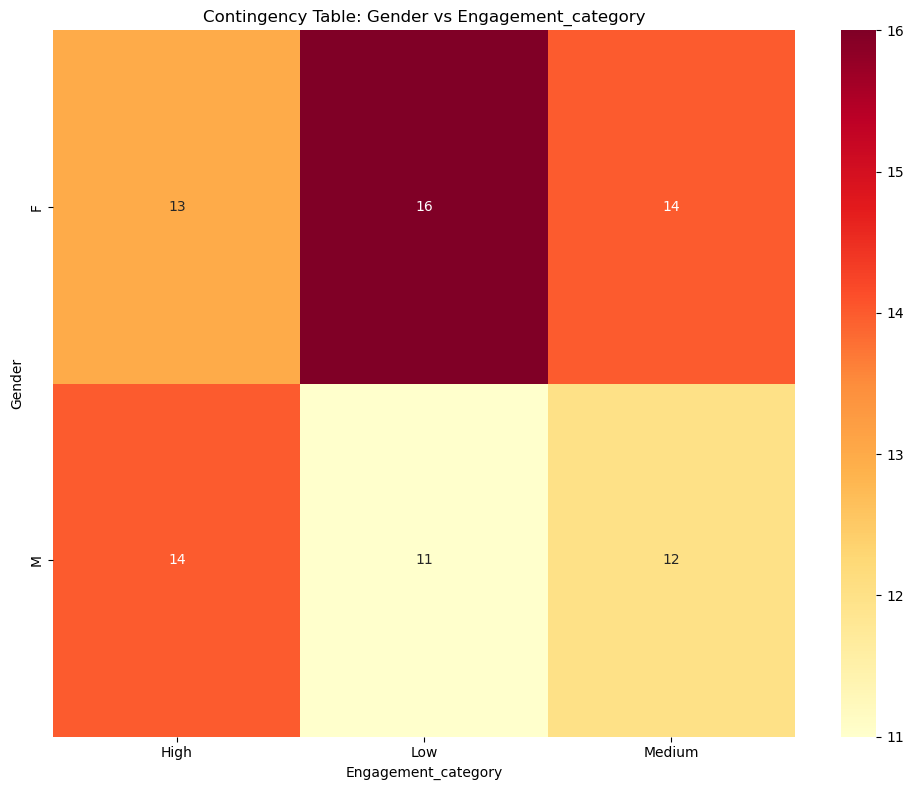

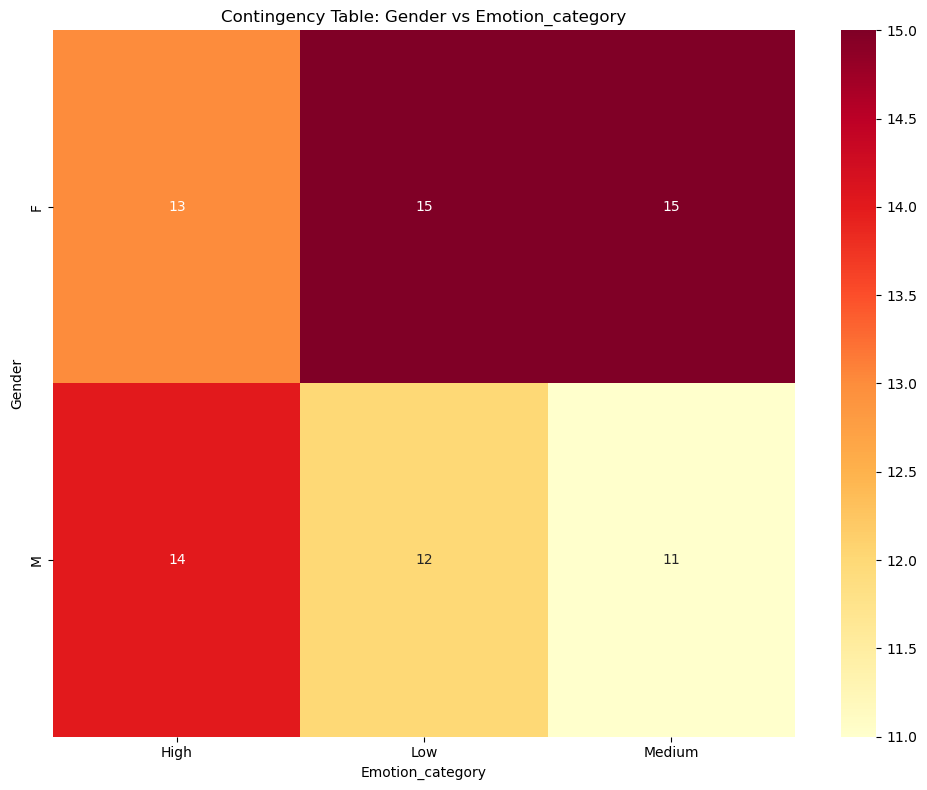

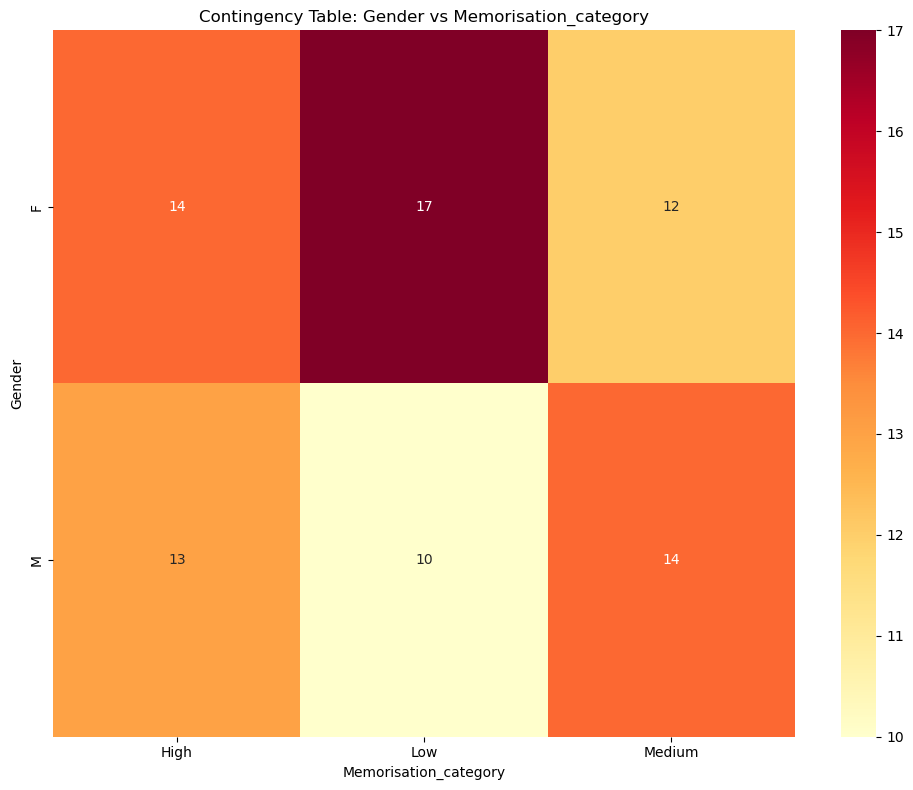

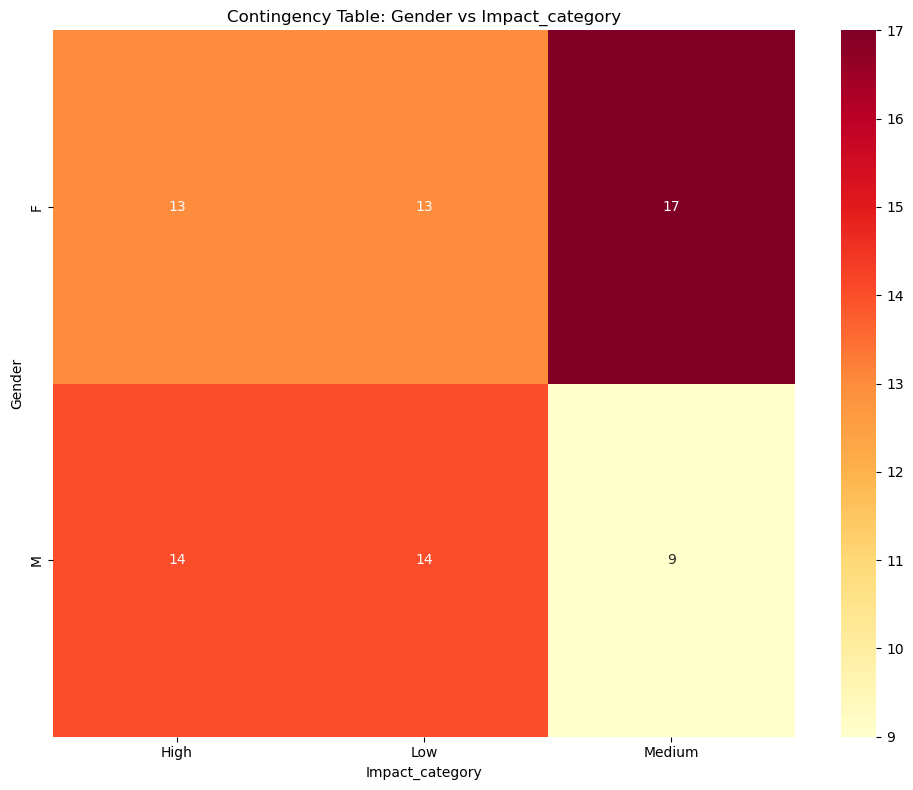

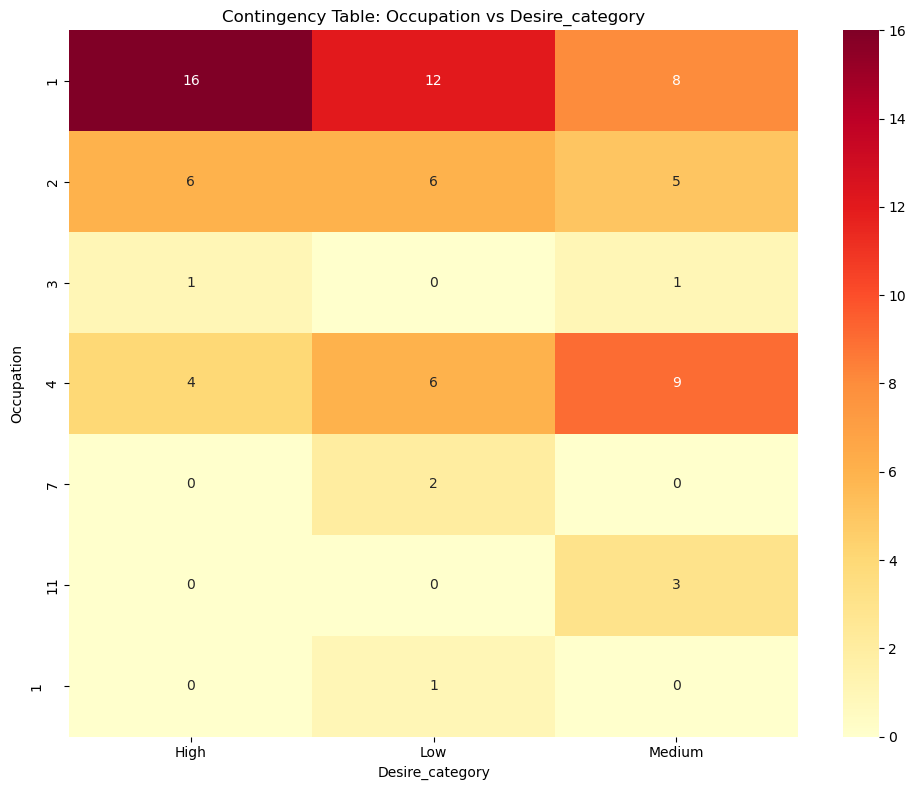

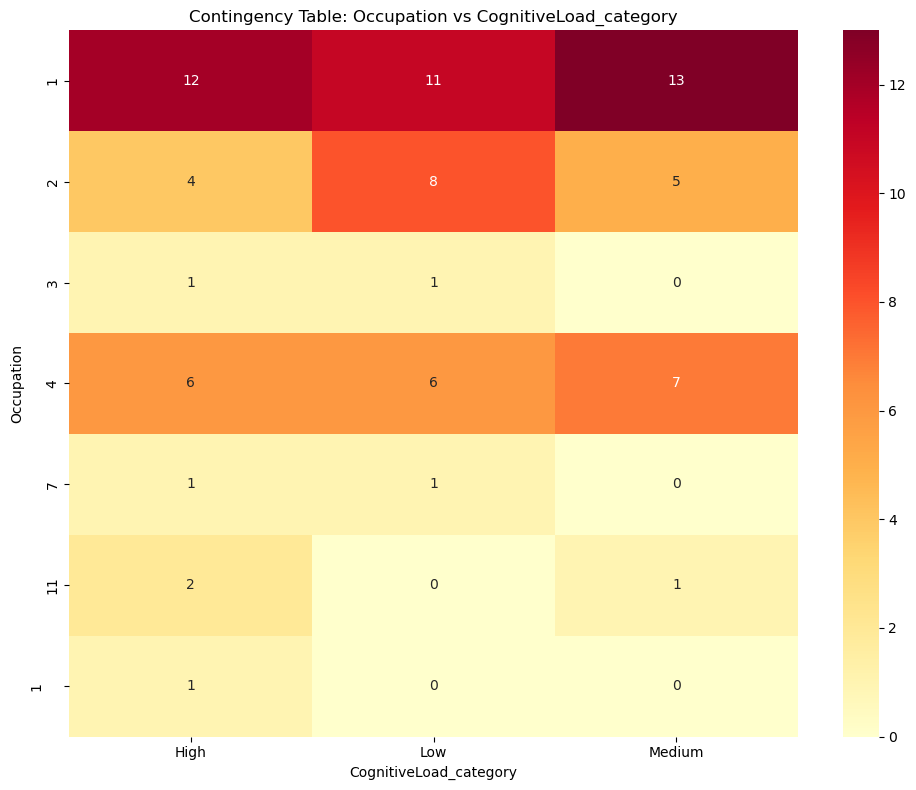

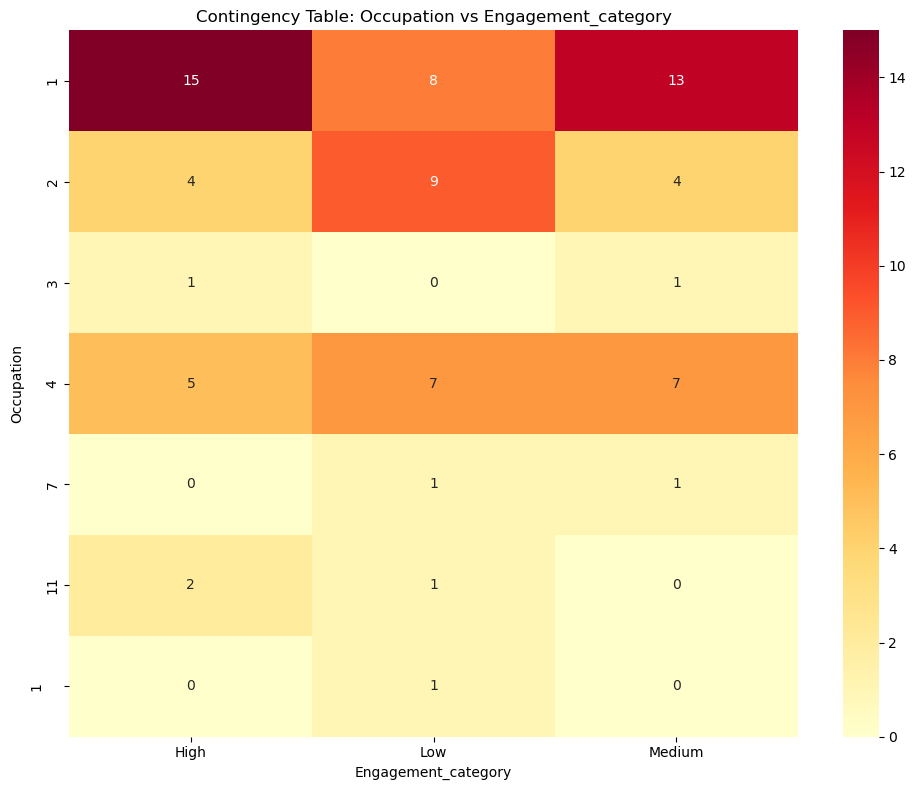

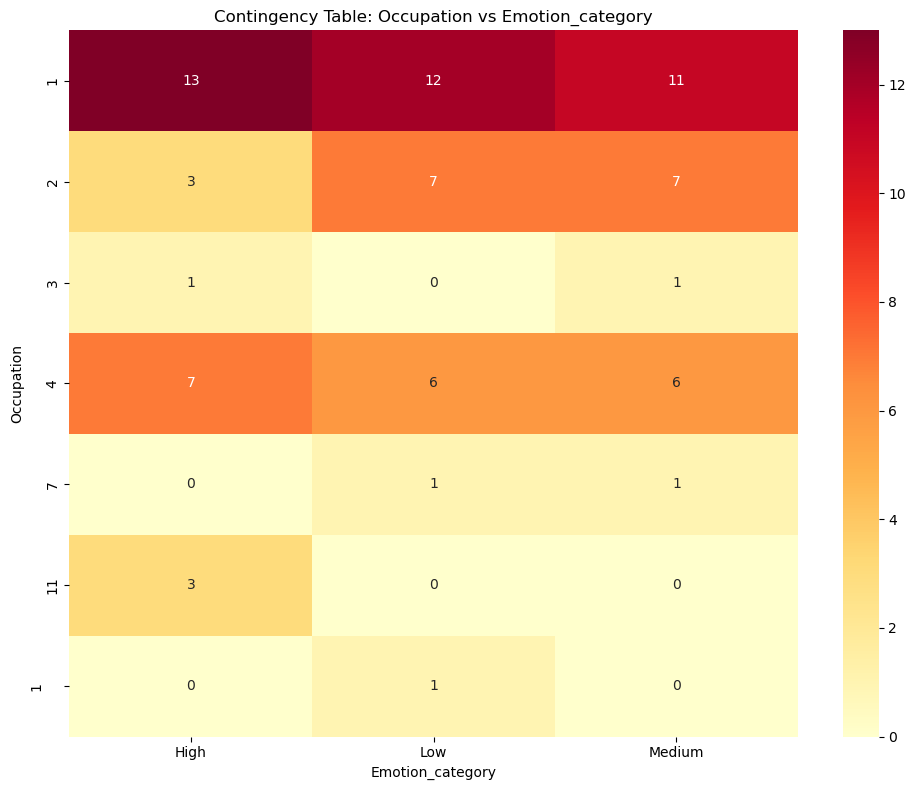

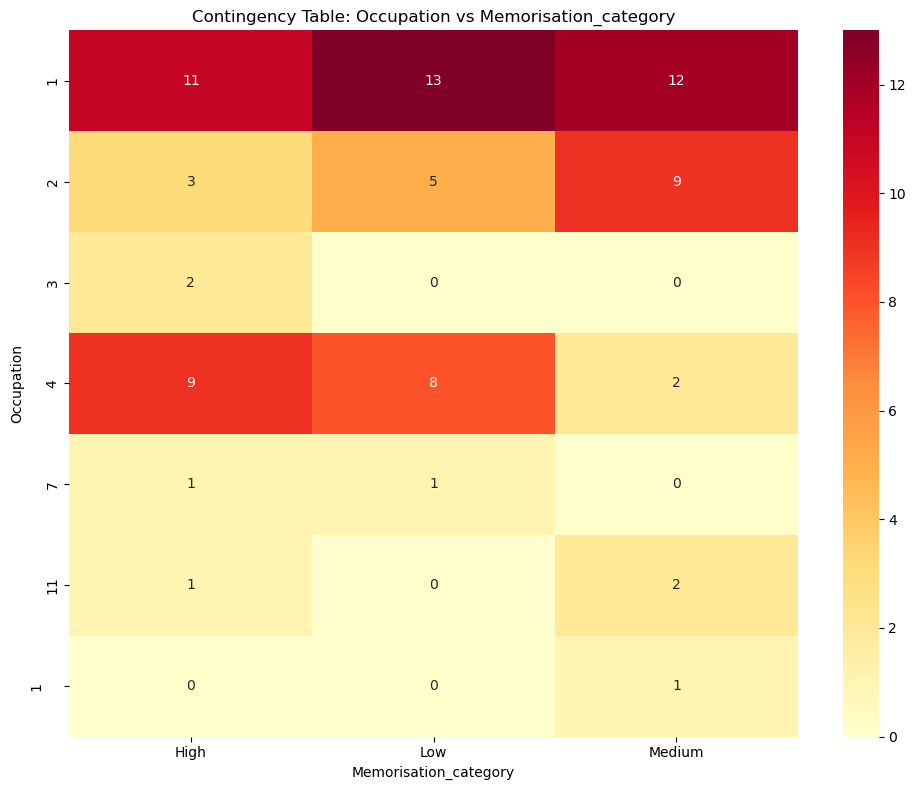

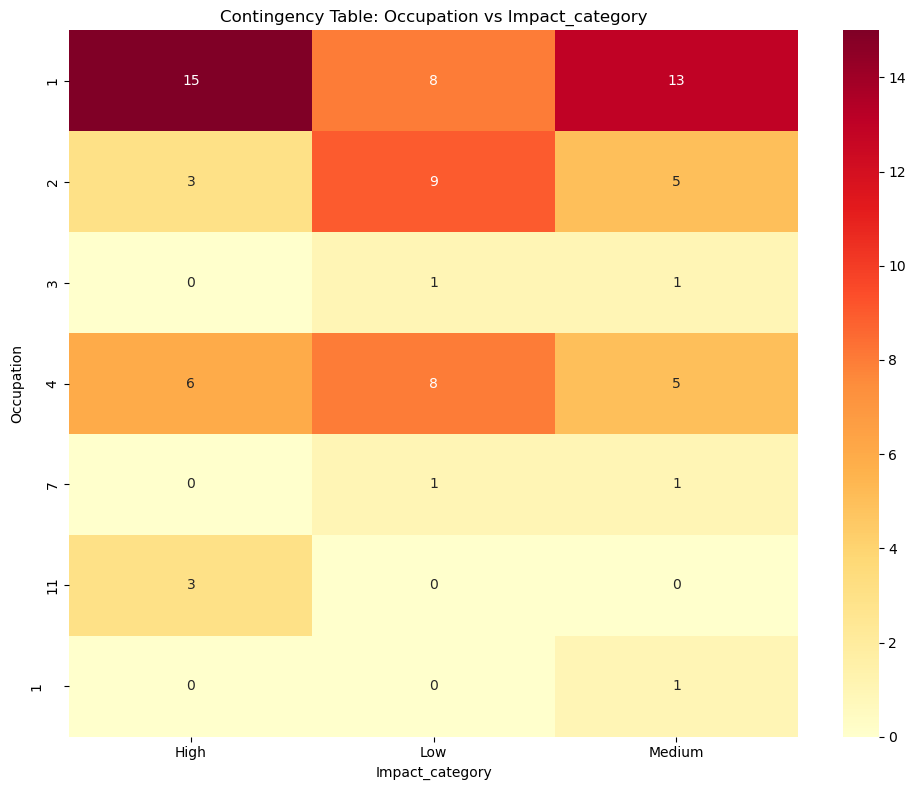

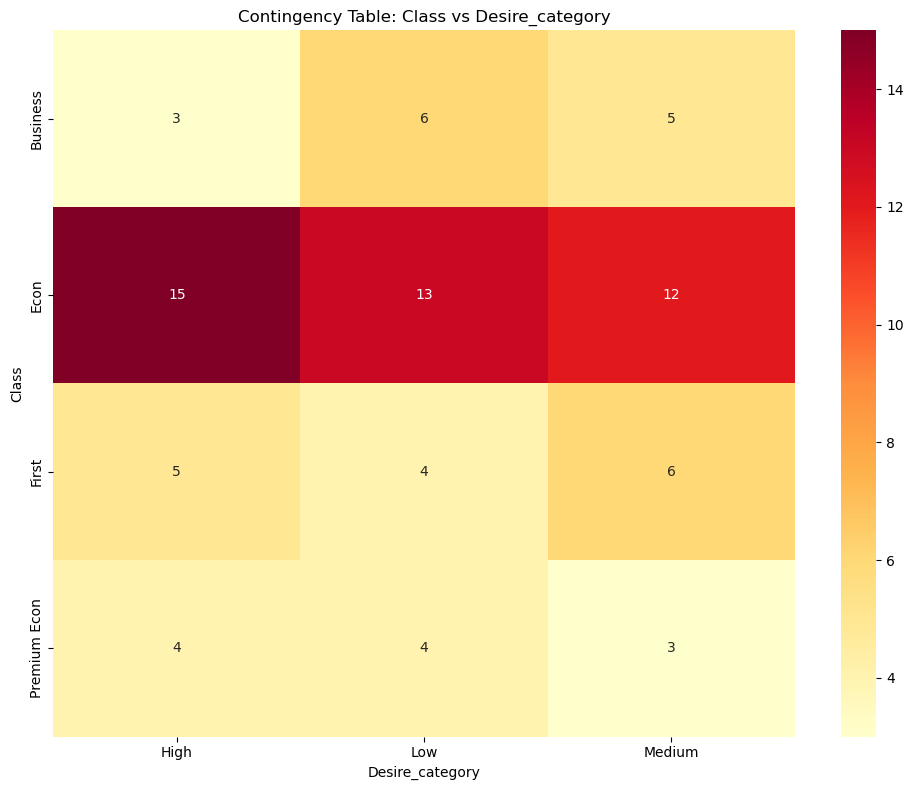

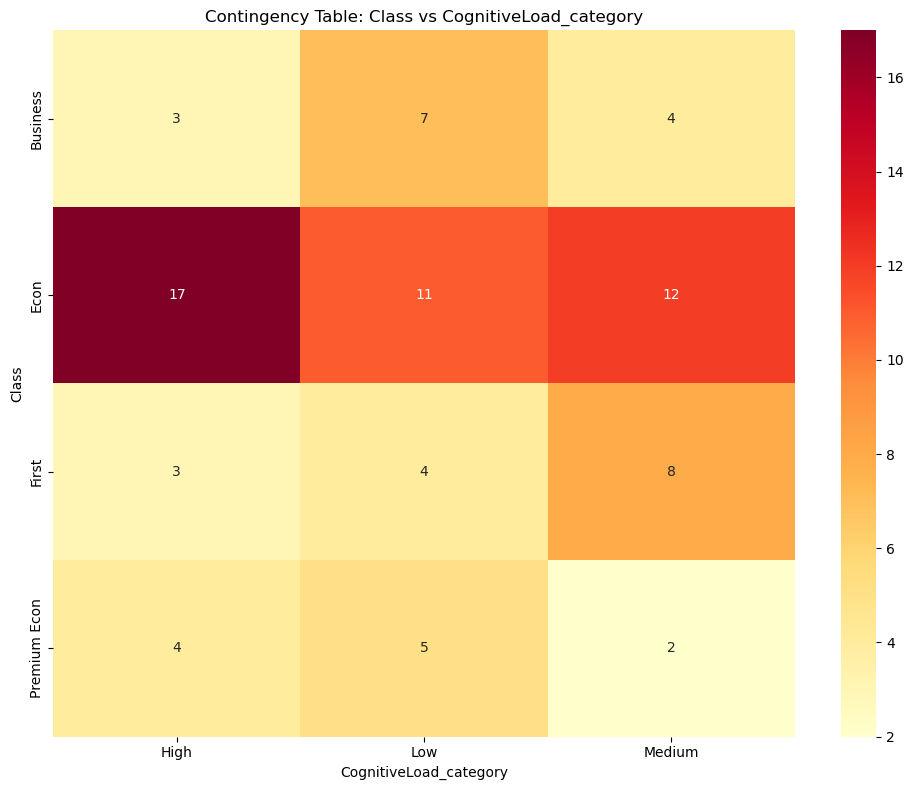

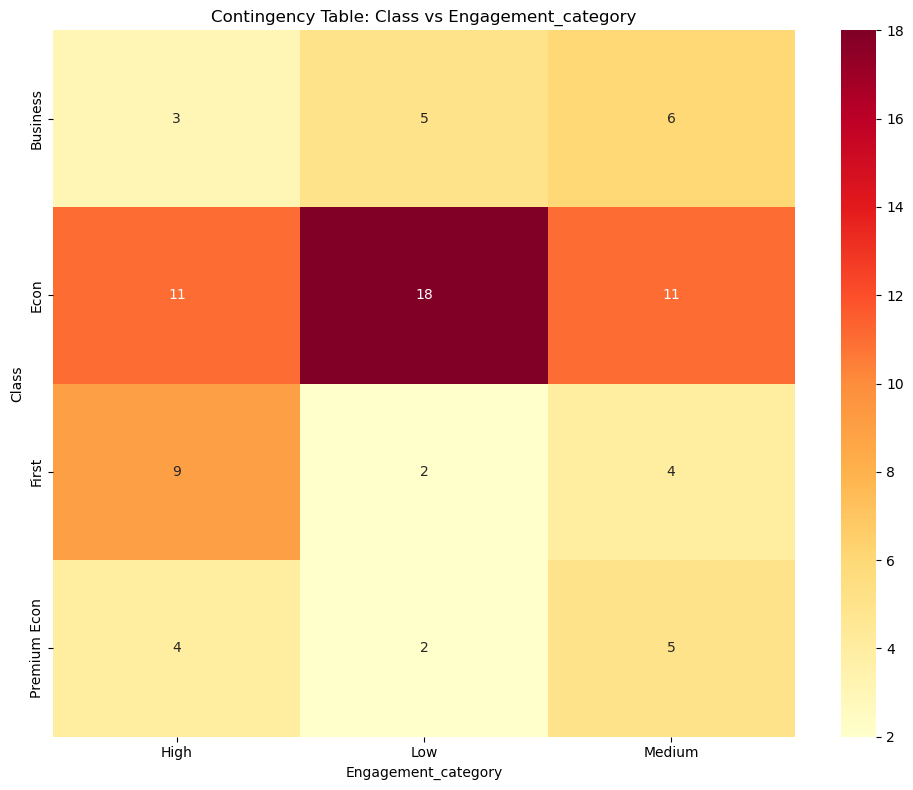

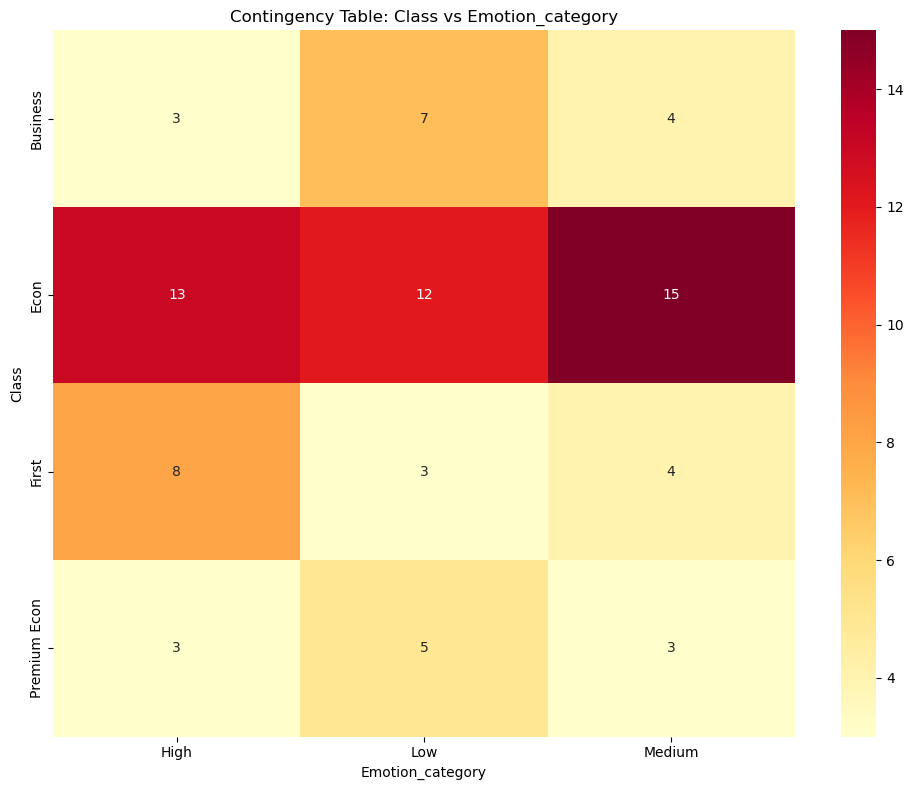

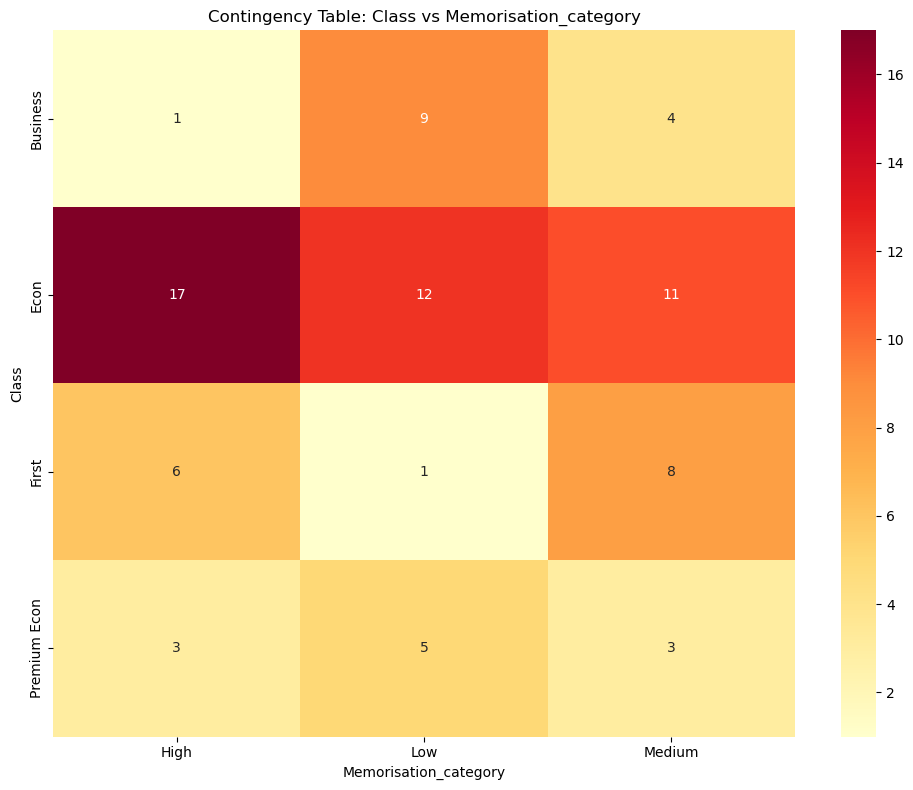

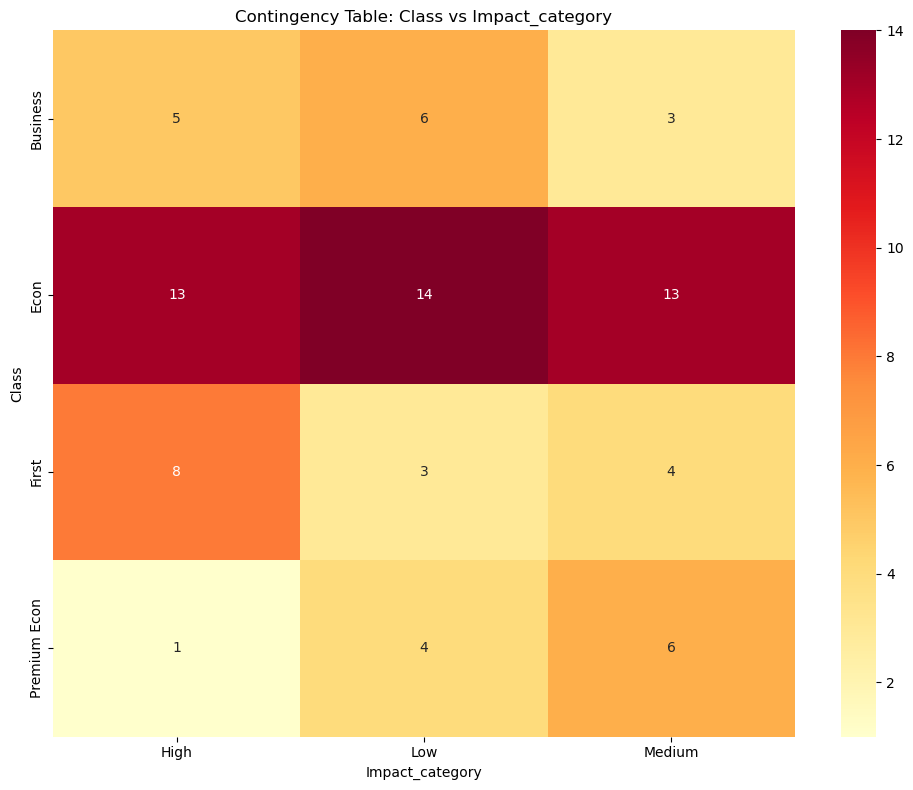

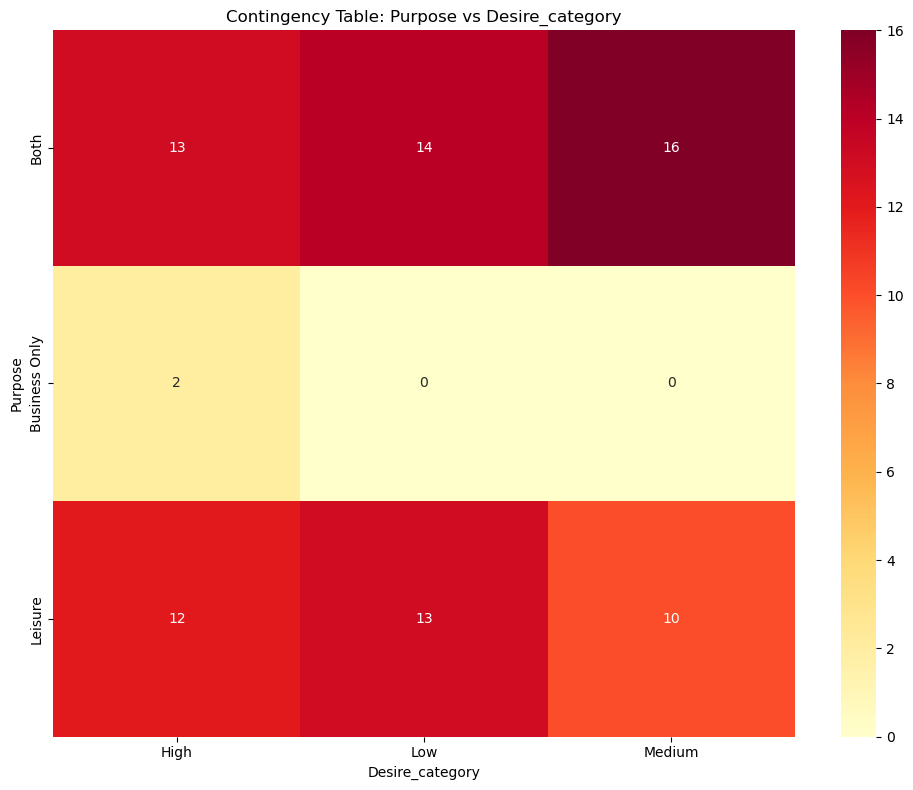

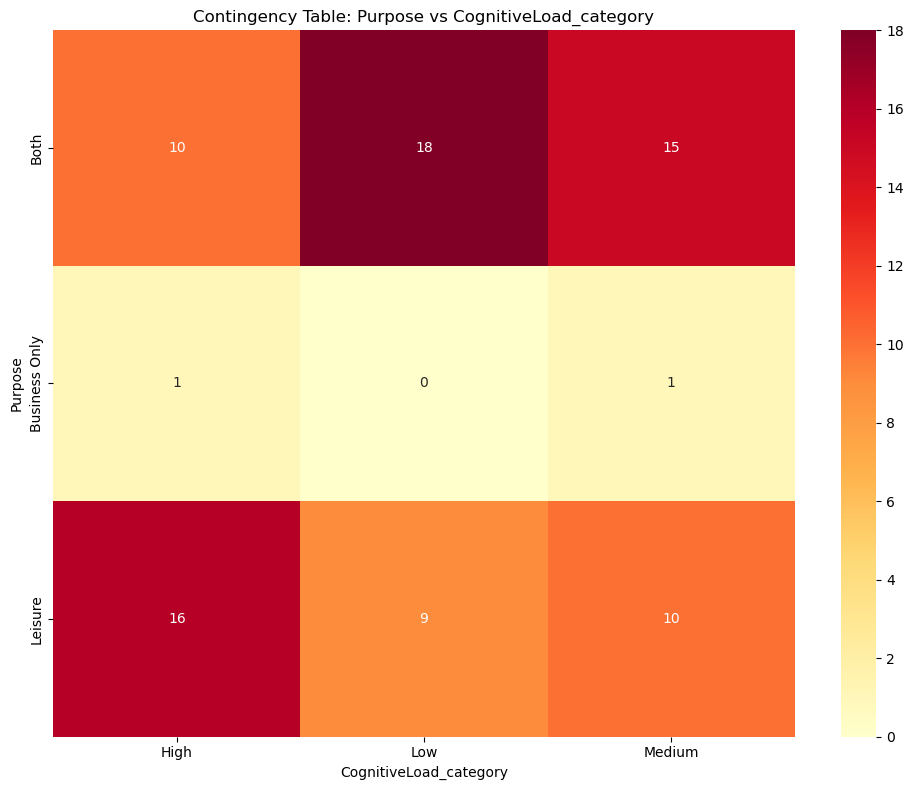

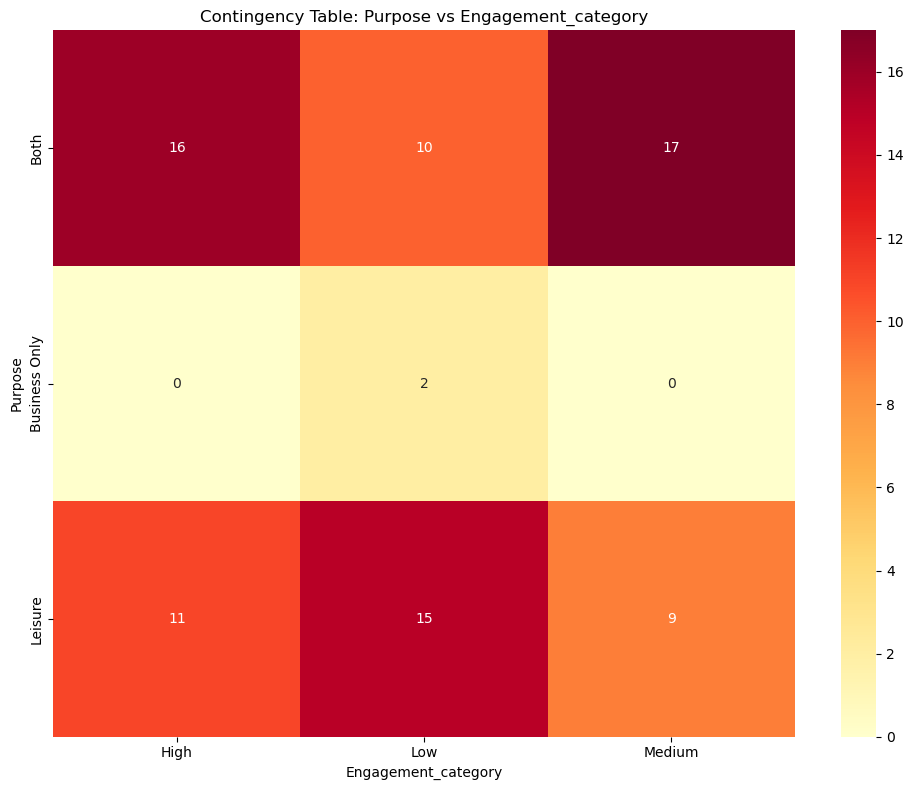

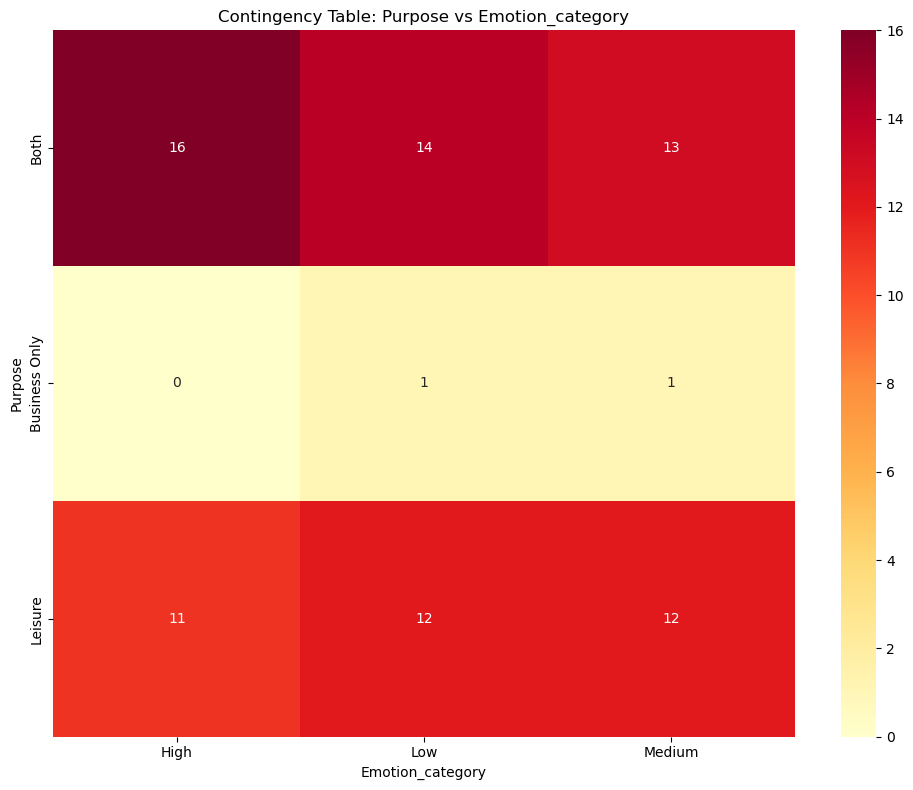

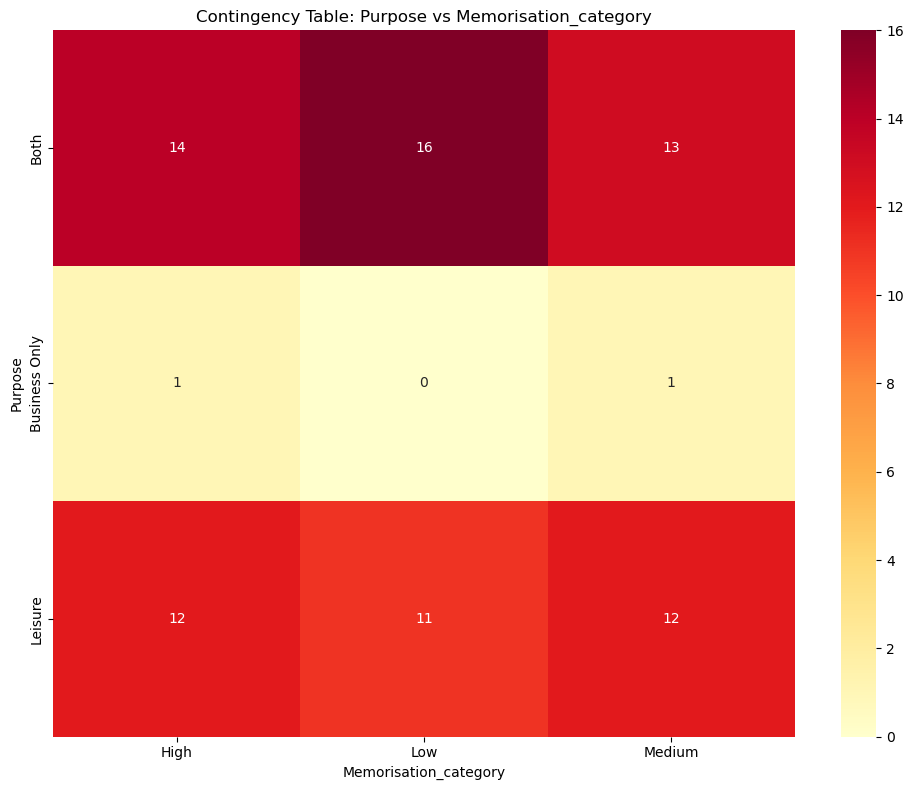

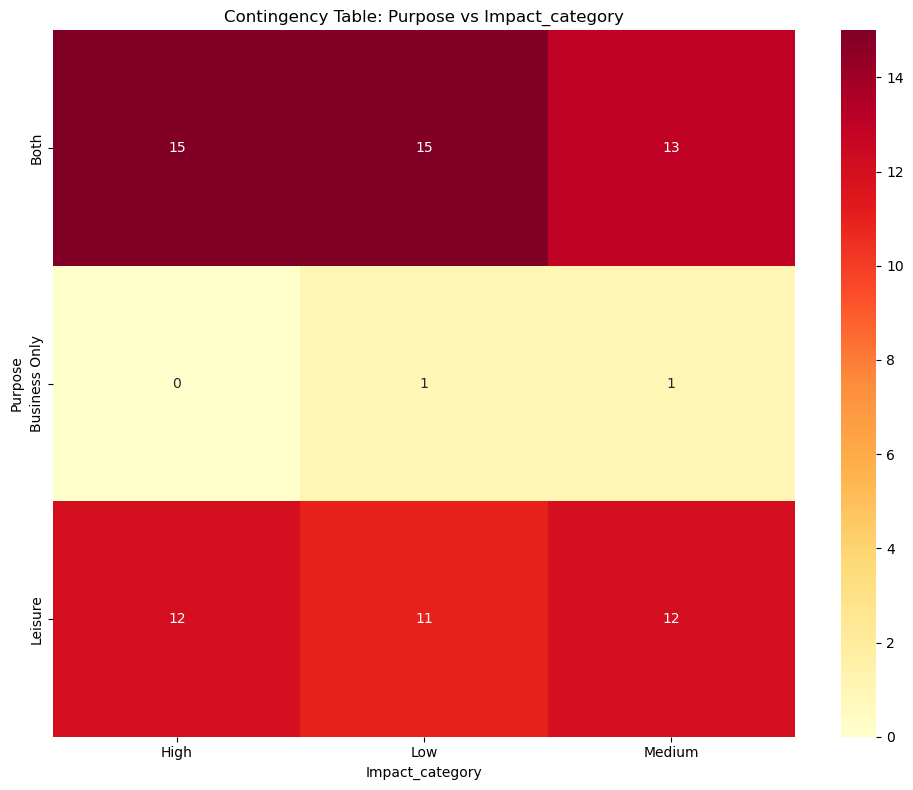

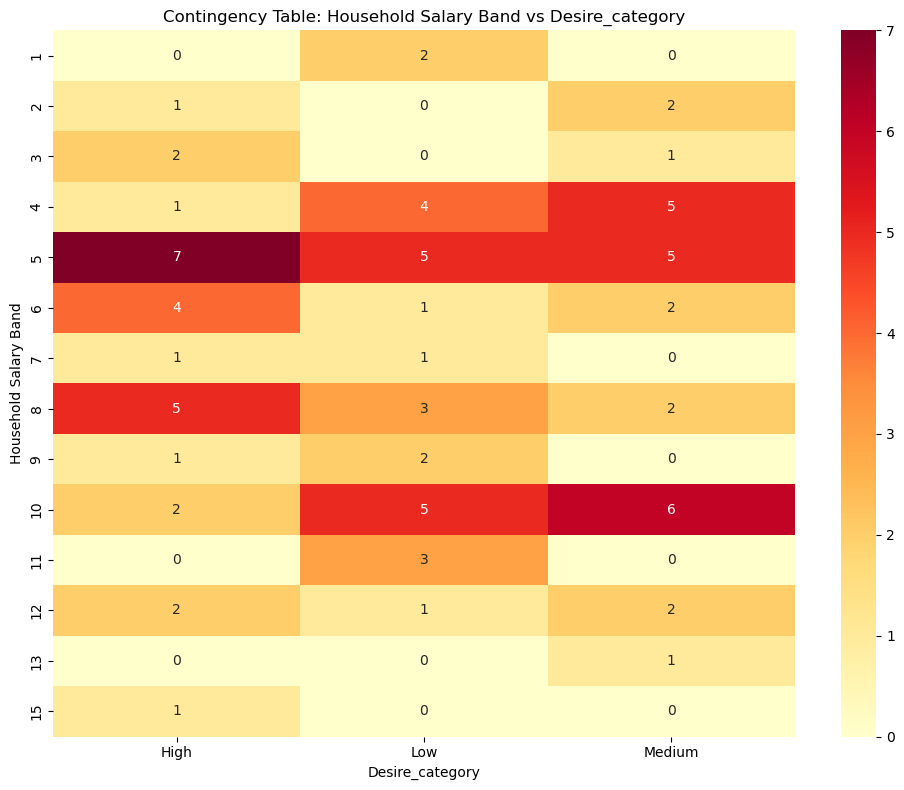

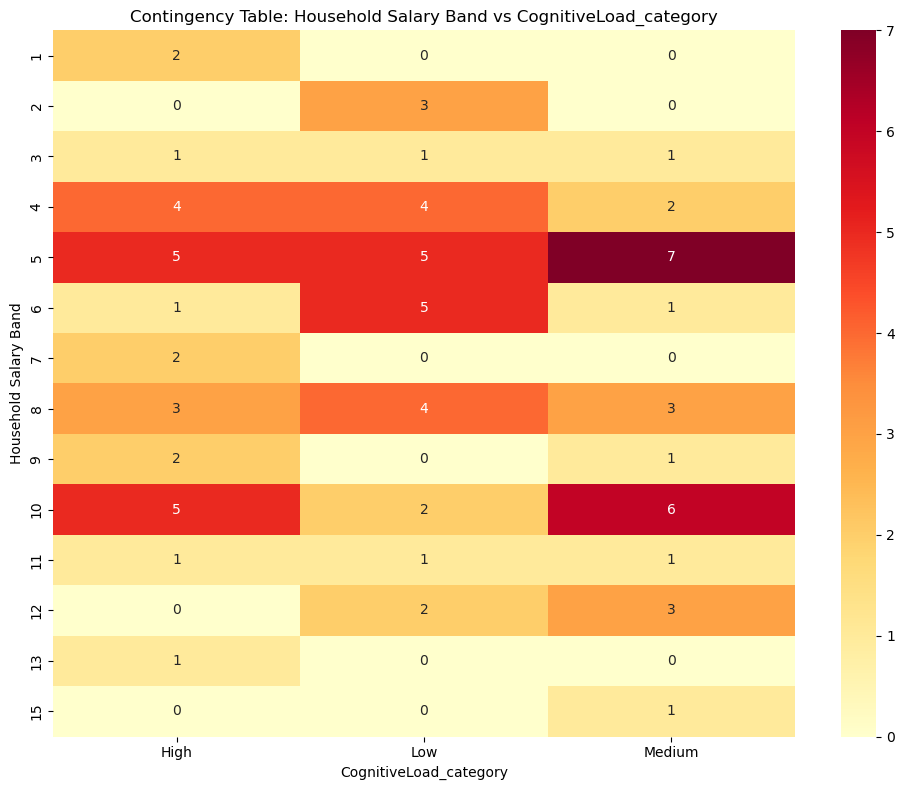

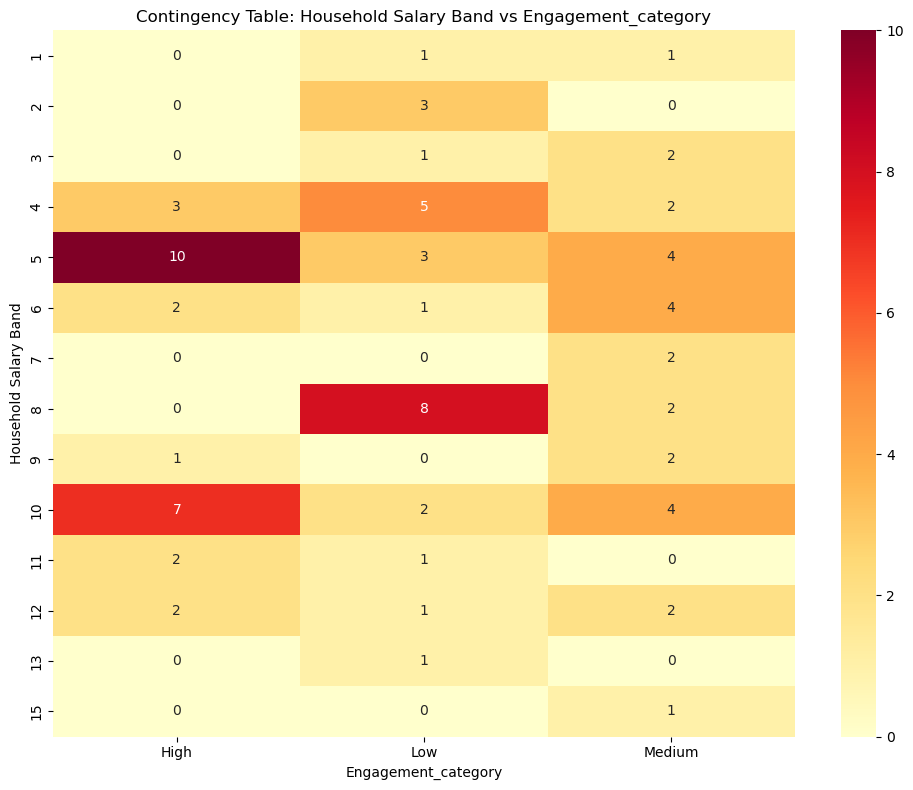

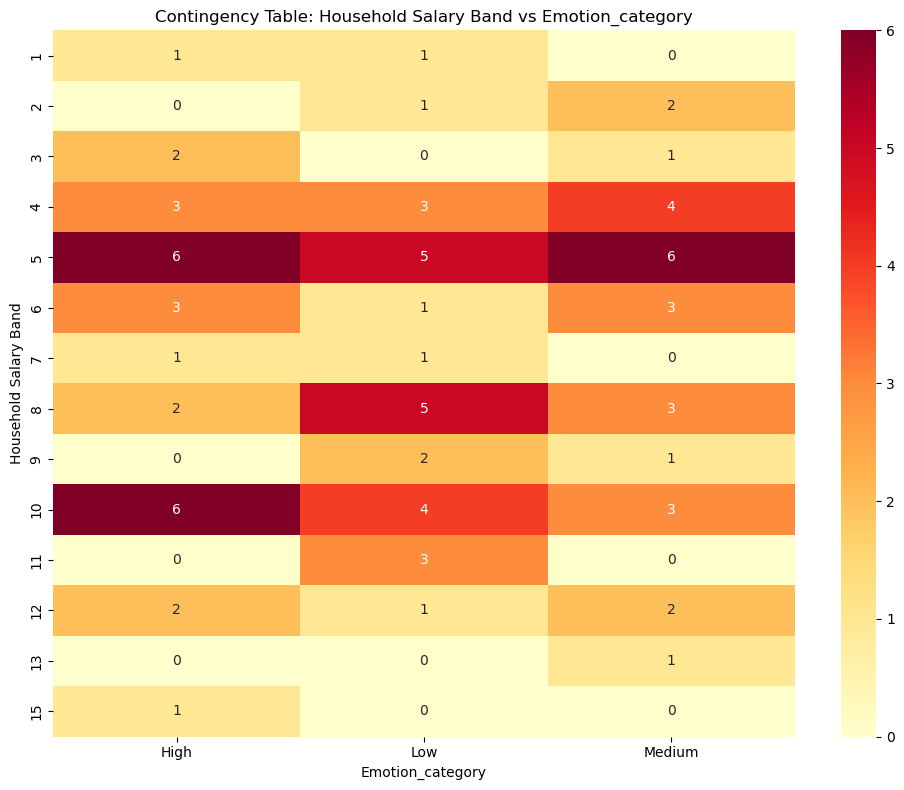

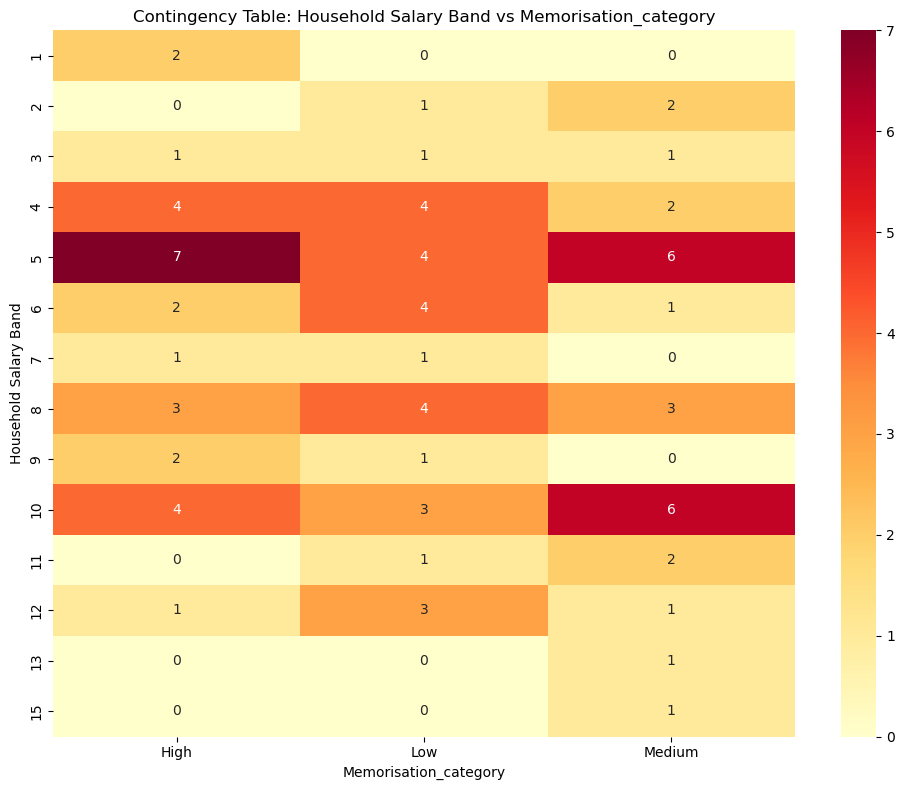

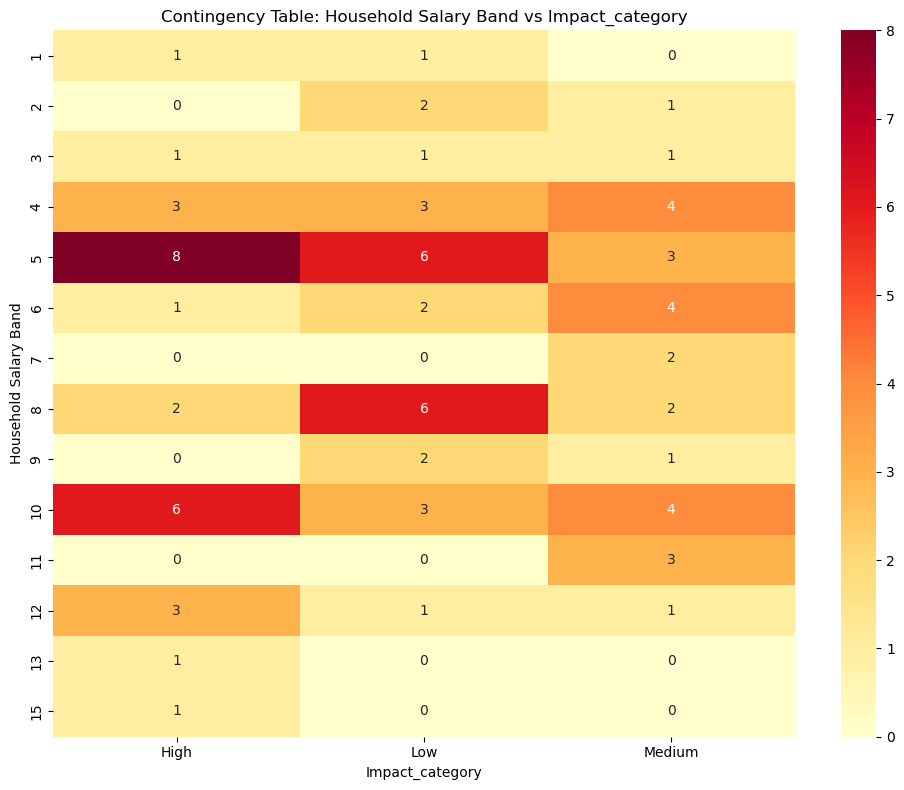


Chi-Square Analysis Results:
           Variable 1             Variable 2  Chi-Square  p-value  Degrees of Freedom  Cramer's V Significant  % Expected Freq < 5
Household Salary Band    Engagement_category     43.0542   0.0191                  26      0.5187         Yes                92.86
                Class  Memorisation_category     14.3653   0.0258                   6      0.2996         Yes                58.33
Household Salary Band CognitiveLoad_category     30.7151   0.2390                  26      0.4381          No                92.86
Household Salary Band        Desire_category     29.7880   0.2765                  26      0.4315          No                92.86
Household Salary Band        Impact_category     29.3582   0.2950                  26      0.4284          No                92.86
Household Salary Band       Emotion_category     22.2587   0.6745                  26      0.3730          No                92.86
Household Salary Band  Memorisation_category     21.5

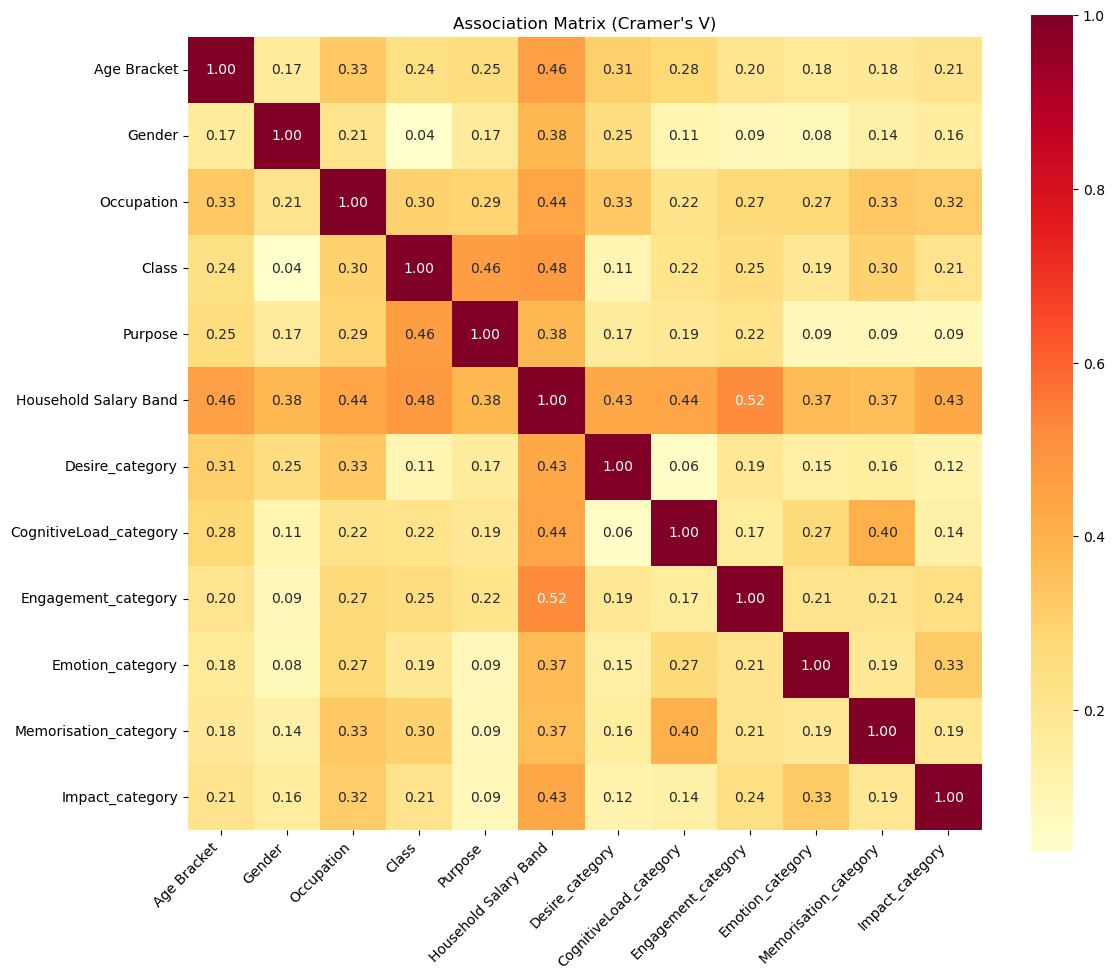

In [50]:

def categorize_continuous_variable(series):
    """
    Categorize a continuous variable into Low, Medium, and High based on percentiles
    """
    series = pd.to_numeric(series, errors='coerce')  # Convert to numeric, handling any non-numeric values
    bins = [float('-inf'), series.quantile(0.33), series.quantile(0.66), float('inf')]
    labels = ['Low', 'Medium', 'High']
    return pd.cut(series, bins=bins, labels=labels)

def perform_chi_square_analysis(df,  categorical_variables,categorized_vars):
    """
    Perform chi-square analysis between all pairs of categorical variables
    """
    results = []
    
    for i, var1 in enumerate(categorical_variables):
        for var2 in categorized_vars:
            # Create contingency table
            contingency_table = pd.crosstab(df[var1], df[var2])
            
            # Perform chi-square test
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            
            # Calculate Cramer's V
            n = contingency_table.sum().sum()
            min_dim = min(contingency_table.shape) - 1
            cramer_v = np.sqrt(chi2 / (n * min_dim))
            
            # Calculate the percentage of expected frequencies < 5
            expected_lt_5 = (expected < 5).sum() / expected.size * 100
            
            results.append({
                'Variable 1': var1,
                'Variable 2': var2,
                'Chi-Square': chi2,
                'p-value': p_value,
                'Degrees of Freedom': dof,
                "Cramer's V": cramer_v,
                'Significant': 'Yes' if p_value < 0.05 else 'No',
                '% Expected Freq < 5': expected_lt_5
            })
            
            # Create and save contingency table visualization
            plt.figure(figsize=(10, 8))
            sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlOrRd')
            plt.title(f'Contingency Table: {var1} vs {var2}')
            plt.tight_layout()
            plt.show()
    
    return pd.DataFrame(results)

# Ensure continuous variables are numeric


# Convert continuous variables to numeric and categorize them
for var in continuous_variables:
    sample[var] = pd.to_numeric(sample[var], errors='coerce')
    sample[f'{var}_category'] = categorize_continuous_variable(sample[var])

# Create list of all categorical variables (original + categorized)

categorized_vars = [f'{var}_category' for var in continuous_variables]
all_categorical_vars = categorical_variables + categorized_vars
sample[all_categorical_vars] = sample[all_categorical_vars].astype('object')

# Perform chi-square analysis
results_df = perform_chi_square_analysis(sample, categorical_variables,categorized_vars)


# Format and display results
def format_results_table(results_df):
    """
    Format the results DataFrame for better display
    """
    formatted_df = results_df.copy()
    formatted_df['Chi-Square'] = formatted_df['Chi-Square'].round(4)
    formatted_df['p-value'] = formatted_df['p-value'].round(4)
    formatted_df["Cramer's V"] = formatted_df["Cramer's V"].round(4)
    formatted_df['% Expected Freq < 5'] = formatted_df['% Expected Freq < 5'].round(2)
    
    # Sort by significance and Cramer's V
    formatted_df = formatted_df.sort_values(['Significant', "Cramer's V"], 
                                          ascending=[False, False])
    
    return formatted_df

# Display formatted results
formatted_results = format_results_table(results_df)
print("\nChi-Square Analysis Results:")
print(formatted_results.to_string(index=False))

# Save results to CSV
formatted_results.to_csv('chi_square_results.csv', index=False)
print("\nResults have been saved to 'chi_square_results.csv'")

# Display distribution of categorized variables
print("\nDistribution of Categorized Variables:")
for var in categorized_vars:
    print(f"\n{var}:")
    print(sample[var].value_counts(normalize=True).round(3) * 100)

# Create association matrix heatmap
correlation_matrix = pd.DataFrame(index=all_categorical_vars, columns=all_categorical_vars)

for var1 in all_categorical_vars:
    for var2 in all_categorical_vars:
        if var1 != var2:
            contingency = pd.crosstab(sample[var1], sample[var2])
            chi2, _, _, _ = chi2_contingency(contingency)
            n = contingency.sum().sum()
            min_dim = min(contingency.shape) - 1
            cramer_v = np.sqrt(chi2 / (n * min_dim))
            correlation_matrix.loc[var1, var2] = float(cramer_v)
        else:
            correlation_matrix.loc[var1, var2] = 1.0

correlation_df = pd.DataFrame(correlation_matrix)
for column in correlation_df.columns:
        try:
            correlation_df[column] = correlation_df[column].astype(float)
        except:
            print(f"Could not convert column {column} to float")    
    # Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df, 
            annot=True, 
            cmap='YlOrRd', 
            fmt='.2f',
            square=True)
plt.title("Association Matrix (Cramer's V)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [51]:

# Create profile for each original category
print("\nCategory Profiles:")
for cat_var in categorical_variables:
    print(f"\n{cat_var} Profile:")
    print("-" * 50)
    
    profile_data = {}
    for cont_var in categorized_vars:
        cross_tab = pd.crosstab(sample[cat_var], sample[cont_var], normalize='index') * 100
        dominant_categories = cross_tab.idxmax(axis=1)
        profile_data[cont_var] = dominant_categories
    
    profile_df = pd.DataFrame(profile_data)
    print(profile_df)
    
    # Save profile to CSV
    profile_df.to_csv(f'Cathay_003_{cat_var}_profile.csv')



Category Profiles:

Age Bracket Profile:
--------------------------------------------------
            Desire_category CognitiveLoad_category Engagement_category  \
Age Bracket                                                              
18-24                   Low                   High                 Low   
25-34                  High                    Low                High   
35-44                   Low                    Low                High   
45-54                Medium                   High                High   
55-64                   Low                 Medium              Medium   

            Emotion_category Memorisation_category Impact_category  
Age Bracket                                                         
18-24                   High                Medium            High  
25-34                   High                Medium             Low  
35-44                 Medium                   Low          Medium  
45-54                    Low               